In [1]:
from datetime import timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob

# LOAD DATA FROM COW DATABASE

Requires the following data to create dfKok.csv:
- Kok_Calving
- Kok_HerdEntryExit
- Kok_CowMilkSampling
- Kok_Lineage
- Kok_Reproduction

In [2]:
#
#
# LOAD COW DATABASE CALVING DATA
calving = pd.read_csv("../Data/CowData/Kok_Calving240820.csv", delimiter=';', low_memory=False)
col_keep = ["ActiveHerdNumber", "BirthID", "CalvingDate", "CalvingNumber"]
calving = calving[col_keep]
calving.rename(columns={'BirthID': 'SE_Number', "ActiveHerdNumber": "FarmName_Pseudo", "CalvingDate": "CalvingDateKok",
                        "CalvingNumber": "LactationNumberKok"}, inplace=True)
calving = calving.sort_values(by=["SE_Number", "CalvingDateKok"])
calving = calving.drop_duplicates(subset=["SE_Number", "CalvingDateKok"])
# calving["upper_limit"] = calving.groupby(["SE_Number"])["CalvingDateKok"].shift(-1)
calving.to_csv("../Data/CowData/calving_kok.csv", index=False)

calving2 = calving.groupby(["FarmName_Pseudo"])["LactationNumberKok"].count().reset_index()
calving2.rename(columns={'LactationNumberKok': 'CountLact'}, inplace=True)
print(f"No. of lactation records in cow database in different herds: \n", calving2.to_string(index=False))
calving2 = calving.drop_duplicates(subset=["SE_Number", "CalvingDateKok"])
print(f"No. of lactation records in cow database: {calving2.shape}")  # 23,688

calving2 = calving.groupby(["FarmName_Pseudo"])["SE_Number"].count().reset_index()
calving2.rename(columns={'SE_Number': 'CountCows'}, inplace=True)
print(f"No. of cows with calving data in cow database in different herds: \n", calving2.to_string(index=False))
calving2 = calving.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows with calving data in cow database: {calving2.shape}")  # 9,168

No. of lactation records in cow database in different herds: 
 FarmName_Pseudo  CountLact
       02ff610c          1
       037bbd83         39
       038b05fc         16
       07d67b0d         62
       08e57292         13
       0a61ccfc         13
       0f42cbe5         19
       117b5e78         74
       138ec6c2          8
       169e580a       7222
       1f139aa4         13
       209702ec         32
       22b6453f          2
       249d8ab7          4
       268fbcc5          5
       2bca93c1         88
       2d7c7c4b         14
       2faae8e8          4
       317cbc64          6
       32a9423e          9
       3358ffc0          1
       361ce0ee         41
       3a822b4b         23
       3b63ce60          7
       3c5e3f57         10
       40d739da          1
       425da679         68
       43994f5c         11
       43fea231         17
       45272c4a          8
       51328d64          3
       5adba0b9         19
       5b581702        839
       5c06d92d    

In [3]:
#
#
# ADD ENRTY AND CULLING DATA FROM COW DATABASE
cull = pd.read_csv("../Data/CowData/Kok_HerdEntryExit240820.csv", delimiter=';', low_memory=False)
col_keep = ["BirthID", "ActiveHerdNumber", "EntryDate", "ExitDate", "ExitReason_PrimaryReason",
            "ExitReason_SecondaryReason1","ExitReason_SecondaryReason2"]
cull = cull[col_keep]
cull.rename(columns={'BirthID': 'SE_Number', "ActiveHerdNumber": "FarmName_Pseudo", "EntryDate": "EntryDateKok",
                     "ExitDate": "ExitDateKok", "ExitReason_PrimaryReason": "ExitReason_PrimaryReasonKok",
                     "ExitReason_SecondaryReason1": "ExitReason_SecondaryReason1Kok",
                     "ExitReason_SecondaryReason2": "ExitReason_SecondaryReason2Kok"}, inplace=True)
cull = cull.sort_values(by=["SE_Number", "ExitDateKok"])
print(f"Number of records in raw entry/culling file: {cull.shape}")  # 33,679
cull2 = cull.drop_duplicates(subset=["SE_Number", "ExitDateKok"])
print(f"NUmber of unique records in entry/culling file: {cull2.shape}")  # 33,668
# => 11 records with multiple culling reasons

# check how many cows enter/exit herds multiple times
cull3 = cull2.groupby(["SE_Number"])["ExitDateKok"].count().reset_index()
cull3.rename(columns={'ExitDateKok': 'CountExits'}, inplace=True)

frequency_table = cull3['CountExits'].value_counts()
print(f"No. of cows with multiple exit records in cow database:")
print(frequency_table)

# Assume last record within cow as culling date
cull2 = cull2.groupby('SE_Number').tail(1)
cull2.to_csv("../Data/CowData/cullingKok.csv", index=False)

# Merge
dfKok = calving.merge(cull2, on=["FarmName_Pseudo", "SE_Number"], how="left")

# Make upper_limit to sort dry off date later
dfKok = dfKok.sort_values(by=["SE_Number", "CalvingDateKok"]).reset_index(drop=True)
dfKok["upper_limit"] = dfKok.groupby(["SE_Number"])["CalvingDateKok"].shift(-1)

dfKok.to_csv("../Data/CowData/dfKok.csv", index=False)

Number of records in raw entry/culling file: (33679, 7)
NUmber of unique records in entry/culling file: (33668, 7)
No. of cows with multiple exit records in cow database:
CountExits
1     13429
0      4347
2      2730
3       858
4       499
5       401
6       186
7       107
8        42
9         7
10        1
Name: count, dtype: int64


In [4]:
#
#
# ADD DRY OFF DATA FROM COW DATABASE
dry_offKok = pd.read_csv("../Data/CowData/Kok_Kok_CowMilkSampling240829.csv", delimiter=';', low_memory=False)
col_keep = ["BirthID", "ActiveHerdNumber", "SamplingDate", "VariousSystemInfo"]
dry_offKok = dry_offKok[col_keep]
dry_offKok.rename(columns={'BirthID': 'SE_Number', "ActiveHerdNumber": "FarmName_Pseudo", "SamplingDate": "DryOffDateKok"}, inplace=True)
col_keep = ["FarmName_Pseudo", "SE_Number", "DryOffDateKok", "VariousSystemInfo"]
dry_offKok = dry_offKok[col_keep]

# Find dry off data and output last record for each cow (ie last time she's sampled for test day sampling)
# and by "kod: 02"
dry_offKok = dry_offKok.sort_values(by=["SE_Number", "DryOffDateKok"])
# Create a new column to track when the "VariousSystemInfo" changes, want the last one ie -1
dry_offKok['InfoChange'] = (dry_offKok.groupby('SE_Number')['VariousSystemInfo'].shift(-1) !=
                            dry_offKok['VariousSystemInfo'])
dry_offKok.to_csv("../Data/CowData/DryOffKok1.csv", index=False)
# Keep only the rows where there is a change in "VariousSystemInfo" AND "VariousSystemInfo" is 2 ie dry off
dry_offKok = dry_offKok[(dry_offKok["VariousSystemInfo"] == "kod: 02") & (dry_offKok["InfoChange"] == True)]
# Drop columns
dry_offKok = dry_offKok.drop(columns=['InfoChange', "VariousSystemInfo"])
dry_offKok.to_csv("../Data/CowData/DryOffKok.csv", index=False)

print(f"No. dry off records in cow database: {dry_offKok.shape}")  # 12,513
dry_offKok2 = dry_offKok.drop_duplicates(subset=["SE_Number"])
print(f"No. cows with dry off records in cow database: {dry_offKok2.shape}")  # 6,447

# Merge
dfKok = dfKok.merge(dry_offKok, on=["FarmName_Pseudo", "SE_Number"], how="left")
dfKok["CalvingDateKok"] = pd.to_datetime(dfKok["CalvingDateKok"])
dfKok["DryOffDateKok"] = pd.to_datetime(dfKok["DryOffDateKok"])
dfKok["upper_limit"] = pd.to_datetime(dfKok["upper_limit"])


def data(row):
    if row["CalvingDateKok"] < row["DryOffDateKok"] <= row["upper_limit"]:
        return 1
    else:
        return 0


dfKok["dryoff"] = dfKok.apply(data, axis=1)

# Keep all records with dry off dates fitted within lactation
df_ones = dfKok[dfKok['dryoff'] == 1]
# Keep last record where open and lacking dry off date
df_last_zero = dfKok[dfKok['dryoff'] == 0].groupby("SE_Number").tail(1)
# Concatenate dataframe and sort to maintain original order
df_combined = pd.concat([df_ones, df_last_zero])
df_combined = df_combined.sort_values(by=["SE_Number", "CalvingDateKok"]).reset_index(drop=True)
df_combined.to_csv("../Data/CowData/dfKok.csv", index=False)

# Put ExitDateKok as upper_limit if upper_limit is missing from calving date (mostly last lactation)
df_combined.loc[df_combined["upper_limit"].isna() & df_combined["ExitDateKok"].notna(), "upper_limit"] = (
    df_combined)["ExitDateKok"]

# Get today's date for current lactation when missing upper_limit after adjusting using ExitDateKok
df_combined['TodayDate'] = pd.to_datetime('today').normalize()
df_combined.loc[df_combined["upper_limit"].isna() & df_combined["ExitDateKok"].isna(), "upper_limit"] = (
    df_combined)["TodayDate"]

df_combined.loc[df_combined["upper_limit"].isna()
                & (df_combined["DryOffDateKok"] < df_combined["CalvingDateKok"]), "upper_limit"] = (df_combined)["DryOffDateKok"]
df_combined.loc[df_combined["dryoff"] == 0, "DryOffDateKok"] = np.nan
df_combined.to_csv("../Data/CowData/dfKok.csv", index=False)

No. dry off records in cow database: (12513, 3)
No. cows with dry off records in cow database: (6447, 3)


In [5]:
#
#
# ADD BREED INFORMATION FROM COW DATABASE
df = pd.read_csv("../Data/CowData/Kok_Lineage240821.csv", delimiter=';', low_memory=False)
df.rename(columns={"BirthID": "SE_Number", "ActiveHerdNumber": "FarmName_Pseudo", "Father_Breed": "SireBreedKok",
                   "Mother_Breed": "DamBreedKok", "MothersFather_Breed": "MGSBreedKok"}, inplace=True)
col_keep = ["FarmName_Pseudo", "SE_Number", "SireBreedKok", "DamBreedKok", "MGSBreedKok"]
df = df[col_keep]

# Check for duplicates and sort
print(df.shape)  # 24,067
df = df.sort_values(by=["FarmName_Pseudo", "SE_Number"])
df2 = df.drop_duplicates(subset=["SE_Number", "SireBreedKok", "DamBreedKok", "MGSBreedKok"])
print(f"No. cows with breed data: {df2.shape}")  # 22,653 => 1414 duplicates, all okay
df3 = df.drop_duplicates(subset=["SE_Number"])
print(f"No. cows with different breed data recorded: {df3.shape}")  # 22,607 => 46 cows with conflicting breed

# The 46 cows with conflicting breed are a mess, e.g. LIM and SJB for the same sire, remove!
duplicate_records = df2[df2['SE_Number'].duplicated(keep=False)]
duplicate_records = duplicate_records.copy()
duplicate_records["DupBreed"] = 1
col_keep = ["SE_Number", "DupBreed"]
duplicate_records = duplicate_records[col_keep]
df_ras = df2.merge(duplicate_records, on=["SE_Number"], how="left")
df_ras = df_ras[df_ras['DupBreed'] != 1]
df_ras.to_csv("../Data/CowData/kok_ras.csv", index=False)

dfKok = pd.read_csv("../Data/CowData/dfKok.csv", low_memory=False)
dfKok = dfKok.merge(df_ras, on=["FarmName_Pseudo", "SE_Number"], how="left")
dfKok.to_csv("../Data/CowData/dfKok.csv", index=False)

(24067, 5)
No. cows with breed data: (22653, 5)
No. cows with different breed data recorded: (22607, 5)


In [6]:
#
#
# ADD INSEMINATION FROM COW DATABASE
df13 = pd.read_csv("../Data/CowData/Kok_Reproduction240820.csv", delimiter=';', low_memory=False)

# Create a boolean mask where SireBull_SE_Number is NE 0
mask = df13["SireBull_SE_Number"] != 0
# Sum the mask to count the number of True values (i.e., the number of not 0s)
count_non_zeros = mask.sum()
print(f"Number of events with sire ID in cow database: {count_non_zeros}")  # 95,369

# Count occurrences of each unique value in the EventType column
value_counts = df13["EventType"].value_counts()
print(value_counts)
"""
EventType
Inseminering               47926
Dräktighetsundersökning    41625
Behandling                  2120
Embryoinlägg                2092
Betäckning                  1433
Fri bet                      173
"""
# Keep only data from insemination
df14 = df13[df13["EventType"] == "Inseminering"]

# Check for duplicates and sort
print(f"No. insemination records in raw file in cow database: {df14.shape}")  # 47,926, 27col
df14 = df14.sort_values(by=["BirthID", "EventDate"])
df15 = df14.drop_duplicates(subset=["BirthID", "EventDate"])
print(f"No. unique inseminations in cow database: {df15.shape}")  # 43,951, 27col

df15 = df15.copy()
df15.rename(columns={"ActiveHerdNumber": "FarmName_Pseudo", "BirthID": "SE_Number", "EventDate": "InseminationDateKok",
                     "SireBull_SE_Number": "SireBull_SE_NumberKok"}, inplace=True)
col_keep = ["FarmName_Pseudo", "SE_Number", "InseminationDateKok", "SireBull_SE_NumberKok"]
df15 = df15[col_keep]

"""
# Subset chosen cow
SE_Number = ["SE-064c0cec-1189"]
df15 = df15[df15["SE_Number"].isin(SE_Number)]
"""
"""
# Subset chosen cows
SE_Number = ["SE-064c0cec-1189", "SE-5c06d92d-3145", "SE-5c06d92d-3177", "SE-5b581702-1742",
             "SE-5b581702-1851", "SE-5c06d92d-2915", "SE-5b581702-2002", "SE-5c06d92d-2515"]
df15 = df15[df15["SE_Number"].isin(SE_Number)]
"""

# Merge with calving data
dfkok2 = pd.read_csv("../Data/CowData/dfKok.csv", low_memory=False)
dfins6 = pd.merge(dfkok2, df15, on=["FarmName_Pseudo", "SE_Number"])

# Filter df for relevant inseminations sorted to correct lactation
dfins6 = dfins6[(dfins6["InseminationDateKok"] >= dfins6["CalvingDateKok"]) & (dfins6["InseminationDateKok"] <= dfins6["upper_limit"])]
dfins6.to_csv("../Data/CowData/dfKok.csv", index=False)

Number of events with sire ID in cow database: 95369
EventType
Inseminering               47926
Dräktighetsundersökning    41625
Behandling                  2120
Embryoinlägg                2092
Betäckning                  1433
Fri bet                      173
Name: count, dtype: int64
No. insemination records in raw file in cow database: (47926, 27)
No. unique inseminations in cow database: (43951, 27)


In [7]:
#
#
# ADD PREGNANCY CHECKS FROM COW DATABASE
# Make next_ins to sort pregnancy checks
df20 = pd.read_csv("../Data/CowData/dfKok.csv", low_memory=False)
# df20 = pd.DataFrame(df20, columns=["SE_Number", "LactationNumberKok", "InseminationDateKok", "upper_limit"])

df20['next_ins'] = df20.groupby(['SE_Number', 'LactationNumberKok'])['InseminationDateKok'].shift(-1)

# only keep next_ins where falls within range
dfins7 = df20[(df20["next_ins"] >= df20["InseminationDateKok"]) & (df20["next_ins"] <= df20["upper_limit"])]
col_keep = ["SE_Number", "LactationNumberKok", "InseminationDateKok", "next_ins", "upper_limit"]
dfins7 = dfins7[col_keep]
dfins7.to_csv("../Data/CowData/dfKok2.csv", index=False)

"""
#Subset chosen cow
SE_Number = ["SE-064c0cec-1189"]
dfins8 = dfins8[dfins8["SE_Number"].isin(SE_Number)]
#dfins8.to_csv("dataframe3.csv", index=False)
"""

# Load pregnancy check data, check for duplicates, sort
preg = pd.read_csv("../Data/CowData/Kok_Reproduction240820.csv", delimiter=';', low_memory=False)
# Keep only data from pregnancy checks
preg = preg[preg["EventType"] == "Dräktighetsundersökning"]

col_keep = ["BirthID", "EventDate", "PregnancyStatus"]
preg = preg[col_keep]
preg.rename(columns={"BirthID": "SE_Number", "EventDate": "PregnancyCheckDateKok", "PregnancyStatus": "PregnancyStatusKok"}, inplace=True)

print(f"No. pregnancy checks in cow database: {preg.shape}")  # 41,625 events, 3col
preg = preg.drop_duplicates(subset=["SE_Number", "PregnancyCheckDateKok"])
print(f"No. unique pregnancy checks in cow database: {preg.shape}")    # 38,320 unique events, 3col
preg = preg.sort_values(by=["SE_Number", "PregnancyCheckDateKok"])

# Add to subset df
col_keep = ["SE_Number", "LactationNumberKok", "InseminationDateKok", "next_ins", "upper_limit"]
df20 = df20[col_keep]
df21 = df20.join(preg.set_index(["SE_Number"]), on=["SE_Number"])

# Ensure datetime conversion
df21['InseminationDateKok'] = pd.to_datetime(df21['InseminationDateKok'])
df21['PregnancyCheckDateKok'] = pd.to_datetime(df21['PregnancyCheckDateKok'])
df21['next_ins'] = pd.to_datetime(df21['next_ins'])
df21['upper_limit'] = pd.to_datetime(df21['upper_limit'])

# Initialize 'C' column with NaN
df21['C'] = np.nan


# Define the filtering function
def filter_pregcheck(row):
    if pd.isna(row["next_ins"]):
        if (row["PregnancyCheckDateKok"] >= row["InseminationDateKok"]) and (row["PregnancyCheckDateKok"] <= row["upper_limit"]):
            return "Yes"
        else:
            return "No"
    if pd.notna(row["next_ins"]):
        if (row["PregnancyCheckDateKok"] >= row["InseminationDateKok"]) and (row["PregnancyCheckDateKok"] <= row["next_ins"]):
            return "Yes"
        else:
            return "No"


# Apply the filter function to each row
df21['C'] = df21.apply(filter_pregcheck, axis=1)
dfins10 = df21[df21["C"] == "Yes"]
dfins10.to_csv("../Data/CowData/dfKok2.csv", index=False)

col_keep = ["SE_Number", "LactationNumberKok", "InseminationDateKok", "PregnancyCheckDateKok", "PregnancyStatusKok"]
dfins11 = dfins10[col_keep]

# Convert the 'InseminationDate' column from datetime64[ns] to object for merging
print(dfins11.dtypes)
dfins11 = dfins11.copy()
dfins11['InseminationDateKok'] = dfins11['InseminationDateKok'].astype(str)

# Add to master df
dfins12 = pd.read_csv("../Data/CowData/dfKok.csv")
print(dfins12.dtypes)
dfins13 = dfins12.merge(dfins11, on=["SE_Number", "LactationNumberKok", "InseminationDateKok"], how="left")

"""
#Subset chosen cow
SE_Number = ["SE-064c0cec-1189"]
dfins13 = dfins13[dfins13["SE_Number"].isin(SE_Number)]
"""
dfins13.to_csv("../Data/CowData/dfKok.csv", index=False)

No. pregnancy checks in cow database: (41625, 3)
No. unique pregnancy checks in cow database: (38320, 3)
SE_Number                        object
LactationNumberKok                int64
InseminationDateKok      datetime64[ns]
PregnancyCheckDateKok    datetime64[ns]
PregnancyStatusKok               object
dtype: object
FarmName_Pseudo                    object
SE_Number                          object
CalvingDateKok                     object
LactationNumberKok                  int64
EntryDateKok                       object
ExitDateKok                        object
ExitReason_PrimaryReasonKok        object
ExitReason_SecondaryReason1Kok     object
ExitReason_SecondaryReason2Kok     object
upper_limit                        object
DryOffDateKok                      object
dryoff                              int64
TodayDate                          object
SireBreedKok                       object
DamBreedKok                        object
MGSBreedKok                        object
DupBreed 

# LOAD DELPRO DATA

Requires the following data to create dfDelPro.csv:
- Del_Calving
- Del_DryOff
- Del_Lactation
- Del_Cow
- Del_Insemination
- Del_PregnancyCheck

In [8]:
#
#
# LOAD DELPRO CALVING DATA
calving = pd.read_csv("../Data/CowData/Del_Calving240823.csv", delimiter=';', low_memory=False)
col_keep = ["FarmName_Pseudo", "SE_Number", "CalvingDate"]
calving = calving[col_keep]
calving.rename(columns={"CalvingDate": "CalvingDateDelPro"}, inplace=True)
calving = calving.sort_values(by=["SE_Number", "CalvingDateDelPro"])
calving = calving.drop_duplicates(subset=["SE_Number", "CalvingDateDelPro"])
calving["upper_limit"] = calving.groupby(["SE_Number"])["CalvingDateDelPro"].shift(-1)
calving.to_csv("../Data/CowData/calving_delpro.csv", index=False)

calving2 = calving.groupby(["FarmName_Pseudo"])["CalvingDateDelPro"].count().reset_index()
calving2.rename(columns={'CalvingDateDelPro': 'CountLact'}, inplace=True)
print(f"No. of lactation records in DelPro in different herds: \n", calving2.to_string(index=False))
calving2 = calving.drop_duplicates(subset=["SE_Number", "CalvingDateDelPro"])
print(f"No. of lactation records in DelPro: {calving2.shape}")  # 10,163

calving2 = calving.groupby(["FarmName_Pseudo"])["SE_Number"].count().reset_index()
calving2.rename(columns={'SE_Number': 'CountCows'}, inplace=True)
print(f"No. of cows with calving data in DelPro in different herds: \n", calving2.to_string(index=False))
calving2 = calving.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows with calving data in DelPro: {calving2.shape}")  # 5,401

No. of lactation records in DelPro in different herds: 
 FarmName_Pseudo  CountLact
       169e580a       3806
       540275a1        146
       5b581702        305
       5c06d92d       1251
       5f7f33d6        618
       752efd72        939
       a624fb9a        511
       a756bc39        498
       ab18b151        346
       ad0a39f5        852
       afdd9a78         83
       f454e660        808
No. of lactation records in DelPro: (10163, 4)
No. of cows with calving data in DelPro in different herds: 
 FarmName_Pseudo  CountCows
       169e580a       3806
       540275a1        146
       5b581702        305
       5c06d92d       1251
       5f7f33d6        618
       752efd72        939
       a624fb9a        511
       a756bc39        498
       ab18b151        346
       ad0a39f5        852
       afdd9a78         83
       f454e660        808
No. of cows with calving data in DelPro: (5401, 4)


In [9]:
#
#
# LOAD DELPRO CULLING DATA
culling = pd.read_csv("../Data/CowData/Del_Cow240823.csv", delimiter=';', low_memory=False)
col_keep = ["SE_Number", "BirthDate", "CullDecisionDate", "CullReason1", "CullReason2"]
culling = culling[col_keep]
culling = culling.sort_values(by=["SE_Number", "CullDecisionDate"])
print(f"No. records in raw culling file: {culling.shape}")  # 25,105
culling2 = culling.drop_duplicates(subset=["SE_Number", "CullDecisionDate"])
print(f"No. records in culling file: {culling.shape}")  # 25,105
culling2.to_csv("../Data/CowData/cull_delpro.csv", index=False)

# Merge
for_my_rec = calving.merge(culling2, on=["SE_Number"], how="left")
for_my_rec.loc[pd.isna(for_my_rec["upper_limit"]), "upper_limit"] = for_my_rec["CullDecisionDate"]
for_my_rec.to_csv("../Data/CowData/dfDelPro.csv", index=False)

No. records in raw culling file: (25105, 5)
No. records in culling file: (25105, 5)


In [10]:
#
#
# LOAD DELPRO DRY OFF DATA
dry_off = pd.read_csv("../Data/CowData/Del_DryOff240823.csv", delimiter=';', low_memory=False)
col_keep = ["SE_Number", "DryOffDate"]
dry_off = dry_off[col_keep]
dry_off = dry_off.sort_values(by=["SE_Number", "DryOffDate"])
dry_off = dry_off.drop_duplicates(subset=["SE_Number", "DryOffDate"])
print(f"No. records in dry off file: {dry_off.shape}")  # 5,305
dry_off.to_csv("../Data/CowData/dry_off_delpro.csv", index=False)

for_my_rec = for_my_rec.merge(dry_off, on=["SE_Number"], how="left")
for_my_rec["CalvingDateDelPro"] = pd.to_datetime(for_my_rec["CalvingDateDelPro"])
for_my_rec["DryOffDate"] = pd.to_datetime(for_my_rec["DryOffDate"])
for_my_rec["upper_limit"] = pd.to_datetime(for_my_rec["upper_limit"])


def data(row):
    if row["CalvingDateDelPro"] < row["DryOffDate"] <= row["upper_limit"]:
        return 1
    else:
        return 0


for_my_rec["dryoff"] = for_my_rec.apply(data, axis=1)

# Keep all records with dry off dates fitted within lactation
df_ones = for_my_rec[for_my_rec['dryoff'] == 1]
# Keep last record where open and lacking dry off date
df_last_zero = for_my_rec[for_my_rec['dryoff'] == 0].groupby("SE_Number").tail(1)
# Concatenate dataframe and sort to maintain original order
df_combined = pd.concat([df_ones, df_last_zero])
df_combined = df_combined.sort_values(by=["SE_Number", "CalvingDateDelPro"]).reset_index(drop=True)
df_combined.to_csv("../Data/CowData/dfDelPro.csv", index=False)

# Get today's date for current lactation missing upper_limit
df_combined['TodayDate'] = pd.to_datetime('today').normalize()
df_combined.loc[df_combined["upper_limit"].isna() & df_combined["CullDecisionDate"].isna(), "upper_limit"] = (
    df_combined)["TodayDate"]

df_combined.loc[df_combined["upper_limit"].isna()
                & (df_combined["DryOffDate"] < df_combined["CalvingDateDelPro"]), "upper_limit"] = df_combined[
    "DryOffDate"]
df_combined.loc[df_combined["dryoff"] == 0, "DryOffDate"] = np.nan
df_combined.to_csv("../Data/CowData/dfDelPro.csv", index=False)

No. records in dry off file: (5305, 2)


In [11]:
#
#
# LOAD DELPRO LACTATION NUMBER
lact = pd.read_csv("../Data/CowData/Del_Lactation240823.csv", delimiter=';', low_memory=False)
col_keep = ["SE_Number", "LactationInfoDate", "LactationNumber"]
lact = lact[col_keep]
lact = lact.sort_values(by=["SE_Number", "LactationInfoDate", "LactationNumber"])
lact = lact.drop_duplicates(subset=["SE_Number", "LactationNumber"])
lact.to_csv("../Data/CowData/lact.csv", index=False)

for_my_rec2 = lact.merge(df_combined, on=["SE_Number"], how="left")
for_my_rec2 = for_my_rec2[for_my_rec2["LactationInfoDate"] != "2022-05"]
for_my_rec2["LactationInfoDate"] = pd.to_datetime(for_my_rec2["LactationInfoDate"])


def data1(row):
    if row["CalvingDateDelPro"] <= row["LactationInfoDate"] <= row["upper_limit"]:
        return 1
    else:
        return 0


for_my_rec2["lact"] = for_my_rec2.apply(data1, axis=1)
for_my_rec2 = for_my_rec2[for_my_rec2['lact'] == 1]
for_my_rec2.to_csv("../Data/CowData/dfDelPro.csv", index=False)
print(f"No. of lactations in dataframe: {for_my_rec2.shape}")  # 10,361 lact - when DelPro data is used
for_my_rec3 = for_my_rec2.drop_duplicates("SE_Number")
print(f"No. of cows in dataframe: {for_my_rec3.shape}")  # 5,397

No. of lactations in dataframe: (10361, 14)
No. of cows in dataframe: (5397, 14)


In [12]:
#
#
# ADD DELPRO BREED INFORMATION
breed = pd.read_csv("../Data/CowData/Del_Cow240823.csv", delimiter=';', low_memory=False)
col_keep = ["SE_Number", "BreedName"]
breed = breed[col_keep]
breed = breed.sort_values(by=["SE_Number", "BreedName"])
breed = breed.drop_duplicates(subset=["SE_Number", "BreedName"])
breed.to_csv("../Data/CowData/breed.csv", index=False)

for_my_rec2 = for_my_rec2.merge(breed, on=["SE_Number"], how="left")  # - when Del_Calving is used
# for_my_rec2 = df_combined.merge(breed, on=["SE_Number"], how="left") - when cow database is used
col_keep = ["FarmName_Pseudo", "SE_Number", "BreedName", "LactationNumber", "CalvingDateDelPro", "upper_limit",
            "CullDecisionDate", "CullReason1", "CullReason2", "DryOffDate"]
for_my_rec2 = for_my_rec2[col_keep]
for_my_rec2.rename(columns={"BreedName": "BreedNameDelPro", "LactationNumber": "LactationNumberDelPro",
                            "BirthDate": "BirthDateDelPro",
                            "upper_limit": "UpperLimitDelPro", "CullDecisionDate": "CullDecisionDateDelPro",
                            "CullReason1": "CullReason1DelPro", "CullReason2": "CullReason2DelPro",
                            "DryOffDate": "DryOffDateDelPro"}, inplace=True)
for_my_rec2.to_csv("../Data/CowData/dfDelPro.csv", index=False)

In [13]:
#
#
# ADD INSEMINATION DATA FROM DELPRO
# Load data, keep cowid, insdate, check for duplicates, sort
dfins = pd.read_csv("../Data/CowData/Del_Insemination240823.csv", delimiter=';', low_memory=False)
col_keep = ["FarmName_Pseudo", "SE_Number", "InseminationDate", "Breeder"]
dfins2 = dfins[col_keep]
print(dfins2.shape)  # 19,631 insemination events, 6col
dfins2 = dfins2.drop_duplicates(subset=["SE_Number", "InseminationDate"])
print(dfins2.shape)  # 19,544 unique insemination events, 6col
dfins2 = dfins2.sort_values(by=["SE_Number", "InseminationDate"])

dfins2.rename(columns={"InseminationDate": "InseminationDateDelPro", "Breeder": "BreederDelPro"}, inplace=True)

# Merge with dataframe
delpro = pd.read_csv("../Data/CowData/dfDelPro.csv", low_memory=False)
dfins4 = pd.merge(delpro, dfins2, on=["FarmName_Pseudo", "SE_Number"])
"""
# Subset chosen cow
SE_Number = ["SE-064c0cec-1189"]
dfins4 = dfins4[dfins4["SE_Number"].isin(SE_Number)]
"""
# Filter df for relevant insemination sorted to correct lactation
dfins5 = dfins4[(dfins4["InseminationDateDelPro"] >= dfins4["CalvingDateDelPro"]) & (dfins4["InseminationDateDelPro"] <= dfins4["UpperLimitDelPro"])]
dfins5.to_csv("../Data/CowData/dfDelPro.csv", index=False)

(19631, 4)
(19544, 4)


In [14]:
#
#
# ADD PREGNANCY CHECKS FROM DELPRO
# Make next_ins to sort pregnancy checks
df20 = pd.read_csv("../Data/CowData/dfDelPro.csv", low_memory=False)
df20['next_ins'] = df20.groupby(['SE_Number', 'LactationNumberDelPro'])['InseminationDateDelPro'].shift(-1)

# only keep next_ins where falls within range
dfins7 = df20[(df20["next_ins"] >= df20["InseminationDateDelPro"]) & (df20["next_ins"] <= df20["UpperLimitDelPro"])]
col_keep = ["SE_Number", "LactationNumberDelPro", "InseminationDateDelPro", "next_ins", "UpperLimitDelPro"]
dfins7 = dfins7[col_keep]
dfins7.to_csv("../Data/CowData/dfDelPro2.csv", index=False)

"""
#Subset chosen cow
SE_Number = ["SE-064c0cec-1189"]
dfins8 = dfins8[dfins8["SE_Number"].isin(SE_Number)]
#dfins8.to_csv("dataframe3.csv", index=False)
"""

# Load pregnancy check data, check for duplicates, sort
preg = pd.read_csv("../Data/CowData/Del_PregnancyCheck240823.csv", delimiter=';', low_memory=False)

col_keep = ["FarmName_Pseudo", "SE_Number", "PregnancyCheckDate", "PregnancyCheckResult"]
preg = preg[col_keep]
preg.rename(columns={"PregnancyCheckDate": "PregnancyCheckDateDelPro",
                     "PregnancyCheckResult": "PregnancyCheckResultDelPro"}, inplace=True)

print(f"No. pregnancy checks in cow database: {preg.shape}")  # 14,169 events, 4col
preg = preg.drop_duplicates(subset=["SE_Number", "PregnancyCheckDateDelPro"])
print(f"No. unique pregnancy checks in cow database: {preg.shape}")    # 14,146 unique events, 4col
preg = preg.sort_values(by=["SE_Number", "PregnancyCheckDateDelPro"])

# Add to subset df
col_keep = ["SE_Number", "LactationNumberDelPro", "InseminationDateDelPro", "next_ins", "UpperLimitDelPro"]
df20 = df20[col_keep]
df21 = df20.join(preg.set_index(["SE_Number"]), on=["SE_Number"])
df21.to_csv("../Data/CowData/dfDelPro2.csv", index=False)

# Ensure datetime conversion
df21['InseminationDateDelPro'] = pd.to_datetime(df21['InseminationDateDelPro'])
df21['PregnancyCheckDateDelPro'] = pd.to_datetime(df21['PregnancyCheckDateDelPro'])
df21['next_ins'] = pd.to_datetime(df21['next_ins'])
df21['UpperLimitDelPro'] = pd.to_datetime(df21['UpperLimitDelPro'])

# Initialize 'C' column with NaN
df21['C'] = np.nan


# Define the filtering function
def filter_pregcheck(row):
    if pd.isna(row["next_ins"]):
        if (row["PregnancyCheckDateDelPro"] >= row["InseminationDateDelPro"]) and (row["PregnancyCheckDateDelPro"] <= row["UpperLimitDelPro"]):
            return "Yes"
        else:
            return "No"
    if pd.notna(row["next_ins"]):
        if (row["PregnancyCheckDateDelPro"] >= row["InseminationDateDelPro"]) and (row["PregnancyCheckDateDelPro"] <= row["next_ins"]):
            return "Yes"
        else:
            return "No"


# Apply the filter function to each row
df21['C'] = df21.apply(filter_pregcheck, axis=1)
dfins10 = df21[df21["C"] == "Yes"]
dfins10.to_csv("../Data/CowData/dfDelPro2.csv", index=False)

col_keep = ["SE_Number", "LactationNumberDelPro", "InseminationDateDelPro", "PregnancyCheckDateDelPro",
            "PregnancyCheckResultDelPro"]
dfins11 = dfins10[col_keep]

# Convert the 'InseminationDate' column from datetime64[ns] to object for merging
print(dfins11.dtypes)
dfins11 = dfins11.copy()
dfins11['InseminationDateDelPro'] = dfins11['InseminationDateDelPro'].astype(str)

# Add to master df
dfins12 = pd.read_csv("../Data/CowData/dfDelPro.csv")
print(dfins12.dtypes)
dfins13 = dfins12.merge(dfins11, on=["SE_Number", "LactationNumberDelPro", "InseminationDateDelPro"], how="left")
"""
#Subset chosen cow
SE_Number = ["SE-064c0cec-1189"]
dfins13 = dfins13[dfins13["SE_Number"].isin(SE_Number)]
"""
dfins13.to_csv("../Data/CowData/dfDelPro.csv", index=False)

No. pregnancy checks in cow database: (14169, 4)
No. unique pregnancy checks in cow database: (14146, 4)
SE_Number                             object
LactationNumberDelPro                  int64
InseminationDateDelPro        datetime64[ns]
PregnancyCheckDateDelPro      datetime64[ns]
PregnancyCheckResultDelPro            object
dtype: object
FarmName_Pseudo            object
SE_Number                  object
BreedNameDelPro            object
LactationNumberDelPro       int64
CalvingDateDelPro          object
UpperLimitDelPro           object
CullDecisionDateDelPro     object
CullReason1DelPro          object
CullReason2DelPro          object
DryOffDateDelPro           object
InseminationDateDelPro     object
BreederDelPro             float64
dtype: object


# PAIRING COW DATABASE AND DELPRO DATA
- Use primarily cow database data, fill from DelPro where have missing data.

Creates the following datasets:
- calving.csv
- culling.csv
- dry_off.csv
- breed.csv
- insemination.csv
- pregnancy_checks.csv
- updateDF.csv

In [15]:
#
#
# PAIRING COW DATABASE AND DELPRO DATA FOR CALVING
cKok = pd.read_csv("../Data/CowData/dfKok.csv", low_memory=False)
cKok["CalvingDate"] = cKok["CalvingDateKok"]
col_keep = ["FarmName_Pseudo", "SE_Number", "CalvingDate", "CalvingDateKok", "LactationNumberKok"]
cKok = cKok[col_keep]
cKok = cKok.drop_duplicates(subset=["SE_Number", "CalvingDateKok"])

cDel = pd.read_csv("../Data/CowData/dfDelPro.csv", low_memory=False)
cDel["CalvingDate"] = cDel["CalvingDateDelPro"]
col_keep = ["FarmName_Pseudo", "SE_Number", "CalvingDate", "CalvingDateDelPro", "LactationNumberDelPro"]
cDel = cDel[col_keep]
cDel = cDel.drop_duplicates(subset=["SE_Number", "CalvingDateDelPro"])

df_sum = pd.merge(cKok, cDel, on=["FarmName_Pseudo", "SE_Number", "CalvingDate"], how='outer')
df_sum = df_sum.sort_values(by=["FarmName_Pseudo", "SE_Number", "CalvingDate"])

"""
# Subset chosen cow - stämmer!
# SE-169e580a-3418 has 5 lactations, 4 in cow database (missing lact 3), last three in DelPro
SE_Number = ["SE-064c0cec-1189"]
df_sum = df_sum[df_sum["SE_Number"].isin(SE_Number)]
"""

df_sum['LactationNumber'] = df_sum['LactationNumberKok'].fillna(df_sum['LactationNumberDelPro'])
col_keep = ["FarmName_Pseudo", "SE_Number", "CalvingDate", "LactationNumber"]
df_sum = df_sum[col_keep]
df_sum.to_csv("../Data/CowData/calving.csv", index=False)

In [16]:
#
#
# PAIRING COW DATABASE AND DELPRO FOR CULLING
cKok2 = pd.read_csv("../Data/CowData/dfKok.csv", low_memory=False)
cKok2 = cKok2.drop_duplicates(subset=["SE_Number", "ExitDateKok"])
cKok2["CullingDate"] = cKok2["ExitDateKok"]
col_keep = ["FarmName_Pseudo", "SE_Number", "CullingDate", "ExitDateKok", "ExitReason_PrimaryReasonKok",
            "ExitReason_SecondaryReason1Kok", "ExitReason_SecondaryReason2Kok"]
cKok2 = cKok2[col_keep]
cKok2 = cKok2.drop_duplicates(subset=["SE_Number", "CullingDate"])

cDel2 = pd.read_csv("../Data/CowData/dfDelPro.csv", low_memory=False)
cDel2["CullingDate"] = cDel2["CullDecisionDateDelPro"]
col_keep = ["SE_Number", "CullingDate", "CullDecisionDateDelPro", "CullReason1DelPro", "CullReason2DelPro"]
cDel2 = cDel2[col_keep]
cDel2 = cDel2.drop_duplicates(subset=["SE_Number", "CullingDate"])

cKok2 = pd.merge(cKok2, cDel2, on=["SE_Number", "CullingDate"], how="left")

cKok2['CullingDate'] = cKok2['ExitDateKok'].fillna(cDel2['CullDecisionDateDelPro'])
cKok2['CullingReason1'] = cKok2['ExitReason_PrimaryReasonKok'].fillna(cDel2['CullReason1DelPro'])
cKok2['CullingReason2'] = cKok2['ExitReason_SecondaryReason1Kok'].fillna(cDel2['CullReason2DelPro'])

"""
# Subset chosen cow
SE_Number = ["SE-064c0cec-1189"]
df_sum = df_sum[df_sum["SE_Number"].isin(SE_Number)]
"""

# filt = cKok[cKok["ExitDateKok"].isna()]
# filt = cKok[cKok["ExitReason_SecondaryReason2Kok"].notna()]

cKok2.drop(columns=["ExitDateKok"], inplace=True)
cKok2.to_csv("../Data/CowData/culling.csv", index=False)

In [17]:
#
#
# PAIRING COW DATABASE AND DELPRO FOR DRY OFF
cKok3 = pd.read_csv("../Data/CowData/dfKok.csv", low_memory=False)
cKok3 = cKok3.drop_duplicates(subset=["SE_Number", "DryOffDateKok"])
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumberKok", "DryOffDateKok"]
cKok3 = cKok3[col_keep]
cKok3.rename(columns={"LactationNumberKok": "LactationNumber"}, inplace=True)
cKok3 = cKok3.drop_duplicates(subset=["SE_Number", "DryOffDateKok"])

cDel3 = pd.read_csv("../Data/CowData/dfDelPro.csv", low_memory=False)
cDel3 = cDel3.drop_duplicates(subset=["SE_Number", "DryOffDateDelPro"])
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumberDelPro", "DryOffDateDelPro"]
cDel3 = cDel3[col_keep]
cDel3.rename(columns={"LactationNumberDelPro": "LactationNumber"}, inplace=True)
cDel3 = cDel3.drop_duplicates(subset=["SE_Number", "DryOffDateDelPro"])

merged_df = pd.merge(cKok3, cDel3, on=["FarmName_Pseudo", "SE_Number", "LactationNumber"], how='outer')
merged_df['DryOffDate'] = merged_df['DryOffDateKok'].combine_first(merged_df['DryOffDateDelPro'])
merged_df = merged_df.sort_values(by=["FarmName_Pseudo", "SE_Number", "LactationNumber"])

"""
# Subset chosen cow
# obs 867, SE-169e580a-2843, good example cow
SE_Number = ["SE-064c0cec-1189"]
merged_df = merged_df[merged_df["SE_Number"].isin(SE_Number)]
"""

merged_df.to_csv("../Data/CowData/dry_off.csv", index=False)

DamBreedKok   CHA-RB  FJÄ  HER-SLB  KRS  KRS-SLB  KRS-SRB  MON-RB  MON-SLB  \
SireBreedKok                                                                 
CHA                0    0        0    0        0        0       0        0   
FJÄ                0    1        0    0        0        0       0        0   
HER                0    0        0    0        0        0       0        0   
KRS                0    0        0    1        0        0       0        0   
MON                0    0        0    0        0        0       0        0   
RB                 0    0        0    0        0        0       0        3   
RB-SRB             0    0        0    0        0        0       0        0   
SAB                0    0        0    0        0        0       0        0   
SIM                0    0        0    0        0        0       0        0   
SJB                0    0        0    0        0        0       0        0   
SKB                0    2        0    0        0        0       

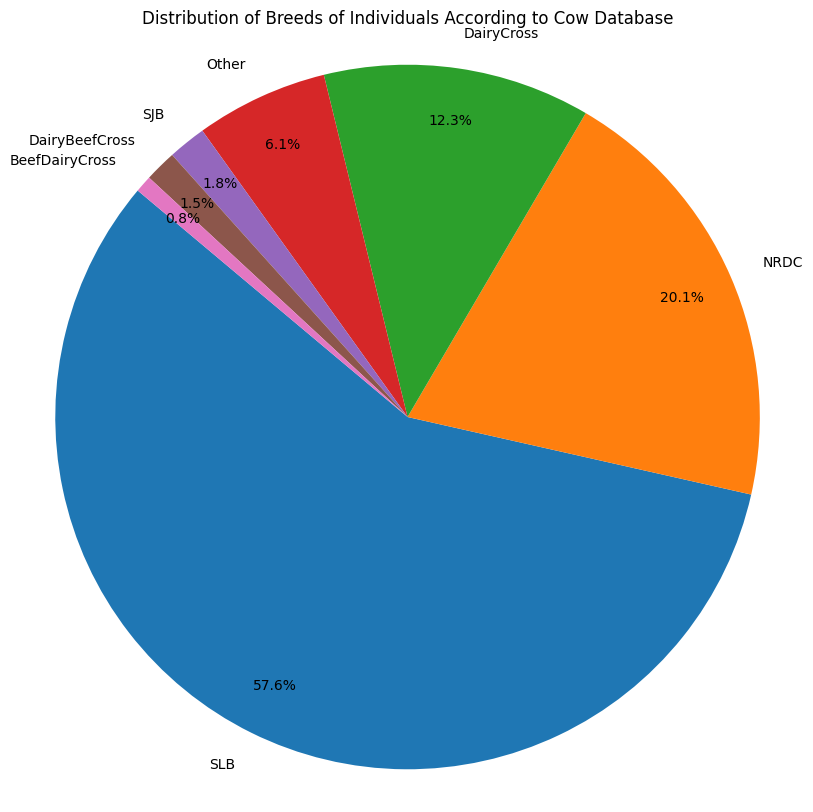

BreedNameDelPro
02 SLB                        3287
01 SRB                         879
04 SJB                         100
99 Korsning/obestämbar ras      98
06 RB                           71
Unknown Breed                   46
27 Montbéliard                  19
99 Korsning/Obest Ras            6
186                              4
41 Fjällko                       3
08 Hereford                      2
99 Korsning/övriga raser         2
11 Aberdeen Angus                1
28 Fleckvieh                     1
187                              1
03 SKB                           1
Name: count, dtype: int64


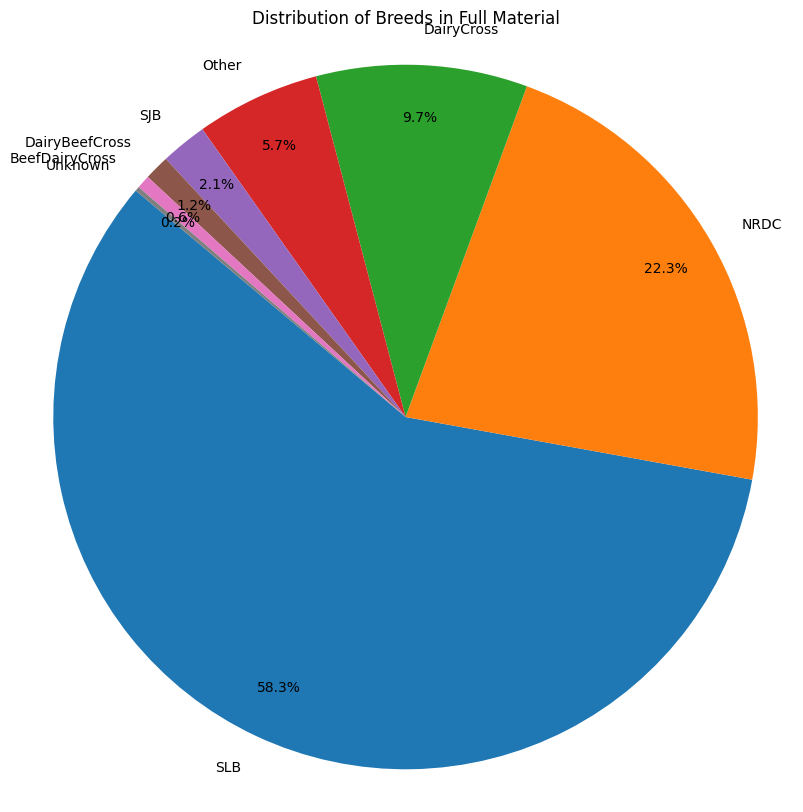

Breed
SLB               4841
NRDC              1849
DairyCross         805
Other              473
SJB                177
DairyBeefCross      96
BeefDairyCross      51
Unknown             17
Name: count, dtype: int64


In [18]:
#
#
# PAIRING COW DATABASE AND DELPRO FOR BREED
cKok4 = pd.read_csv("../Data/CowData/dfKok.csv", low_memory=False)
cKok4 = cKok4.drop_duplicates(subset=["SE_Number"])
col_keep = ["FarmName_Pseudo", "SE_Number", "SireBreedKok", "DamBreedKok", "MGSBreedKok"]
cKok4 = cKok4[col_keep]
cKok4 = cKok4.drop_duplicates(subset=["SE_Number"])

cDel4 = pd.read_csv("../Data/CowData/dfDelPro.csv", low_memory=False)
cDel4 = cDel4.drop_duplicates(subset=["SE_Number"])
col_keep = ["FarmName_Pseudo", "SE_Number", "BreedNameDelPro"]
cDel4 = cDel4[col_keep]
cDel4 = cDel4.drop_duplicates(subset=["SE_Number"])

merged_df = pd.merge(cKok4, cDel4, on=["FarmName_Pseudo", "SE_Number"], how='outer')

# Setting options to display more rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

frequency_table = pd.crosstab(merged_df['SireBreedKok'], merged_df['DamBreedKok'])
print(frequency_table)


# Define breeds in cow database
def categorize1(value):
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "SRB"):
        return "NRDC"
    if (value["SireBreedKok"] == "RB") and (value["DamBreedKok"] == "RB"):
        return "NRDC"
    if (value["SireBreedKok"] == "RB-SRB") and (value["DamBreedKok"] == "RB-SRB"):
        return "NRDC"
    if (value["SireBreedKok"] == "RB") and (value["DamBreedKok"] == "RB-SRB"):
        return "NRDC"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "RB"):
        return "NRDC"
    if (value["SireBreedKok"] == "RB-SRB") and (value["DamBreedKok"] == "RB-SRB"):
        return "NRDC"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "RB-SRB"):
        return "NRDC"
    if (value["SireBreedKok"] == "RB") and (value["DamBreedKok"] == "SRB"):
        return "NRDC"
    if (value["SireBreedKok"] == "RB-SRB") and (value["DamBreedKok"] == "SRB"):
        return "NRDC"
    if (value["SireBreedKok"] == "SRB-RB") and (value["DamBreedKok"] == "SRB"):
        return "NRDC"
    if (value["SireBreedKok"] == "RB") and (value["DamBreedKok"] == "SRB-RB"):
        return "NRDC"
    if (value["SireBreedKok"] == "SAB") and (value["DamBreedKok"] == "SAB"):
        return "NRDC"

    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SLB"):
        return "SLB"
    if (value["SireBreedKok"] == "SJB") and (value["DamBreedKok"] == "SJB") and (value["MGSBreedKok"] == "SJB"):
        return "SJB"

    if (value["SireBreedKok"] == "FJÄ") and (value["DamBreedKok"] == "FJÄ"):
        return "Other"
    if (value["SireBreedKok"] == "SIM") and (value["DamBreedKok"] == "SIM"):
        return "Other"

    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "SLB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "RB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "RB-SLB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "RB-SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SJB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SJB-SLB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SJB-SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SKB-SJB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SKB-SLB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SLB-RB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SLB-SJB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SLB-SKB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SLB-SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SRB-RB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SRB-SJB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SRB-SLB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "RB-SJB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "SJB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "SJB-SLB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "SJB-SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "SLB-SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "SRB-SKB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "SRB-SLB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "RB") and (value["DamBreedKok"] == "SJB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "RB") and (value["DamBreedKok"] == "SJB-SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "RB") and (value["DamBreedKok"] == "SLB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "RB") and (value["DamBreedKok"] == "SRB-SJB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "RB") and (value["DamBreedKok"] == "SRB-SLB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SKB") and (value["DamBreedKok"] == "FJÄ"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "SAB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SAB") and (value["DamBreedKok"] == "SAB-SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SAB-SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "SAB-SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SAB-SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SLB-BSW"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SLB-SAB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "RB") and (value["DamBreedKok"] == "SRB-SAB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SAB") and (value["DamBreedKok"] == "SRB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SRB-SAB"):
        return "DairyCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "SRB-SAB"):
        return "DairyCross"

    if (value["SireBreedKok"] == "RB") and (value["DamBreedKok"] == "MON-SLB"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "CHA-RB"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "HER-SLB"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "MON-RB"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "MON-SLB"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "MON-SRB"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SLB-HER"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SRB-MON"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SLB") and (value["DamBreedKok"] == "SLB-MON"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "MON-SLB"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SRB") and (value["DamBreedKok"] == "MON-SRB"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SJB") and (value["DamBreedKok"] == "SIM-SJB"):
        return "DairyBeefCross"
    if (value["SireBreedKok"] == "SJB") and (value["DamBreedKok"] == "SJB-SIM"):
        return "DairyBeefCross"

    if (value["SireBreedKok"] == "CHA") and (value["DamBreedKok"] == "RB-SRB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "CHA") and (value["DamBreedKok"] == "SLB-SRB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "MON") and (value["DamBreedKok"] == "SLB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "MON") and (value["DamBreedKok"] == "SRB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "MON") and (value["DamBreedKok"] == "RB-SLB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "MON") and (value["DamBreedKok"] == "RB-SRB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "MON") and (value["DamBreedKok"] == "SRB-SLB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "MON") and (value["DamBreedKok"] == "SLB-SRB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "SIM") and (value["DamBreedKok"] == "SJB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "SIM") and (value["DamBreedKok"] == "SRB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "SIM") and (value["DamBreedKok"] == "SRB-SJB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "SIM") and (value["DamBreedKok"] == "SRB-SAB"):
        return "BeefDairyCross"
    if (value["SireBreedKok"] == "HER") and (value["DamBreedKok"] == "SLB-SRB"):
        return "BeefDairyCross"

    if pd.isna(value["SireBreedKok"]) and pd.isna(value["DamBreedKok"]) and pd.isna(value["MGSBreedKok"]):
        return np.nan
    else:
        return 'Other'


merged_df['BreedKok'] = merged_df.apply(categorize1, axis=1)
merged_df.to_csv("../Data/CowData/breed.csv", index=False)

# Count the occurrences of each unique value in the breed column
value_counts = merged_df['BreedKok'].value_counts()
plt.figure(figsize=(10, 10))  # Optional: Set the figure size
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.axis('equal')
plt.title('Distribution of Breeds of Individuals According to Cow Database')
plt.show()

# Fix missing breed info from DelPro
frequency_table = merged_df['BreedNameDelPro'].value_counts()
print(frequency_table)


# Define breeds in delpro
def categorize2(value):
    if value["BreedNameDelPro"] == "01 SRB":
        return "NRDC"
    if value["BreedNameDelPro"] == "06 RB":
        return "NRDC"
    if value["BreedNameDelPro"] == "02 SLB":
        return "SLB"
    if value["BreedNameDelPro"] == "04 SJB":
        return "SJB"
    if value["BreedNameDelPro"] == "03 SKB":
        return "Other"
    if value["BreedNameDelPro"] == "Unknown Breed":
        return "Unknown"
    if value["BreedNameDelPro"] == "186":
        return "Unknown"
    if value["BreedNameDelPro"] == "187":
        return "Unknown"
    if value["BreedNameDelPro"] == "99 Korsning/Obest Ras":
        return "Unknown"
    if value["BreedNameDelPro"] == "99 Korsning/övriga raser":
        return "Unknown"
    if value["BreedNameDelPro"] == "41 Fjällko":
        return "Other"
    if value["BreedNameDelPro"] == "08 Hereford":
        return "Other"
    if value["BreedNameDelPro"] == "11 Aberdeen Angus":
        return "Other"
    if value["BreedNameDelPro"] == "28 Fleckvieh":
        return "Other"
    if value["BreedNameDelPro"] == "27 Montbéliard":
        return "Other"
    if (value["BreedKok"] == "Missing") & pd.isna(value["BreedNameDelPro"]):
        return np.nan
    if pd.isna(value["BreedNameDelPro"]):
        return np.nan
    else:
        return "Other"


merged_df['BreedDelPro'] = merged_df.apply(categorize2, axis=1)

merged_df['Breed'] = merged_df['BreedKok'].fillna(merged_df['BreedDelPro'])
merged_df.to_csv("../Data/CowData/breed.csv", index=False)

# Count the occurrences of each unique value in the 'Fruit' column
value_counts = merged_df['Breed'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.85)
plt.axis('equal')
plt.title('Distribution of Breeds in Full Material')
plt.show()

# Fix missing breed info from DelPro
frequency_table = merged_df['Breed'].value_counts()
print(frequency_table)

In [19]:
#
#
# PAIRING COW DATABASE AND DELPRO FOR INSEMINATION DATA
cKok4 = pd.read_csv("../Data/CowData/dfKok.csv", low_memory=False)
cKok4 = cKok4.drop_duplicates(subset=["SE_Number", "InseminationDateKok"])
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumberKok", "InseminationDateKok"]
cKok4 = cKok4[col_keep]
cKok4.rename(columns={"LactationNumberKok": "LactationNumber"}, inplace=True)
cKok4 = cKok4.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDateKok"])

cDel4 = pd.read_csv("../Data/CowData/dfDelPro.csv", low_memory=False)
cDel4 = cDel4.drop_duplicates(subset=["SE_Number", "InseminationDateDelPro"])
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumberDelPro", "InseminationDateDelPro"]
cDel4 = cDel4[col_keep]
cDel4.rename(columns={"LactationNumberDelPro": "LactationNumber"}, inplace=True)
cDel4 = cDel4.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDateDelPro"])

merged_df = pd.merge(cKok4, cDel4, on=["FarmName_Pseudo", "SE_Number", "LactationNumber"], how='outer')
merged_df['InseminationDate'] = merged_df['InseminationDateKok'].fillna(merged_df['InseminationDateDelPro'])
merged_df = merged_df.drop_duplicates(subset=["SE_Number", "InseminationDate"])

"""
# Subset chosen cow
# obs 867, SE-169e580a-2843, good example cow
SE_Number = ["SE-064c0cec-1189"]
merged_df = merged_df[merged_df["SE_Number"].isin(SE_Number)]
"""

merged_df = merged_df.sort_values(by=["FarmName_Pseudo", "SE_Number", "LactationNumber", "InseminationDate"])
merged_df.to_csv("../Data/CowData/insemination.csv", index=False)

In [20]:
#
#
# PAIRING PREGNANCY CHECK FROM COW DATABASE AND DELPRO
cKok5 = pd.read_csv("../Data/CowData/dfKok.csv", low_memory=False)
cKok5 = cKok5.drop_duplicates(subset=["SE_Number", "PregnancyCheckDateKok"])
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumberKok", "PregnancyCheckDateKok", "PregnancyStatusKok"]
cKok5 = cKok5[col_keep]
cKok5.rename(columns={"LactationNumberKok": "LactationNumber"}, inplace=True)
cKok5 = cKok5.drop_duplicates(subset=["SE_Number", "LactationNumber", "PregnancyCheckDateKok"])

cDel5 = pd.read_csv("../Data/CowData/dfDelPro.csv", low_memory=False)
cDel5 = cDel5.drop_duplicates(subset=["SE_Number", "InseminationDateDelPro"])
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumberDelPro", "PregnancyCheckDateDelPro",
            "PregnancyCheckResultDelPro"]
cDel5 = cDel5[col_keep]
cDel5.rename(columns={"LactationNumberDelPro": "LactationNumber"}, inplace=True)
cDel5 = cDel5.drop_duplicates(subset=["SE_Number", "LactationNumber", "PregnancyCheckDateDelPro"])

merged_df = pd.merge(cKok5, cDel5, on=["FarmName_Pseudo", "SE_Number", "LactationNumber"], how='outer')
merged_df['PregnancyCheckDate'] = merged_df['PregnancyCheckDateKok'].fillna(merged_df['PregnancyCheckDateDelPro'])
merged_df['PregnancyStatus'] = merged_df['PregnancyStatusKok'].fillna(merged_df['PregnancyCheckResultDelPro'])
merged_df = merged_df.drop_duplicates(subset=["SE_Number", "PregnancyCheckDate"])

"""
# Subset chosen cow
# obs 867, SE-169e580a-2843, good example cow
SE_Number = ["SE-064c0cec-1189"]
merged_df = merged_df[merged_df["SE_Number"].isin(SE_Number)]
"""

merged_df.to_csv("../Data/CowData/pregnancy_checks.csv", index=False)

In [2]:
#
#
# BUILD MASTER DATAFRAME
test2a = pd.read_csv("../Data/CowData/calving.csv", low_memory=False)
test2b = pd.read_csv("../Data/CowData/breed.csv", low_memory=False)
col_keep = ["FarmName_Pseudo", "SE_Number", "Breed"]
test2b = test2b[col_keep]
test2c = pd.merge(test2a, test2b, on=["FarmName_Pseudo", "SE_Number"], how='outer')
test2c.to_csv("../Data/CowData/updateDF.csv", index=False)

test2d = pd.read_csv("../Data/CowData/insemination.csv", low_memory=False)
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "InseminationDate"]
test2d = test2d[col_keep]
test2d = test2d.drop_duplicates(subset=["FarmName_Pseudo", "SE_Number", "LactationNumber", "InseminationDate"])
test2e = pd.merge(test2c, test2d, on=["FarmName_Pseudo", "SE_Number", "LactationNumber"], how='outer')
test2e.to_csv("../Data/CowData/updateDF.csv", index=False)

test2f = pd.read_csv("../Data/CowData/pregnancy_checks.csv", low_memory=False)
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "PregnancyCheckDate", "PregnancyStatus"]
test2f = test2f[col_keep]
test2f = test2f.drop_duplicates(subset=["FarmName_Pseudo", "SE_Number", "LactationNumber", "PregnancyCheckDate"])
test2g = pd.merge(test2e, test2f, on=["FarmName_Pseudo", "SE_Number", "LactationNumber"], how='outer')
# test2g = test2g.drop_duplicates(subset=["FarmName_Pseudo", "SE_Number", "LactationNumber", "PregnancyCheckDate"])
test2g = test2g.sort_values(by=["FarmName_Pseudo", "SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
test2g.to_csv("../Data/CowData/updateDF.csv", index=False)

test2h = pd.read_csv("../Data/CowData/dry_off.csv", low_memory=False)
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "DryOffDate"]
test2h = test2h[col_keep]
test2h = test2h.drop_duplicates(subset=["FarmName_Pseudo", "SE_Number", "LactationNumber", "DryOffDate"])
test2i = pd.merge(test2g, test2h, on=["FarmName_Pseudo", "SE_Number", "LactationNumber"], how='outer')

"""
# Subset chosen cow
# obs 867, SE-169e580a-2843, good example cow
SE_Number = ["SE-064c0cec-1189"]
test2i = test2i[test2i["SE_Number"].isin(SE_Number)]
"""
test2i.to_csv("../Data/CowData/updateDF.csv", index=False)

test2j = pd.read_csv("../Data/CowData/culling.csv", low_memory=False)
test2j = test2j.drop_duplicates(subset=["FarmName_Pseudo", "SE_Number", "CullingDate"])
test2k = pd.merge(test2i, test2j, on=["FarmName_Pseudo", "SE_Number"], how='outer')
test2k.to_csv("../Data/CowData/updateDF.csv", index=False)

"""
# Subset chosen cow
# obs 867, SE-169e580a-2843, good example cow
SE_Number = ["SE-064c0cec-1189"]
test2k = test2k[test2k["SE_Number"].isin(SE_Number)]
"""

col_keep = ["SE_Number", "LactationNumber", "CalvingDate", "InseminationDate", "PregnancyCheckDate", "PregnancyStatus"]
test2k2 = test2k[col_keep]

# Sort pregnancy checks and keep only for relevant insemination
test2l = test2k2.drop_duplicates(subset=["SE_Number", "CalvingDate", "InseminationDate"])
test2l = test2l.copy()
test2l["next_ins"] = test2l.groupby(["SE_Number", "LactationNumber"])["InseminationDate"].shift(-1)
col_keep = ["SE_Number", "LactationNumber", "InseminationDate", "next_ins"]
test2l = test2l[col_keep]
test2m = pd.merge(test2k2, test2l, on=["SE_Number", "LactationNumber", "InseminationDate"], how='outer')
# test2m.to_csv("updateDF2.csv", index=False)

test2m.loc[test2m['PregnancyCheckDate'] > test2m['next_ins'], 'PregnancyCheckDate'] = np.nan
test2m.loc[test2m['PregnancyCheckDate'] < test2m['InseminationDate'], 'PregnancyCheckDate'] = np.nan
# test2m.to_csv("updateDF3.csv", index=False)

test2n = test2m.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
test2n = test2n.sort_values(by=["SE_Number", "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
# test2n.to_csv("updateDF.csv", index=False)

df_not_missing = test2n[test2n['PregnancyCheckDate'].notna()]
# df_not_missing.to_csv("updateDF4.csv", index=False)

test2o = test2n[test2n['PregnancyCheckDate'].isnull()]
col_keep = ["SE_Number", "LactationNumber", "CalvingDate", "InseminationDate"]
test2o = test2o[col_keep]
# test2o.to_csv("updateDF5.csv", index=False)

test2p = pd.merge(df_not_missing, test2o, on=["SE_Number", "LactationNumber", "CalvingDate", "InseminationDate"], how='outer')
# test2p.to_csv("updateDF2.csv", index=False)

test2q = pd.read_csv("../Data/CowData/updateDF.csv", low_memory=False)
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "CalvingDate", "Breed", "DryOffDate", "CullingDate",
            "ExitReason_PrimaryReasonKok", "ExitReason_SecondaryReason1Kok", "ExitReason_SecondaryReason2Kok",
            "CullingReason1", "CullingReason2"]
test2q = test2q[col_keep]
test2r = pd.merge(test2q, test2p, on=["SE_Number", "LactationNumber", "CalvingDate"], how='left')
test2r.to_csv("../Data/CowData/updateDF3.csv", index=False)

df = pd.read_csv("../Data/CowData/updateDF3.csv", low_memory=False)
print(f"No. of pregnancy checks in database: {df.shape}")  # 327,839 pregnancy checks
df2 = df.drop_duplicates(subset=["SE_Number", "LactationNumber", "InseminationDate"])
print(f"No. of inseminations in dataset: {df2.shape}")  # 36,506 inseminations
df2 = df.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of lactations in dataset: {df2.shape}")  # 20,683 lactations
df2 = df.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows in dataset: {df2.shape}")  # 9,535 cows
df2 = df.drop_duplicates(subset=["FarmName_Pseudo"])
print(f"No. of herds in dataset: {df2.shape}")  # 57 herds

#
#
# ADD LINEAGE INFORMATION
lin = pd.read_csv("../Data/CowData/Kok_Lineage240821.csv", delimiter=';', low_memory=False)
col_keep = ["BirthID", "BirthDate", "Father_SE_Number", "Mother_SE_Number"]
lin = lin[col_keep]
lin.rename(columns={'BirthID': 'SE_Number'}, inplace=True)

print(f"No. of unique cows in database: {lin.shape}")  # 24,067
lin = lin.drop_duplicates(subset=["SE_Number", "BirthDate", "Father_SE_Number", "Mother_SE_Number"])
print(f"No. of unique cows in database: {lin.shape}")  # 22,666

df = pd.read_csv("../Data/CowData/updateDF3.csv", low_memory=False)
lin2 = df.merge(lin, on=["SE_Number"], how="left")

# Change order of columns
new_column_order = ["FarmName_Pseudo", "SE_Number", "Breed", "BirthDate", "Father_SE_Number", "Mother_SE_Number",
                    "CalvingDate", "LactationNumber", "InseminationDate",
                    "PregnancyCheckDate", "PregnancyStatus", "DryOffDate", "CullingDate", "ExitReason_PrimaryReasonKok",
                    "ExitReason_SecondaryReason1Kok", "ExitReason_SecondaryReason2Kok", "CullingReason1",
                    "CullingReason2"]
lin2 = lin2[new_column_order]
lin2 = lin2.drop_duplicates(subset=["SE_Number", "CalvingDate", "LactationNumber", "InseminationDate",
                                    "PregnancyCheckDate"])
"""
SE_Number = ["SE-064c0cec-1189"]
lin2 = lin2[lin2["SE_Number"].isin(SE_Number)]
"""

# REORDER PregnancyStatus
unique_values = lin2['PregnancyStatus'].unique()
print(unique_values)

lin2["PregnancyStatus"] = lin2["PregnancyStatus"].replace(
    {"Dräktig (undersökt) Dr": 2,
     "Dräktig Analys Dr A": 52,
     "Dräktig (ej undersökt) Dr": 22,
     "Dräktig (tjurbetäckt) Dr": 32,
     "Ej dräktig (tjurbetäckt) eDr": 31,
     "Dräktig ? Analys Dr? A": 53,
     "Ej Dräktig (ej undersökt) eDr": 21,
     "Negative": 51,
     "Positive": 52,
     "Uncertain": 53,
     "Dräktig ? (undersökt) Dr?": 3,
     "Dräktig, (sem/bet annan bes) Dr": 42,
     "Dräktig ? (tjurbetäckt) Dr?": 33,
     "Ej dräktig Analys eDr A": 51,
     "Ej Dräktig (undersökt) eDr": 1})

lin2.to_csv("../Data/CowData/updateDF.csv", index=False)

No. of pregnancy checks in database: (325050, 16)
No. of inseminations in dataset: (33732, 16)
No. of lactations in dataset: (17909, 16)
No. of cows in dataset: (8865, 16)
No. of herds in dataset: (57, 16)
No. of unique cows in database: (24067, 4)
No. of unique cows in database: (22666, 4)
['Dräktig (undersökt) Dr' nan 'Dräktig Analys Dr A'
 'Ej dräktig Analys eDr A' 'Ej Dräktig (undersökt) eDr'
 'Dräktig (ej undersökt) Dr' 'Dräktig (tjurbetäckt) Dr'
 'Ej dräktig (tjurbetäckt) eDr' 'Dräktig ? Analys Dr? A'
 'Ej Dräktig (ej undersökt) eDr' 'Negative' 'Positive' 'Uncertain'
 'Dräktig ? (undersökt) Dr?' 'Dräktig, (sem/bet annan bes) Dr'
 'Dräktig ? (tjurbetäckt) Dr?']


C:\Users\pagd0001\AppData\Local\Temp\ipykernel_33384\1304262400.py:136: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lin2["PregnancyStatus"] = lin2["PregnancyStatus"].replace(


# MILKING DATA FROM DELPRO
- using Del_CowMilkYield_Common
- creates MY.csv

In [22]:
#
#
# MILKING DATA
# Del_CowMilkYield_Common240823
dfmy = pd.read_csv("../Data/CowData/Del_CowMilkYield_Common240823.csv", delimiter=';', low_memory=False)
print(f"No. of milking events in raw data: {dfmy.shape}")  # 5,628,715 x 15
print(dfmy.dtypes)

# No. lactation and cows in raw data
test = dfmy.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of lactation in raw milking file: {test.shape}")  # 8,352
test = dfmy.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows in raw milking file: {test.shape}")  # 3,916

# Remove pure duplicates
dfmy = dfmy.drop_duplicates(subset=["SE_Number", "LactationNumber", "StartDate", "StartTime", "SessionNumber", "TotalYield"])
print(f"No. of milking events in raw data: {dfmy.shape}")  # 5,624,788

# No. lactation and cows in data
test = dfmy.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of lactation after removed pure duplicates: {test.shape}")  # 8,352
test = test.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows after removed pure duplicates {test.shape}")  # 3,916

# Keep relevant col
# LactationNumber removed because of missing values, e.g. SE-064c0cec-1188
# DaysInMilk removed due to counting day 1 as day 0, reinitialize later
col_keep = ["FarmName_Pseudo", "SE_Number", "AnimalNumber", "Del_Cow_Id", "LactationNumber", "DaysInMilk", "StartDate", "StartTime", "SessionNumber", "TotalYield"]
dfmy = dfmy[col_keep]

# Which herds are in this file?
dfmy_unique2 = dfmy.drop_duplicates(subset=["FarmName_Pseudo"])
dfmy_unique2 = dfmy_unique2.drop(columns=["SE_Number", "StartDate", "StartTime", "LactationNumber", "DaysInMilk", "SessionNumber", "TotalYield"])
print(dfmy_unique2.to_string(index=False))

# Change TotalYield comma to dot
dfmy["TotalYield"] = dfmy["TotalYield"].str.replace(',', '.')
# Change to datetime
dfmy["StartDate"] = pd.to_datetime(dfmy["StartDate"])

dfmy = dfmy.sort_values(by=["SE_Number", "LactationNumber", "StartDate", "StartTime", "SessionNumber", "TotalYield"])

# Remove missing yield
dfmy2 = dfmy[pd.notna(dfmy["TotalYield"])]
print(f"No. of milking records with recorded yield in milking file: {dfmy2.shape}")  # 4,948,464

# No. lactation and cows in data
test = dfmy2.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of lactations after removed missing yield: {test.shape}")  # 7920
test = dfmy2.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows after removed missing yield: {test.shape}")  # 3,657

# Remove duplicated sessions
dfmy2 = dfmy2.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
dfmy2 = dfmy2.drop_duplicates(subset=["SE_Number", "LactationNumber", "StartDate", "SessionNumber", "TotalYield"])
print(f"No. of unique milking records in milking file: {dfmy2.shape}")  # 4,947,223
dfmy2.to_csv("../Data/CowData/MY.csv", index=False)

# No. lactation and cows in data
test = dfmy2.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of lactations after removed duplicated sessions: {test.shape}")  # 7,920
test = dfmy2.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows after removed duplicated sessions: {test.shape}")  # 3,657

# Check raw data for each herd
FarmName_Pseudo = ["a624fb9a"]
lactation_yield = dfmy2[dfmy2["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3a.csv", index=False)
print(f"No. of unique milking records in a624fb9a milking file: {lactation_yield.shape}")  # 441,149

FarmName_Pseudo = ["5f7f33d6"]
lactation_yield = dfmy2[dfmy2["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3b.csv", index=False)
print(f"No. of unique milking records in 5f7f33d6 milking file: {lactation_yield.shape}")  # 485,361

FarmName_Pseudo = ["ab18b151"]
lactation_yield = dfmy2[dfmy2["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3c.csv", index=False)
print(f"No. of unique milking records in ab18b151 milking file: {lactation_yield.shape}")  # 231,172

FarmName_Pseudo = ["f454e660"]
lactation_yield = dfmy2[dfmy2["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3d.csv", index=False)
print(f"No. of unique milking records in f454e660 milking file: {lactation_yield.shape}")  # 449,080

FarmName_Pseudo = ["540275a1"]
lactation_yield = dfmy2[dfmy2["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3e.csv", index=False)
print(f"No. of unique milking records in 540275a1 milking file: {lactation_yield.shape}")  # 312,961

FarmName_Pseudo = ["afdd9a78"]
lactation_yield = dfmy2[dfmy2["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3f.csv", index=False)
print(f"No. of unique milking records in afdd9a78 milking file: {lactation_yield.shape}")  # 45,618

FarmName_Pseudo = ["5b581702"]
lactation_yield = dfmy2[dfmy2["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3g.csv", index=False)
print(f"No. of unique milking records in 5b581702 milking file: {lactation_yield.shape}")  # 111,634

FarmName_Pseudo = ["5c06d92d"]
lactation_yield = dfmy2[dfmy2["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3h.csv", index=False)
print(f"No. of unique milking records in 5c06d92d milking file: {lactation_yield.shape}")  # 971,965

FarmName_Pseudo = ["752efd72"]
lactation_yield = dfmy2[dfmy2["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3i.csv", index=False)
print(f"No. of unique milking records in 752efd72 milking file: {lactation_yield.shape}")  # 863,077

# Have 300,000 records but almost all missing MY!
FarmName_Pseudo = ["a756bc39"]
lactation_yield = dfmy[dfmy["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3j.csv", index=False)
print(f"No. of unique milking records in a756bc39 milking file: {lactation_yield.shape}")  # 314,841! MY miss

FarmName_Pseudo = ["ad0a39f5"]
lactation_yield = dfmy2[dfmy2["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3k.csv", index=False)
print(f"No. of unique milking records in ad0a39f5 milking file: {lactation_yield.shape}")  # 517,188

# Have 138,922 sessions recorded, but almost all are missing yield!
FarmName_Pseudo = ["6d38bc90"]
lactation_yield = dfmy[dfmy["FarmName_Pseudo"].isin(FarmName_Pseudo)]
lactation_yield = lactation_yield.sort_values(by=['SE_Number', 'StartDate', 'SessionNumber'])
# lactation_yield.to_csv("../Data/CowData/lact3l.csv", index=False)
print(f"No. of unique milking records in 6d38bc90 milking file: {lactation_yield.shape}")  # 153,211 MY miss!

# Find start of recording within respective herd
first_observations = dfmy2.groupby("FarmName_Pseudo")["StartDate"].first().reset_index()
print(f"Start of recording in Gigacow in different herds: \n", first_observations.to_string(index=False))

# No. MY records per herd
count_my_rec = dfmy2.groupby(["FarmName_Pseudo"])["StartDate"].count().reset_index()
print(f"No. milking events per herd: \n", count_my_rec.to_string(index=False))

# Add lactation number and upper_limit to MY file to sort MY data to correct lactation
# Because LactationNumber is not always used in the MY file
test2l = pd.read_csv("../Data/CowData/updateDF.csv", low_memory=False)
print(f"Calving, insemination, pregnancy checks, culling and dry off data with milking data: {test2l.shape}")
# 22,972,867

test2m = pd.read_csv("../Data/CowData/dfKok.csv", low_memory=False)
test2m = test2m.drop_duplicates(subset=["SE_Number", "LactationNumberKok", "upper_limit"])
test2m.rename(columns={"LactationNumberKok": "LactationNumber"}, inplace=True)
col_keep = ["SE_Number", "LactationNumber", "upper_limit"]
test2m = test2m[col_keep]

print(test2l.columns)
print(test2m.columns)

test2n = pd.merge(test2l, test2m, on=["SE_Number", "LactationNumber"], how='left')
col_keep = ["FarmName_Pseudo", "SE_Number", "CalvingDate", "LactationNumber", "upper_limit"]
test2n = test2n[col_keep]
test2n = test2n.drop_duplicates(subset=["SE_Number", "LactationNumber"])

"""
# Subset chosen cow
SE_Number = ["SE-064c0cec-1189"]
test2n = test2n[test2n["SE_Number"].isin(SE_Number)]
test2n.to_csv("MY2.csv", index=False)
"""

# Load MY data
dfmy3 = pd.read_csv("../Data/CowData/MY.csv", low_memory=False)
col_keep = ["FarmName_Pseudo", "SE_Number", "AnimalNumber", "Del_Cow_Id", "StartDate", "StartTime", "SessionNumber", "TotalYield"]
dfmy3 = dfmy3[col_keep]

"""
# Subset chosen cow
SE_Number = ["SE-064c0cec-1189"]
dfmy3 = dfmy3[dfmy3["SE_Number"].isin(SE_Number)]
"""

# Merge
dfmy3 = test2n.merge(dfmy3, on=["FarmName_Pseudo", "SE_Number"], how="left")
dfmy3 = dfmy3.sort_values(by=["SE_Number", "LactationNumber", "StartDate", "StartTime"])

# only keep MY data where falls within lactation, ie between CalvingDate and upper_limit
# where upper_limit is either next lactation, slaughter date or today's date for open records (ie ongoing lactation)
dfmy4 = dfmy3[(dfmy3["StartDate"] >= dfmy3["CalvingDate"]) & (dfmy3["StartDate"] <= dfmy3["upper_limit"])]

"""
SE_Number = ["SE-064c0cec-1189"]
dfmy4 = dfmy4[dfmy4["SE_Number"].isin(SE_Number)]
"""

# Make DIM
dfmy4 = dfmy4.copy()
dfmy4["StartDate"] = pd.to_datetime(dfmy4["StartDate"])
dfmy4["CalvingDate"] = pd.to_datetime(dfmy4["CalvingDate"])
dfmy4["DaysInMilk"] = (dfmy4["StartDate"] - dfmy4["CalvingDate"]).dt.days + 1
dfmy4.to_csv("../Data/CowData/MY.csv", index=False)

No. of milking events in raw data: (5628715, 15)
Unnamed: 0                   int64
Del_Cow_Id                   int64
FarmName_Pseudo             object
SE_Number                   object
AnimalNumber                 int64
StartDate                   object
StartTime                   object
LactationNumber            float64
DaysInMilk                 float64
LactationInfoSource         object
SessionNumber              float64
TotalYield                  object
OriginalFileSource          object
dwh_factCowMilk_Id         float64
dwh_factCowMilkOther_Id    float64
dtype: object
No. of lactation in raw milking file: (8352, 15)
No. of cows in raw milking file: (3916, 15)
No. of milking events in raw data: (5624788, 15)
No. of lactation after removed pure duplicates: (8352, 15)
No. of cows after removed pure duplicates (3916, 15)
FarmName_Pseudo  AnimalNumber  Del_Cow_Id
       f454e660           323        1079
       a624fb9a          1265        2415
       5f7f33d6            -1   

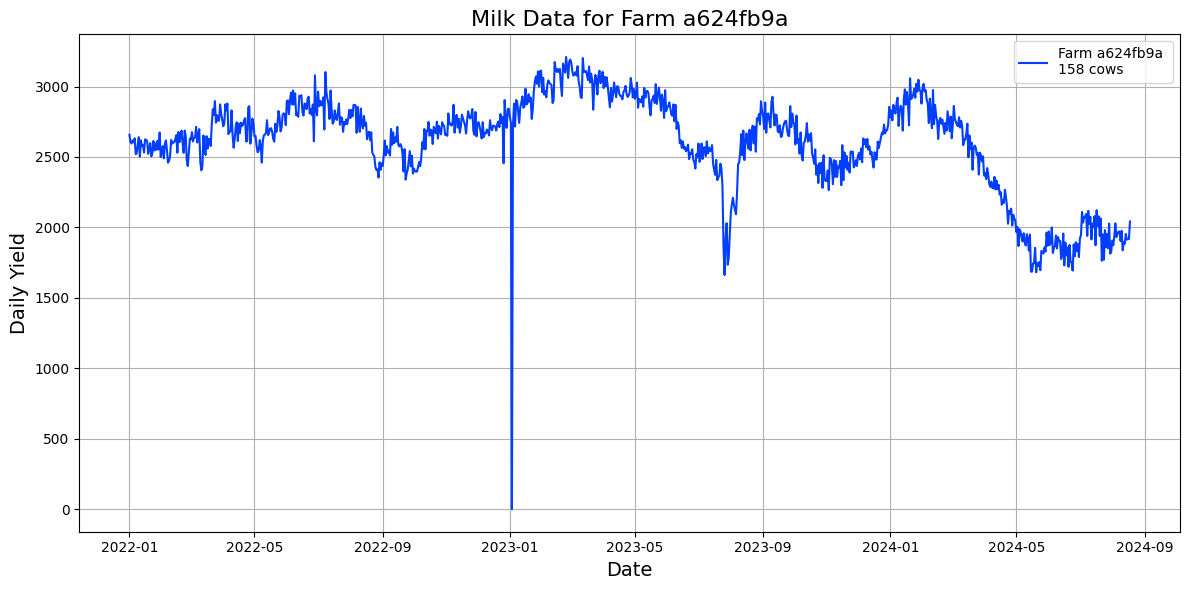

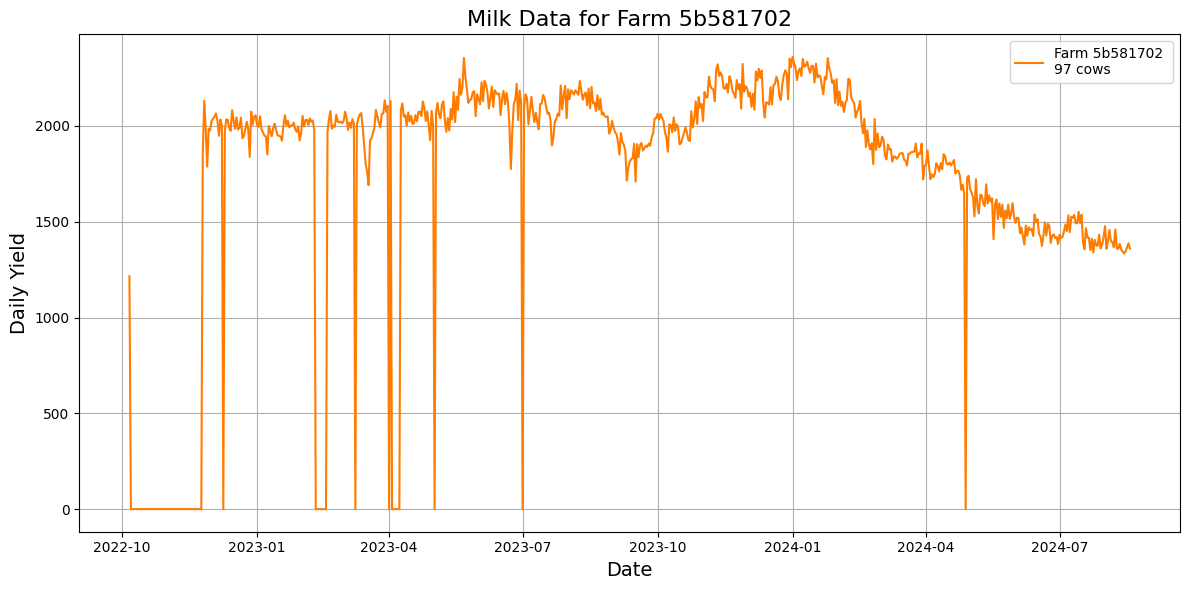

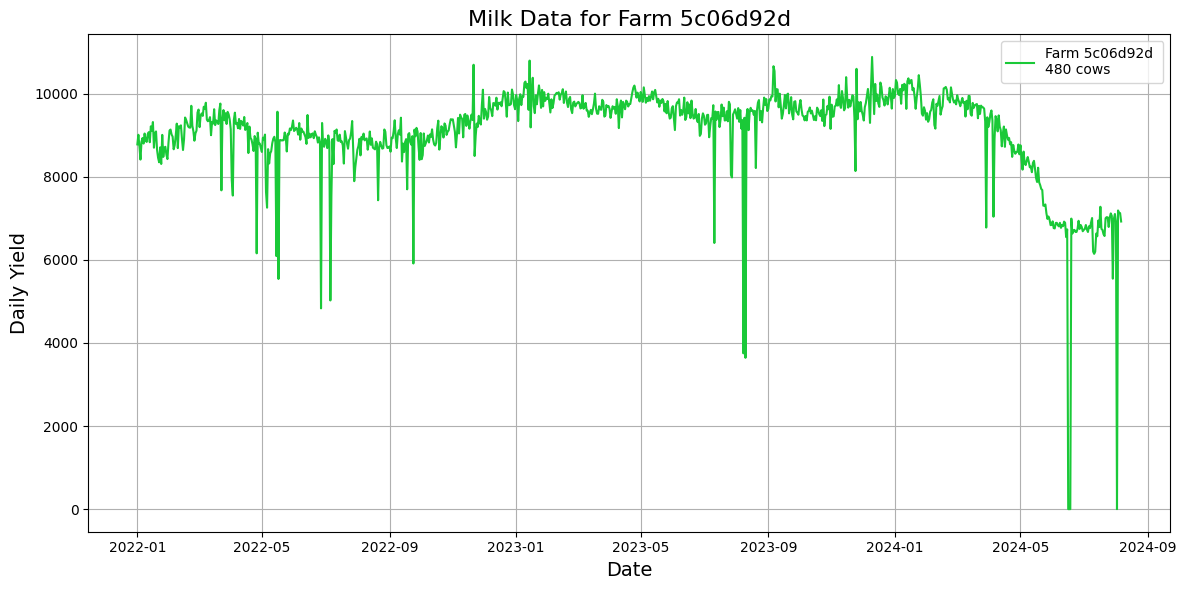

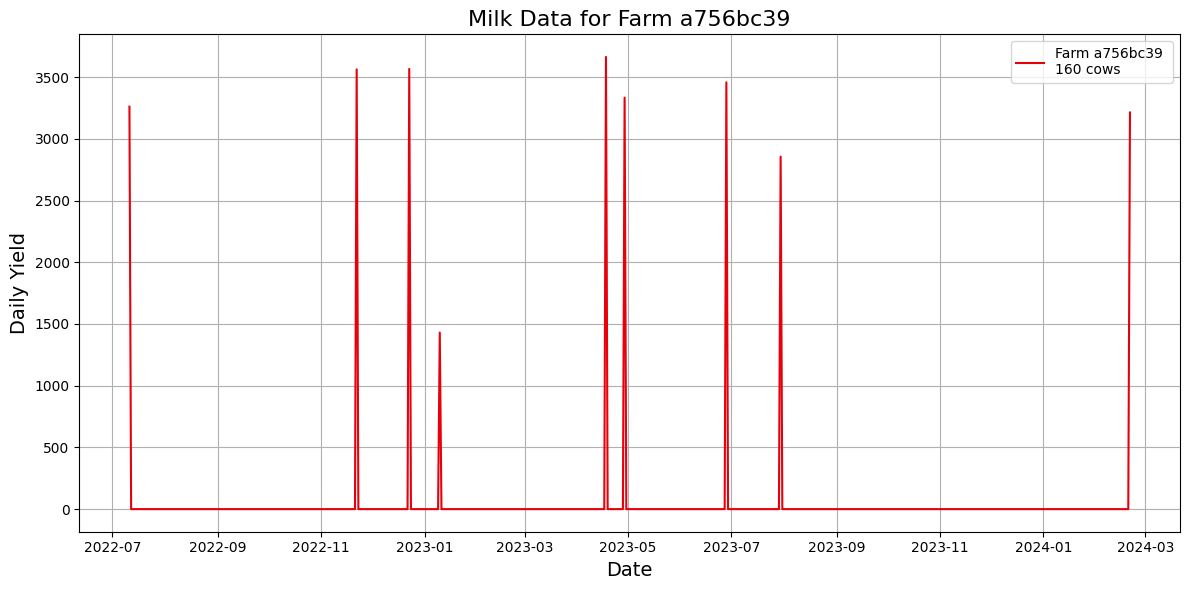

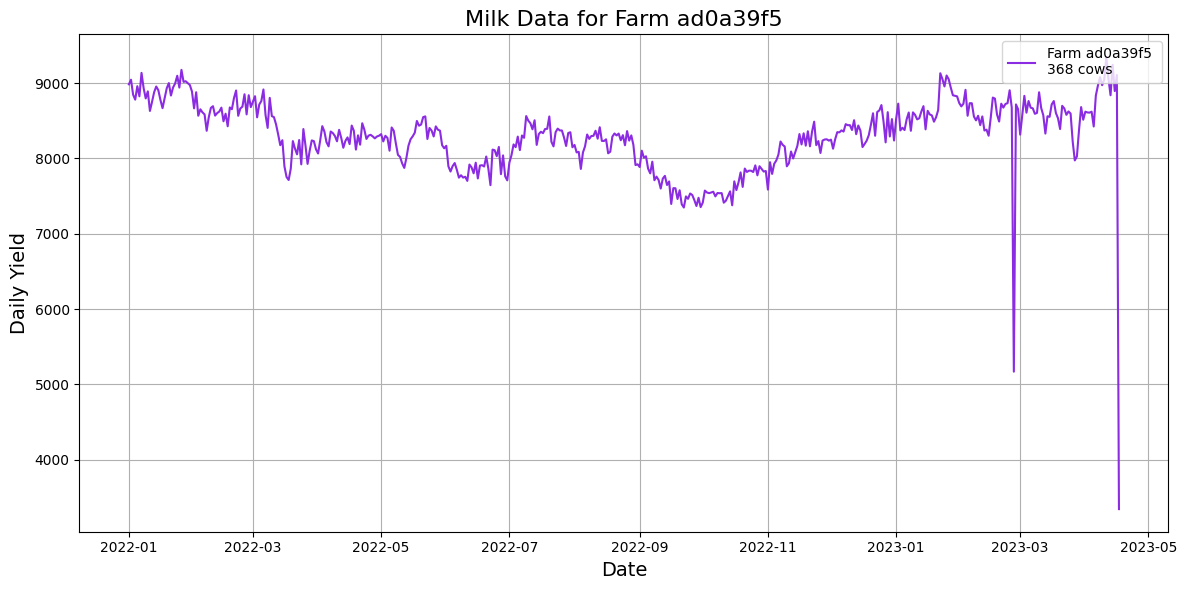

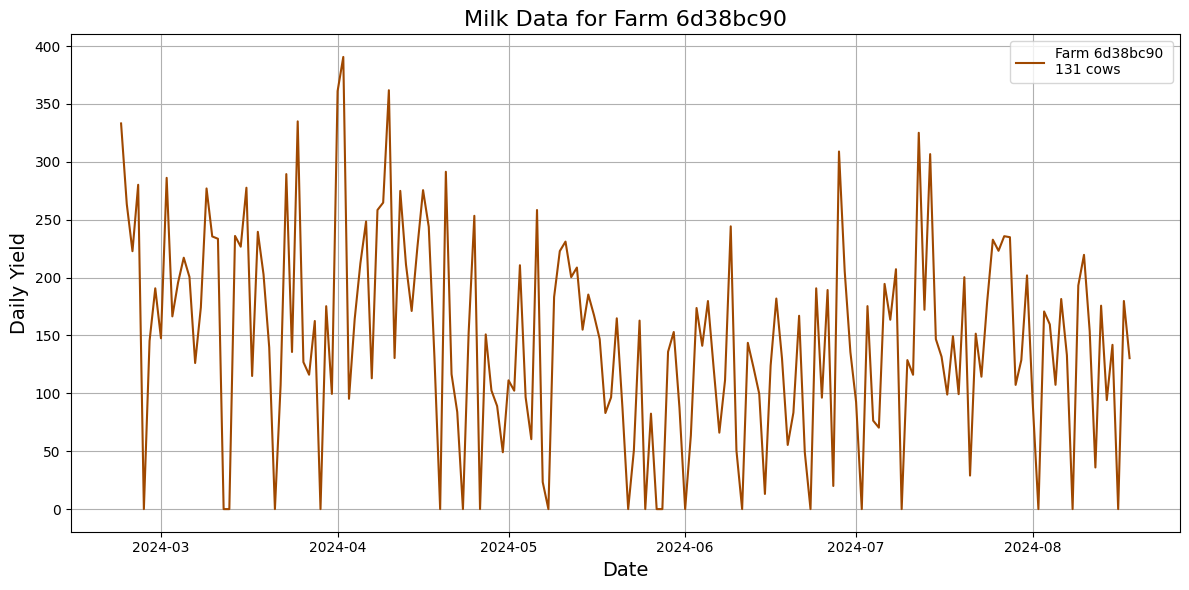

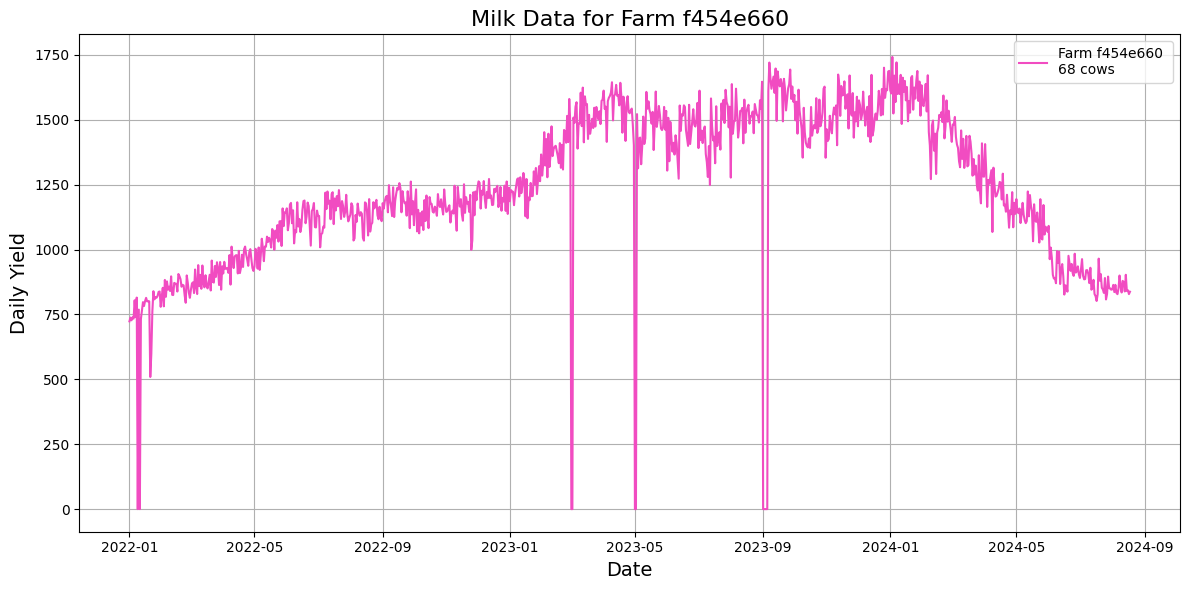

In [23]:
#
#
# PLOTTING TOTAL DAILY MILK YIELD BY HERD IN CRUDE DATA
# Load data
df_lact = pd.read_csv("../Data/CowData/MY.csv", low_memory=False)
df_lact = df_lact.drop_duplicates(subset=["SE_Number", "LactationNumber", "StartDate", "StartTime", "TotalYield"])

# Ensure the StartDate column is a datetime object
df_lact['StartDate'] = pd.to_datetime(df_lact['StartDate'])

# Keep only MY data from 2022-01-01 until 2024-08-18
cutoff_date1 = '2022-01-01'
cutoff_date2 = '2024-08-18'
df_lact = df_lact[df_lact['StartDate'] >= cutoff_date1]
df_lact = df_lact[df_lact['StartDate'] <= cutoff_date2]

# list of farms
list_of_farms = list(df_lact["FarmName_Pseudo"].unique())

# Dictionary to store farm color mapping
farm_color_mapping = {}

# Loop through each farm and create a separate plot for each
for i, farm in enumerate(list_of_farms):
    # Create a new figure for each farm
    plt.figure(figsize=(12, 6))

    selected_farm = df_lact[df_lact['FarmName_Pseudo'] == farm]
    number_of_cows = len(selected_farm['SE_Number'].unique())
    daily_yield = selected_farm.groupby('StartDate')['TotalYield'].sum()

    # Get color for this farm, ensuring enough colors
    color = sns.color_palette('bright', n_colors=max(len(list_of_farms), 10))[i]
    farm_color_mapping[farm] = color

    # Generate a complete date range and reindex the daily yield
    all_dates = pd.date_range(start=daily_yield.index.min(), end=daily_yield.index.max(), freq='D')
    daily_yield = daily_yield.reindex(all_dates, fill_value=0)

    # Plot data
    plt.plot(daily_yield.index, daily_yield.values, label=f'Farm {farm} \n{number_of_cows} cows', color=color)
    plt.title(f'Milk Data for Farm {farm}', fontsize=16)
    plt.ylabel('Daily Yield', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)

    # Set x-axis label
    plt.xlabel('Date', fontsize=14)

    # Show the plot
    plt.tight_layout()
    plt.show()


# ADD WEATHER DATA TO MY.CSV FILE
- uses weather data from AllPreProcessedWeatherData for each herd and MY.csv
- creates weather3.csv, and several MYn.csv to look at data with final dataset MY7.csv

In [52]:
dfm = pd.read_csv("../Data/CowData/MY.csv", low_memory=False)
missing_count = dfm['StartTime'].isna().sum()
print(f"Number of missing observations in 'StartTime': {missing_count}")
print(dfm.shape)

Number of missing observations in 'StartTime': 636351
(2299007, 12)


In [24]:
#
#
# PREPARATIONS FOR COMBINING MY AND WEATHER DATA
# Make next_calving
dfins6 = pd.read_csv("../Data/CowData/MY.csv", low_memory=False)
dfins7 = dfins6.drop_duplicates(subset=["SE_Number", "LactationNumber", "CalvingDate"])

col_keep = ["SE_Number", "CalvingDate", "LactationNumber"]
dfins7 = dfins7[col_keep]
dfins7["next_calving"] = dfins7.groupby(["SE_Number"])["CalvingDate"].shift(-1)
dfins7 = dfins6.merge(dfins7, on=["SE_Number", "LactationNumber", "CalvingDate"], how="left")

"""
Subset chosen cow
SE_Number = ["SE-064c0cec-1189"]
dfins7 = dfins7[dfins7["SE_Number"].isin(SE_Number)]
"""

# Add CullingDate to MY file
dfins8 = pd.read_csv("../Data/CowData/updateDF.csv", low_memory=False)
dfins8 = dfins8.drop_duplicates(subset=["SE_Number", "CullingDate"])
col_keep = ["SE_Number", "CullingDate"]
dfins8 = dfins8[col_keep]
dfins8 = dfins7.merge(dfins8, on=["SE_Number"], how="left")
dfins8.to_csv("../Data/CowData/MY3.csv", index=False)

col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "CalvingDate", "next_calving", "upper_limit", "StartDate"]
df = dfins8[col_keep]

"""
SE_Number = ["SE-064c0cec-1189"]
df = df[df["SE_Number"].isin(SE_Number)]
"""

# keep only one obs per date
df2 = df.sort_values(by=["SE_Number", "LactationNumber", "StartDate"])
df2 = df2.drop_duplicates(subset=["SE_Number", "LactationNumber", "StartDate"])

df2 = df2.copy()
df2["CalvingDate"] = pd.to_datetime(df2["CalvingDate"])
df2["upper_limit"] = pd.to_datetime(df2["upper_limit"])

# Make a date variable for weather data - DateMeterological
# Create a list to hold new data
new_data = []

# Loop through each row in the original DataFrame
for _, row in df2.iterrows():
    herd = row["FarmName_Pseudo"]
    cow = row['SE_Number']
    lactation = row['LactationNumber']
    next_calving = row["next_calving"]
    start_date = row['CalvingDate']
    end_date = row['upper_limit']

    # Generate a date range
    date_range = pd.date_range(start=start_date, end=end_date)

    # Create a new DataFrame for Cow, Lactation, and date range
    temp_df = pd.DataFrame({
        "FarmName_Pseudo": herd,
        'SE_Number': cow,
        'LactationNumber': lactation,
        "next_calving": next_calving,
        'DateMeterological': date_range
    })

    # Append the new DataFrame to the list
    new_data.append(temp_df)

# Concatenate all the new DataFrames into one
df_exp = pd.concat(new_data, ignore_index=True)
# df_exp.to_csv("../Data/CowData/MY4.csv", index=False)

# Remove duplicates
df_exp = df_exp.sort_values(by=["SE_Number", "LactationNumber", "DateMeterological"])
df_exp = df_exp.drop_duplicates(subset=["SE_Number", "LactationNumber", "next_calving", "DateMeterological"])

# only keep relevant data within calving interval
# Ensure both columns are in datetime format
df_exp["DateMeterological"] = pd.to_datetime(df_exp["DateMeterological"])
df_exp["next_calving"] = pd.to_datetime(df_exp["next_calving"])

# Set values in DateMeterological to NaN if they exceed the values in next_calving
df_exp.loc[df_exp["DateMeterological"] >= df_exp["next_calving"], "DateMeterological"] = np.nan
df_exp = df_exp.dropna(subset=['DateMeterological'])
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "DateMeterological"]
df_exp = df_exp[col_keep]
df_exp.to_csv("../Data/CowData/MY5.csv", index=False)

In [4]:
#
#
# COMBINE WEATHER DATA FROM HERDS
# Load Global irradiance, THI_adj etc.
# Only run this cell the first time you run program, otherwise multiple columns in dataframe
# weather1-15a were "AllWeatherData", creating weather.csv and weather2.csv
# however, "AllPreProcessedWeatherData" contains full data needed, creating only weather3.csv
weather1b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_4eab8365.csv", delimiter=',', low_memory=False)
weather1b['FarmName_Pseudo'] = '4eab8365'
weather1b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_4eab8365.csv", index=False)

weather2b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_5b581702.csv", delimiter=',', low_memory=False)
weather2b['FarmName_Pseudo'] = '5b581702'
weather2b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_5b581702.csv", index=False)

weather3b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_5c06d92d.csv", delimiter=',', low_memory=False)
weather3b['FarmName_Pseudo'] = '5c06d92d'
weather3b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_5c06d92d.csv", index=False)

weather4b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_5f7f33d6.csv", delimiter=',', low_memory=False)
weather4b['FarmName_Pseudo'] = '5f7f33d6'
weather4b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_5f7f33d6.csv", index=False)

weather5b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_80b99061.csv", delimiter=',', low_memory=False)
weather5b['FarmName_Pseudo'] = '80b99061'
weather5b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_80b99061.csv", index=False)

weather6b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_169e580a.csv", delimiter=',', low_memory=False)
weather6b['FarmName_Pseudo'] = '169e580a'
weather6b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_169e580a.csv", index=False)

weather7b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_752efd72.csv", delimiter=',', low_memory=False)
weather7b['FarmName_Pseudo'] = '752efd72'
weather7b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_752efd72.csv", index=False)

weather8b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_540275a1.csv", delimiter=',', low_memory=False)
weather8b['FarmName_Pseudo'] = '540275a1'
weather8b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_540275a1.csv", index=False)

weather9b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_a624fb9a.csv", delimiter=',', low_memory=False)
weather9b['FarmName_Pseudo'] = 'a624fb9a'
weather9b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_a624fb9a.csv", index=False)

weather10b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_a756bc39.csv", delimiter=',', low_memory=False)
weather10b['FarmName_Pseudo'] = 'a756bc39'
weather10b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_a756bc39.csv", index=False)

weather11b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_ab18b151.csv", delimiter=',', low_memory=False)
weather11b['FarmName_Pseudo'] = 'ab18b151'
weather11b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_ab18b151.csv", index=False)

weather12b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_ad0a39f5.csv", delimiter=',', low_memory=False)
weather12b['FarmName_Pseudo'] = 'ad0a39f5'
weather12b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_ad0a39f5.csv", index=False)

weather13b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_afdd9a78.csv", delimiter=',', low_memory=False)
weather13b['FarmName_Pseudo'] = 'afdd9a78'
weather13b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_afdd9a78.csv", index=False)

weather14b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_f454e660.csv", delimiter=',', low_memory=False)
weather14b['FarmName_Pseudo'] = 'f454e660'
weather14b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_f454e660.csv", index=False)

weather15b = pd.read_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_fced84e9.csv", delimiter=',', low_memory=False)
weather15b['FarmName_Pseudo'] = 'fced84e9'
weather15b.to_csv("../Data/WeatherData/AllPreProcessedWeatherData/processed_data_fced84e9.csv", index=False)

# Get a list of all CSV files in the directory (adjust path as needed)
all_files = glob.glob("../Data/WeatherData/AllPreProcessedWeatherData/*.csv")

# Initialize an empty list to store DataFrames
dfs = []

# Loop through the list of files and read them into DataFrames
for file in all_files:
    df = pd.read_csv(file)
    dfs.append(df)

# Concatenate all DataFrames into one
mdf2 = pd.concat(dfs, ignore_index=True)
mdf2.to_csv("../Data/WeatherData/weather3.csv", index=False)

In [25]:
# CHECK WEATHER DATA
daily = pd.read_csv("../Data/WeatherData/weather3.csv", low_memory=False)
daily.drop_duplicates(subset=["FarmName_Pseudo", "Tid"])

missing_count = daily["THI_adj"].isna().sum()
print(f"Number of missing values in 'THI_adj': {missing_count}")
print(daily.shape)

Number of missing values in 'THI_adj': 0
(345615, 22)


In [47]:
test = pd.read_csv("../Data/CowData/MY5c.csv", low_memory=False)
SE_Number = ["SE-5c06d92d-2055"]
test = test[test["SE_Number"].isin(SE_Number)]
test.to_csv("../Data/CowData/testcow.csv", index=False)

# DEVELOP CODE TO HAVE MEAN MESAN DATA FOR MILKING EVENTS WITH MISSING TIME

In [107]:
# START WITH MILKING EVENTS THAT HAVE TIME STAMPS
#
#
# COMBINE MY.csv and weather3.csv
# Add time to MY file
MY = pd.read_csv("../Data/CowData/MY5.csv", low_memory=False)
MY.drop_duplicates(subset=["FarmName_Pseudo", "SE_Number", "LactationNumber", "DateMeterological"])
print(MY.shape)  # 1,138,791

MY['DateMeterological'] = pd.to_datetime(MY['DateMeterological'])
MY.rename(columns={"DateMeterological": "StartDate"}, inplace=True)

MY3 = pd.read_csv("../Data/CowData/MY3.csv", low_memory=False)
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "StartDate", "StartTime"]
MY3 = MY3[col_keep]
MY3['StartDate'] = pd.to_datetime(MY3['StartDate'])
dfm = MY.merge(MY3, on=["FarmName_Pseudo", "SE_Number", "LactationNumber", "StartDate"], how="left")

# Step 1: Convert 'StartTime' column to pandas datetime, allowing NaT for missing values
dfm['StartTime'] = pd.to_datetime(dfm['StartTime'], format='%H:%M:%S', errors='coerce')

# Step 2: Round time to the nearest hour
dfm['RoundedTime'] = dfm['StartTime'].dt.round('h')

# Step 4: Extract the hour from the RoundedTime column
dfm['Hour'] = dfm['RoundedTime'].dt.hour
# Extract the time part from the 'DateTime' column
dfm['TimeOnly'] = dfm['StartTime'].dt.time
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "StartDate", "TimeOnly", "Hour"]
dfm = dfm[col_keep]
dfm.rename(columns={"TimeOnly": "StartTime"}, inplace=True)

"""
# example cow with missing time stamps
SE_Number = ["SE-064c0cec-1189"]
dfm = dfm[dfm["SE_Number"].isin(SE_Number)]
"""

# Mark milking events without time stamps = 1
dfm["tag"] = dfm["StartTime"].isna().astype(int)

dfm.to_csv("../Data/CowData/MYtest.csv", index=False)

(1138791, 4)


In [108]:
# Weather file
daily = pd.read_csv("../Data/WeatherData/weather3.csv", low_memory=False)
daily.drop_duplicates(subset=["FarmName_Pseudo", "Tid"])

# Make Hour in weather dataset
daily['Tid'] = pd.to_datetime(daily['Tid'])
daily['Hour'] = daily['Tid'].dt.hour
daily.to_csv("../Data/CowData/MY5b.csv", index=False)

daily['StartDate'] = pd.to_datetime(daily['StartDate'])
dfm['StartDate'] = pd.to_datetime(dfm['StartDate'])

# Merge MY with weather data by FarmName, Date, and Hour
dfm = dfm.merge(daily, on=['FarmName_Pseudo', 'StartDate', 'Hour'], how='outer')  # ======================================================================>>> left?
dfm = dfm.sort_values(by=["FarmName_Pseudo", "SE_Number", "LactationNumber", "StartDate", "StartTime"])
dfm = dfm.drop_duplicates(subset=["SE_Number", "LactationNumber", "StartDate", "StartTime"])

"""
# SE_Number = ["SE-064c0cec-1189"]
SE_Number = ["SE-27c3257a-1492"]
dfm = dfm[dfm["SE_Number"].isin(SE_Number)]
"""

col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "StartDate", "StartTime", "Hour",
            "Temperatur", "Relativ fuktighet", "Vindhastighet", "Vindriktning", "Byvind", "Nederbörd", "Snö",
            "Nederbördstyp", "Molnighet", "Sikt", "Lufttryck", "Global irradiance", "THI_adj", "HW", "cum_HW",
            "Temp15Threshold"]
dfm = dfm[col_keep]

dfm.rename(columns={"Temperatur": "Temperature", "Relativ fuktighet": "RelativeHumidity",
                    "Vindhastighet": "WindSpeed", "Vindriktning": "WindDirection",
                    "Byvind": "Crosswind", "Nederbörd": "Precipitation", "Snö": "Snow",
                    "Nederbördstyp": "PrecipitationType", "Molnighet": "Cloudiness",
                    "Sikt": "Visibility", "Lufttryck": "AirPressure",
                    "Global irradiance": "GlobalIrradiance"}, inplace=True)

dfm.to_csv("../Data/CowData/MY5c_test.csv", index=False)

In [126]:
# Calc Means for days with missing time for milking and for dry off
# Weather file
daily = pd.read_csv("../Data/WeatherData/weather3.csv", low_memory=False)
daily = daily.drop_duplicates(subset=["FarmName_Pseudo", "Tid"])  # Assign the result back

col_keep = ["FarmName_Pseudo", "StartDate", "Tid", "Temperatur", "Relativ fuktighet", "Vindhastighet", "Vindriktning", "Byvind", "Nederbörd", "Snö",
            "Nederbördstyp", "Molnighet", "Sikt", "Lufttryck", "Global irradiance", "THI_adj", "HW", "cum_HW", "Temp15Threshold"]
daily = daily[col_keep]

# Calculate mean THI per day
daily['StartDate'] = pd.to_datetime(daily['StartDate'])
daily = daily.groupby(['FarmName_Pseudo', 'StartDate'], as_index=False)[["Temperatur", "Relativ fuktighet", "Vindhastighet", "Nederbörd", "Global irradiance", 
                                                                         'THI_adj', "HW", "cum_HW", "Temp15Threshold"]].mean()

daily.rename(columns={"Temperatur": "MeanTemperature", 
                      "Relativ fuktighet": "MeanRelativeHumidity",
                      "Vindhastighet": "MeanWindSpeed", 
                      "Nederbörd": "MeanPrecipitation", 
                      "Global irradiance": "MeanGlobalIrradiance",
                      "THI_adj": "MeanTHI_adj",
                      "HW": "MeanHW",
                      "cum_HW": "Meancum_HW",
                      "Temp15Threshold": "MeanTemp15Threshold"}, inplace=True)

"""
# Filter by herd
herd = ["a624fb9a"]
daily = daily[daily["FarmName_Pseudo"].isin(herd)]
"""
daily.to_csv("../Data/WeatherData/weather_test.csv", index=False)


In [136]:
# Merge weather_test.csv with MY5c_test.csv
dfm = pd.read_csv("../Data/CowData/MY5c_test.csv", low_memory=False)
daily = pd.read_csv("../Data/WeatherData/weather_test.csv", low_memory=False)
dfm = dfm.merge(daily, on=['FarmName_Pseudo', 'StartDate'], how='outer')
"""
SE_Number = ["SE-27c3257a-1492"]
dfm = dfm[dfm["SE_Number"].isin(SE_Number)]
"""
dfm.to_csv("../Data/CowData/MY5d_test.csv", index=False)
print(dfm.shape)

(1950635, 31)


In [140]:
# Merge onto MY dataframe
df = pd.read_csv("../Data/CowData/MY5d_test.csv", low_memory=False)
my = pd.read_csv("../Data/CowData/MY3.csv", low_memory=False)
"""
SE_Number = ["SE-27c3257a-1492"]
my = my[my["SE_Number"].isin(SE_Number)]
"""
dfm = pd.merge(my, df, on=["FarmName_Pseudo", "SE_Number", "LactationNumber", "StartDate", "StartTime"], how="outer")

dfm = dfm.dropna(subset=['SE_Number'])
dfm.to_csv("../Data/CowData/MY7.csv", index=False)

missing_count = dfm['THI_adj'].isna().sum()
print(f"Number of missing observations in 'THI_adj': {missing_count}")
missing_count = dfm['MeanTHI_adj'].isna().sum()
print(f"Number of missing observations in 'MeanTHI_adj': {missing_count}")
print(dfm.shape)

Number of missing observations in 'THI_adj': 1722502
Number of missing observations in 'MeanTHI_adj': 867194
(2788891, 40)


In [26]:
"""
# ORIGINAL CELL
#
#
# COMBINE MY.csv and weather3.csv
# Add time stamps
# Weather file
daily = pd.read_csv("../Data/WeatherData/weather3.csv", low_memory=False)
daily.drop_duplicates(subset=["FarmName_Pseudo", "Tid"])

# Add time to MY file
MY = pd.read_csv("../Data/CowData/MY5.csv", low_memory=False)
MY.drop_duplicates(subset=["FarmName_Pseudo", "SE_Number", "LactationNumber", "DateMeterological"])
print(MY.shape)  # 1,138,153

daily['Tid'] = pd.to_datetime(daily['Tid'])
MY['DateMeterological'] = pd.to_datetime(MY['DateMeterological'])
MY.rename(columns={"DateMeterological": "StartDate"}, inplace=True)

MY3 = pd.read_csv("../Data/CowData/MY3.csv", low_memory=False)
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "StartDate", "StartTime"]
MY3 = MY3[col_keep]
MY3['StartDate'] = pd.to_datetime(MY3['StartDate'])
dfm = MY.merge(MY3, on=["FarmName_Pseudo", "SE_Number", "LactationNumber", "StartDate"], how="left")

# Step 1: Convert 'StartTime' column to pandas datetime, allowing NaT for missing values
dfm['StartTime'] = pd.to_datetime(dfm['StartTime'], format='%H:%M:%S', errors='coerce')

# Step 2: Round time to the nearest hour
dfm['RoundedTime'] = dfm['StartTime'].dt.round('h')

# Step 3: Fill missing values (NaT) with '00:00:00'
# Since 'RoundedTime' is a datetime column, use '00:00:00' as a time
dfm['RoundedTime'] = dfm['RoundedTime'].fillna(pd.Timestamp('00:00:00'))

# Step 4: Extract the hour from the RoundedTime column
dfm['Hour'] = dfm['RoundedTime'].dt.hour
# Extract the time part from the 'DateTime' column
dfm['StartTime'] = dfm['StartTime'].fillna('00:00:00')
dfm['TimeOnly'] = dfm['StartTime'].dt.time

# Save
col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "StartDate", "TimeOnly", "Hour"]
dfm = dfm[col_keep]
dfm.rename(columns={"TimeOnly": "StartTime"}, inplace=True)
dfm.to_csv("../Data/CowData/MY5a.csv", index=False)

# Make Hour in weather dataset
daily['Hour'] = daily['Tid'].dt.hour
daily.to_csv("../Data/CowData/MY5b.csv", index=False)

daily['StartDate'] = pd.to_datetime(daily['StartDate'])
dfm['StartDate'] = pd.to_datetime(dfm['StartDate'])

# Merge MY with weather data FarmName, Date, and Hour
dfm = dfm.merge(daily, on=['FarmName_Pseudo', 'StartDate', 'Hour'], how='outer')  # ======================================================================>>> left?
dfm = dfm.sort_values(by=["FarmName_Pseudo", "SE_Number", "LactationNumber", "StartDate", "StartTime"])
dfm = dfm.drop_duplicates(subset=["SE_Number", "LactationNumber", "StartDate", "StartTime"])

col_keep = ["FarmName_Pseudo", "SE_Number", "LactationNumber", "StartDate", "StartTime", "Hour",
            "Temperatur", "Relativ fuktighet", "Vindhastighet", "Vindriktning", "Byvind", "Nederbörd", "Snö",
            "Nederbördstyp", "Molnighet", "Sikt", "Lufttryck", "Global irradiance", "THI_adj", "HW", "cum_HW",
            "Temp15Threshold"]
dfm = dfm[col_keep]

dfm.rename(columns={"Temperatur": "Temperature", "Relativ fuktighet": "RelativeHumidity",
                    "Vindhastighet": "WindSpeed", "Vindriktning": "WindDirection",
                    "Byvind": "Crosswind", "Nederbörd": "Precipitation", "Snö": "Snow",
                    "Nederbördstyp": "PrecipitationType", "Molnighet": "Cloudiness",
                    "Sikt": "Visibility", "Lufttryck": "AirPressure",
                    "Global irradiance": "GlobalIrradiance"}, inplace=True)

dfm.to_csv("../Data/CowData/MY5c.csv", index=False)

missing_count = dfm['THI_adj'].isna().sum()
print(f"Number of missing observations in 'THI_adj': {missing_count}")  # 710,823 ========================================>>> ie have MY data before 2022-01-01 and after 2024-08-18
print(dfm.shape)  # 1,942,947
"""

(1138791, 4)
Number of missing observations in 'THI_adj': 710823
(1942947, 22)


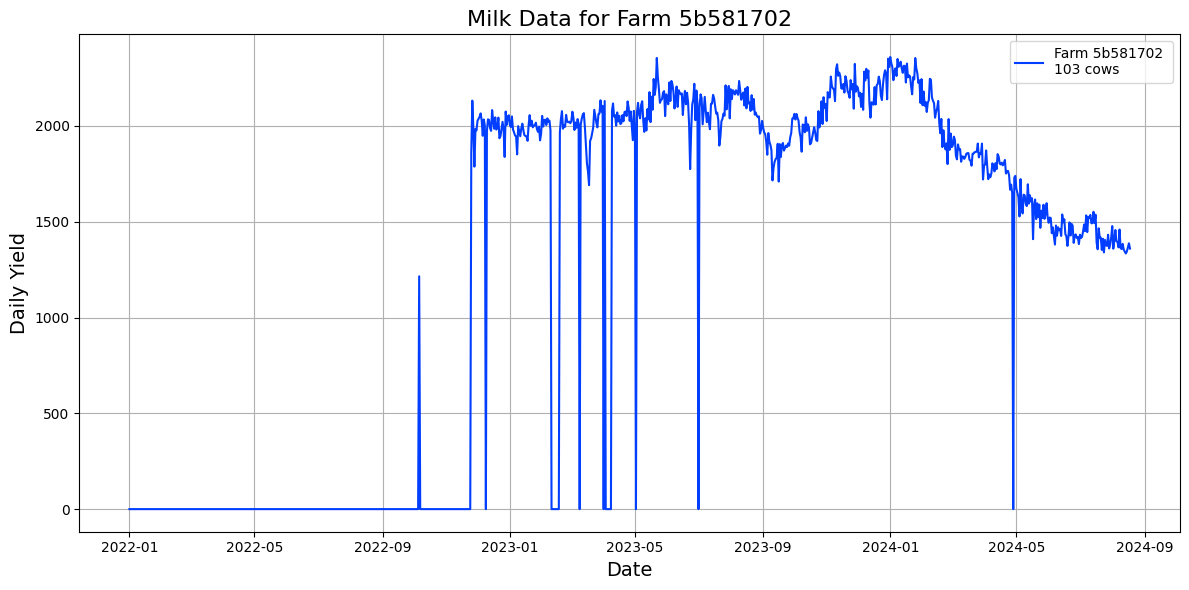

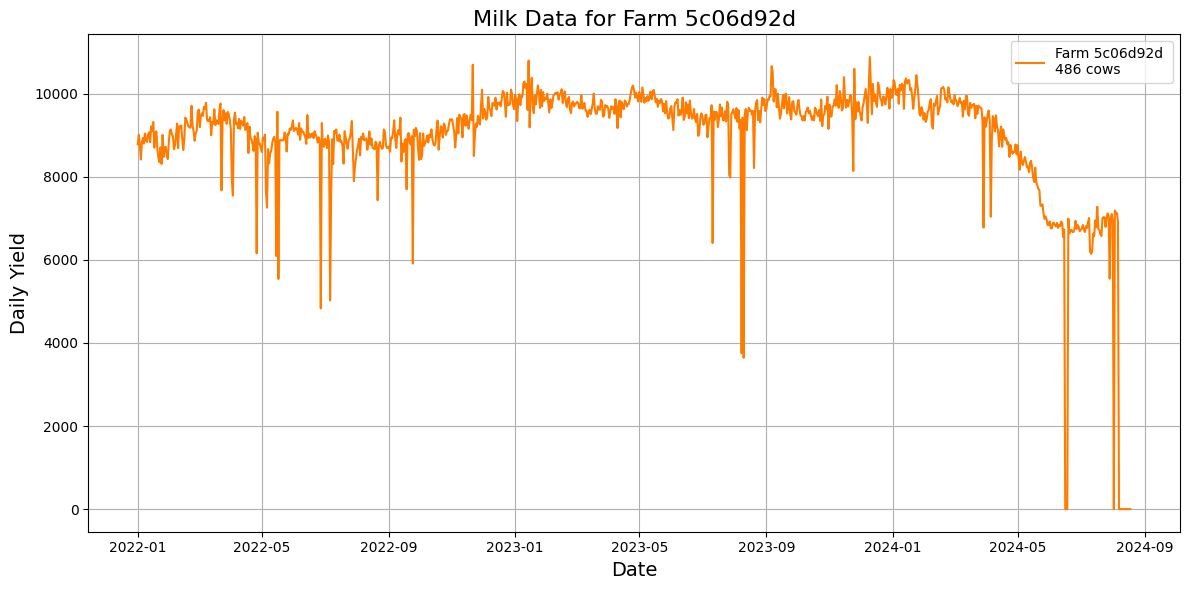

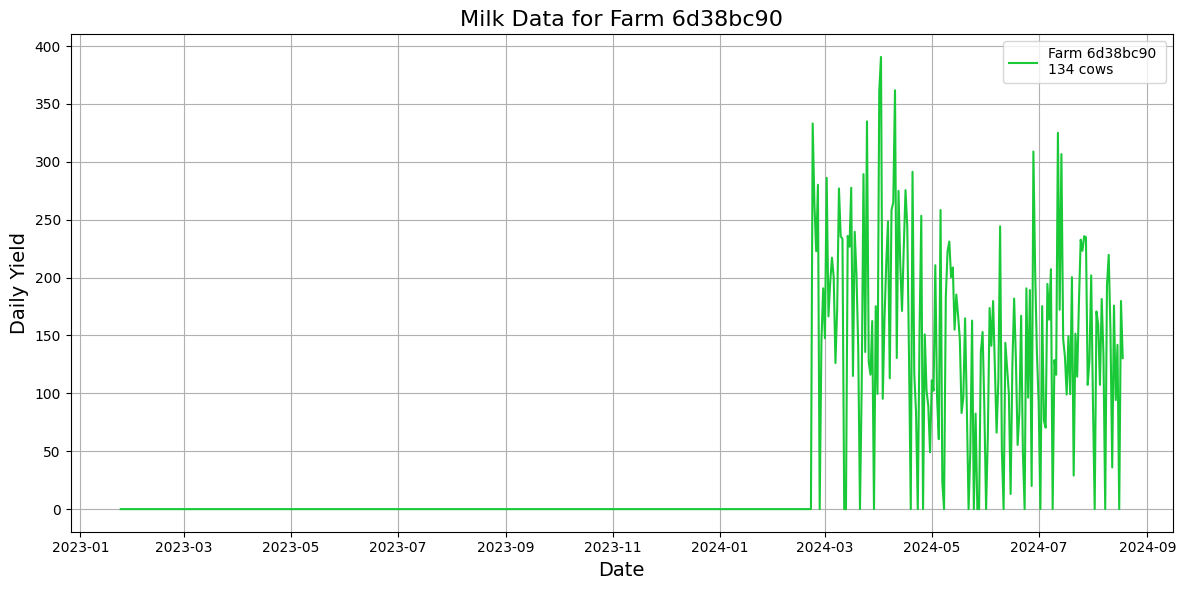

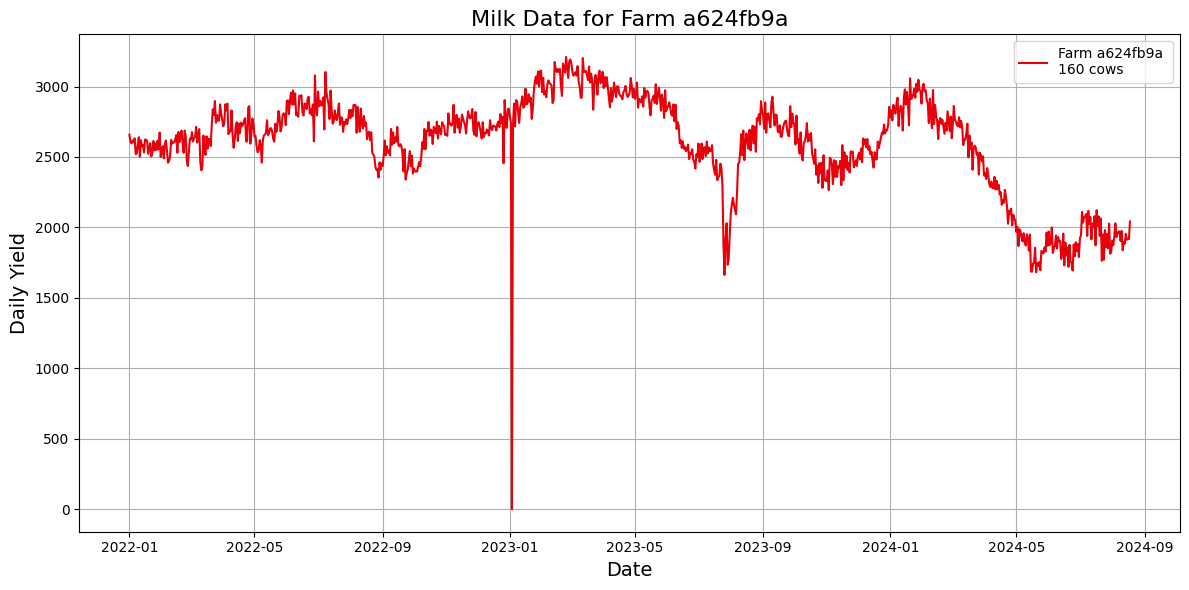

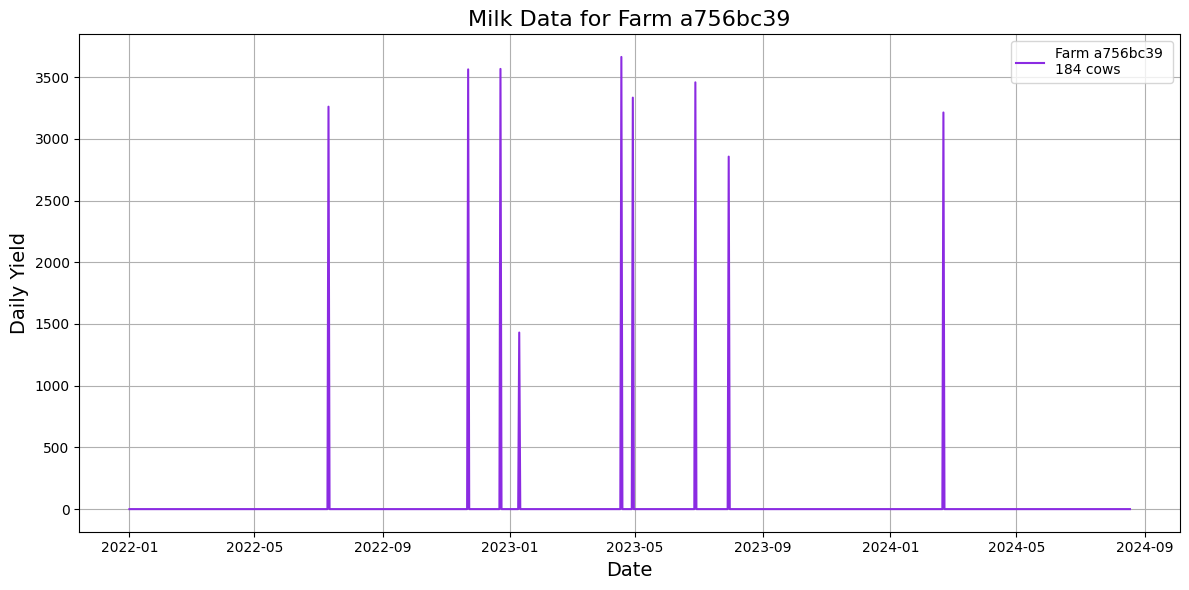

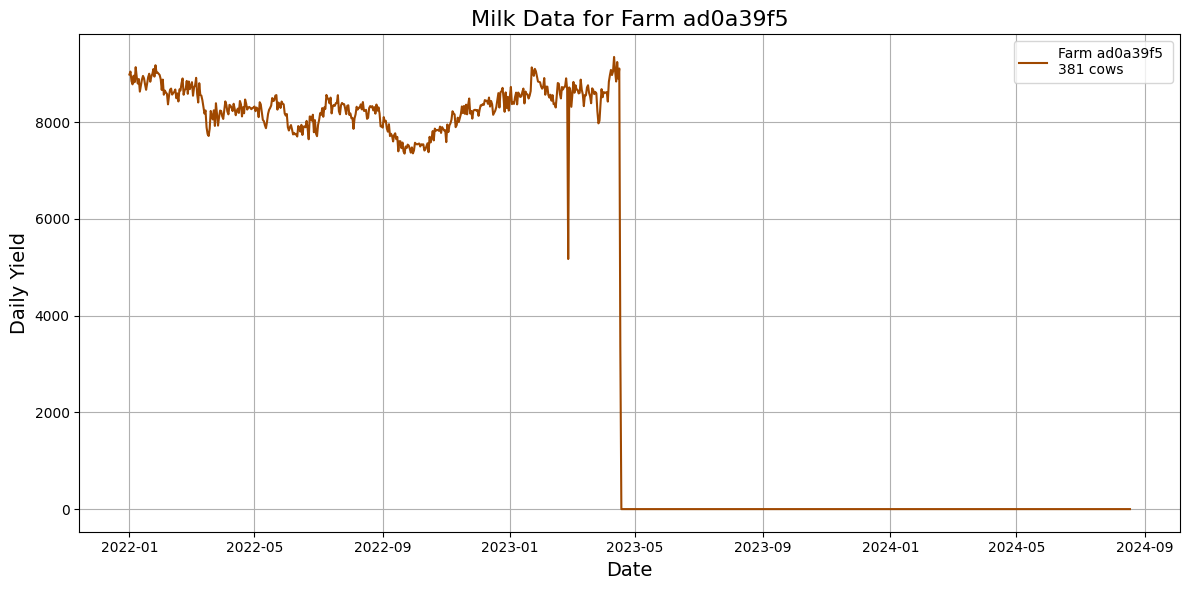

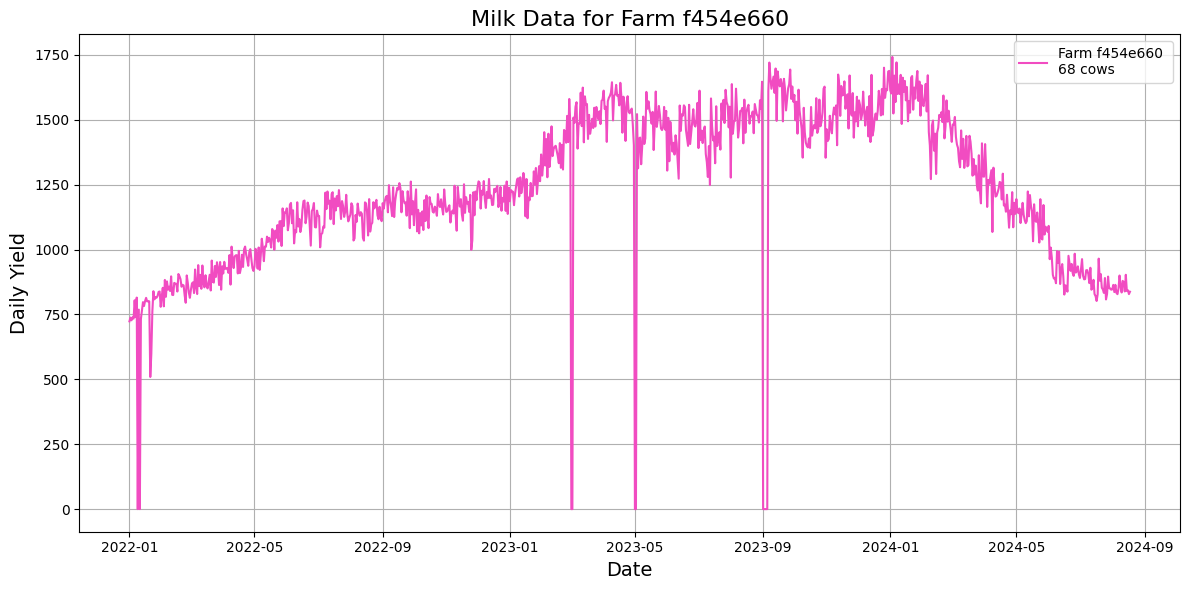

In [141]:
#
#
# PLOTTING TOTAL DAILY MILK YIELD BY HERD IN CRUDE DATA
# Load data
df_lact = pd.read_csv("../Data/CowData/MY7.csv", low_memory=False)
df_lact = df_lact.drop_duplicates(subset=["SE_Number", "LactationNumber", "StartDate", "StartTime", "TotalYield"])

# Ensure the StartDate column is a datetime object
df_lact['StartDate'] = pd.to_datetime(df_lact['StartDate'])

# Keep only MY data from 2022-01-01 until 2024-08-18
cutoff_date1 = '2022-01-01'
cutoff_date2 = '2024-08-18'
df_lact = df_lact[df_lact['StartDate'] >= cutoff_date1]
df_lact = df_lact[df_lact['StartDate'] <= cutoff_date2]

# list of farms
list_of_farms = list(df_lact["FarmName_Pseudo"].unique())

# Dictionary to store farm color mapping
farm_color_mapping = {}

# Loop through each farm and create a separate plot for each
for i, farm in enumerate(list_of_farms):
    # Create a new figure for each farm
    plt.figure(figsize=(12, 6))

    selected_farm = df_lact[df_lact['FarmName_Pseudo'] == farm]
    number_of_cows = len(selected_farm['SE_Number'].unique())
    daily_yield = selected_farm.groupby('StartDate')['TotalYield'].sum()

    # Get color for this farm, ensuring enough colors
    color = sns.color_palette('bright', n_colors=max(len(list_of_farms), 10))[i]
    farm_color_mapping[farm] = color

    # Generate a complete date range and reindex the daily yield
    all_dates = pd.date_range(start=daily_yield.index.min(), end=daily_yield.index.max(), freq='D')
    daily_yield = daily_yield.reindex(all_dates, fill_value=0)

    # Plot data
    plt.plot(daily_yield.index, daily_yield.values, label=f'Farm {farm} \n{number_of_cows} cows', color=color)
    plt.title(f'Milk Data for Farm {farm}', fontsize=16)
    plt.ylabel('Daily Yield', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)

    # Set x-axis label
    plt.xlabel('Date', fontsize=14)

    # Show the plot
    plt.tight_layout()
    plt.show()


# ADD MILKING PARAMETERS FROM VMS HERDS
- adding Del_Milk_Robot to MY7.csv thus creating MY_weather.csv

In [144]:
#
#
# ADD MILKING PARAMETERS FROM VMS
SCC = pd.read_csv("../Data/CowData/Del_Milk_Robot240918.csv", delimiter=';', low_memory=False)
print(f"No. of milking events in database: {SCC.shape}")  
SCC = SCC.drop_duplicates(subset=["SE_Number", "MilkingStartDateTime"])
print(f"No. of unique milking events in database: {SCC.shape}")  

""" 
# Check how many observations are missing timestamp
invalid_rows = SCC[pd.to_datetime(SCC['MilkingStartDateTime'], errors='coerce').isna()]
print(invalid_rows)
invalid_rows.to_csv("./Data/CowData/updateDF2.csv", index=False)  # 1574 obs
"""

SCC['MilkingStartDateTime'] = pd.to_datetime(SCC['MilkingStartDateTime'], errors='coerce')
# Identify rows where the time is missing or set to '00:00:00'
missing_time_rows = SCC[SCC['MilkingStartDateTime'].dt.time == pd.to_datetime('00:00:00').time()]

# Add a time of '00:00:00' to these rows (since they're already '00:00:00', no changes needed)
# Just for clarity, we reset the time to '00:00:00'
missing_time_rows['MilkingStartDateTime'] = missing_time_rows['MilkingStartDateTime'].apply(
    lambda x: x.replace(hour=0, minute=0, second=0)
)

# Merge the updated rows back onto the original DataFrame
# First, remove these rows from the original DataFrame
SCC_no_missing = SCC[SCC['MilkingStartDateTime'].dt.time != pd.to_datetime('00:00:00').time()]

# Concatenate the original DataFrame (without missing times) and the updated rows
SCC_updated = pd.concat([SCC_no_missing, missing_time_rows], ignore_index=True)
SCC_updated.to_csv("../Data/CowData/Updated_VMS.csv", index=False)

# Split into separate date and time columns
SCC_updated['MilkingStartDateTime'] = pd.to_datetime(SCC_updated['MilkingStartDateTime'])
SCC_updated['StartDate'] = SCC_updated['MilkingStartDateTime'].dt.date    # Extract the date part
SCC_updated['StartTime'] = SCC_updated['MilkingStartDateTime'].dt.time    # Extract the time part
SCC_updated['StartDate'] = pd.to_datetime(SCC_updated['StartDate'])
SCC_updated['StartTime'] = pd.to_datetime(SCC_updated['StartTime'], format='%H:%M:%S').dt.time

# Keep only MY data until 2024-08-18
cutoff_date = '2024-08-18'
SCC_updated = SCC_updated[SCC_updated['StartDate'] <= cutoff_date]
print(f"No. of unique milking events in database: {SCC_updated.shape}")  

col_keep = ["FarmName_Pseudo", "SE_Number", "StartDate", "StartTime",
            "TotalYieldLF", "TotalYieldRF", "TotalYieldLR", "TotalYieldRR",
            "KickOffLF", "KickOffLR", "KickOffRF", "KickOffRR",
            "IncompleteLF", "IncompleteLR", "IncompleteRF", "IncompleteRR",
            "NotMilkedTeatLF", "NotMilkedTeatLR", "NotMilkedTeatRF", "NotMilkedTeatRR",
            "AverageFlowLF", "AverageFlowLR", "AverageFlowRF", "AverageFlowRR",
            "PeakFlowLF", "PeakFlowLR", "PeakFlowRF", "PeakFlowRR",
            "BloodLF", "BloodLR", "BloodRF", "BloodRR",
            "ConductivityLF", "ConductivityLR", "ConductivityRF", "ConductivityRR",
            "Occ"]
SCC_updated = SCC_updated[col_keep]

df2 = pd.read_csv("../Data/CowData/MY7.csv", low_memory=False)
print(f"No. of unique milking events in MY7: {df2.shape}")  # 3,010,775

df2['StartDate'] = pd.to_datetime(df2['StartDate'])
df2['StartTime'] = pd.to_datetime(df2['StartTime'], format='%H:%M:%S').dt.time
SCC2 = df2.merge(SCC_updated, on=["FarmName_Pseudo", "SE_Number", "StartDate", "StartTime"], how="left")  # changed from outer

"""
# How dos this data look?
frequency_table = SCC2['KickOffLF'].value_counts()
print(frequency_table)
frequency_table = SCC2['IncompleteLF'].value_counts()
print(frequency_table)
frequency_table = SCC2['NotMilkedTeatLF'].value_counts()
print(frequency_table)
"""

# List of columns where you want to replace commas with dots
columns_to_modify = ["TotalYieldLF", "TotalYieldRF", "TotalYieldLR", "TotalYieldRR",
                     "AverageFlowLF", "AverageFlowLR", "AverageFlowRF", "AverageFlowRR",
                     "PeakFlowLF", "PeakFlowLR", "PeakFlowRF", "PeakFlowRR",
                     "BloodLF", "BloodLR", "BloodRF", "BloodRR",
                     "ConductivityLF", "ConductivityLR", "ConductivityRF", "ConductivityRR",
                     "Occ"]

# Replace comma with dot and convert to float
SCC2[columns_to_modify] = SCC2[columns_to_modify].replace(',', '.', regex=True).astype(float)
SCC2.to_csv("../Data/CowData/MY8.csv", index=False)


# Change order of columns
new_column_order = ["FarmName_Pseudo", "SE_Number", "AnimalNumber", "Del_Cow_Id", "CalvingDate", "LactationNumber", "upper_limit",
                    "DaysInMilk", "StartDate", "StartTime", "SessionNumber", "TotalYield",
                    "TotalYieldLF", "TotalYieldRF", "TotalYieldLR", "TotalYieldRR",
                    "AverageFlowLF", "AverageFlowLR", "AverageFlowRF", "AverageFlowRR",
                    "PeakFlowLF", "PeakFlowLR", "PeakFlowRF", "PeakFlowRR",
                    "BloodLF", "BloodLR", "BloodRF", "BloodRR",
                    "ConductivityLF", "ConductivityLR", "ConductivityRF", "ConductivityRR",
                    "Occ",
                    "Temperature", "RelativeHumidity", "WindSpeed", "WindDirection", "Crosswind", "Precipitation",
                    "Snow", "PrecipitationType", "Cloudiness", "Visibility", "AirPressure", "GlobalIrradiance",
                    "THI_adj", "HW", "cum_HW", "Temp15Threshold", 
                    "MeanTemperature", "MeanRelativeHumidity", "MeanWindSpeed", "MeanPrecipitation", "MeanGlobalIrradiance", "MeanTHI_adj", "MeanHW", "Meancum_HW", "MeanTemp15Threshold"]
SCC2 = SCC2[new_column_order]
SCC2.to_csv("../Data/CowData/MY8.csv", index=False)

"""
# Not saving, add above if want them later: 
KickOffLF,KickOffLR,KickOffRF,KickOffRR,
IncompleteLF,IncompleteLR,IncompleteRF,IncompleteRR,
NotMilkedTeatLF,NotMilkedTeatLR,NotMilkedTeatRF,NotMilkedTeatRR,
"""

No. of milking events in database: (2253923, 56)
No. of unique milking events in database: (2244467, 56)
No. of unique milking events in database: (2218022, 58)
No. of unique milking events in MY7: (2788891, 40)


'\n# Not saving, add above if want them later: \nKickOffLF,KickOffLR,KickOffRF,KickOffRR,\nIncompleteLF,IncompleteLR,IncompleteRF,IncompleteRR,\nNotMilkedTeatLF,NotMilkedTeatLR,NotMilkedTeatRF,NotMilkedTeatRR,\n'

In [146]:
missing_count = SCC2['THI_adj'].isna().sum()
print(f"Number of missing observations in 'THI_adj': {missing_count}")
missing_count = SCC2['MeanTHI_adj'].isna().sum()
print(f"Number of missing observations in 'MeanTHI_adj': {missing_count}")
print(SCC2.shape) 

Number of missing observations in 'THI_adj': 1722502
Number of missing observations in 'MeanTHI_adj': 867194
(2788891, 58)


# MISCELLANEOUS MINOR EDITS
- Add full ID-numbers from DelPro
- Retransfer breed
- Double check for duplicates in MY 
- Make next_calving
- Make next_ins and prev_ins
- Reload upper_limit

Creates the following datasets:
- updateDF.csv: containing data for cows for future use in HeatStress project
- MY_weather.csv: containing MY and weather data for future use in HeatStress project
- dfForSreten.csv: containing data for cows for delivery to Sreten Andonov
- MY_weatherForSreten.csv: containing MY and weather data for delivery to Sreten Andonov

In [2]:
# Add final ID-numbers from DelPro to all observations
df = pd.read_csv("../Data/CowData/Del_CowMilkYield_Common240823.csv", delimiter=';', low_memory=False)
col_keep = ["SE_Number", "AnimalNumber", "Del_Cow_Id"]
df = df[col_keep]
df = df.drop_duplicates(subset=["SE_Number", "AnimalNumber", "Del_Cow_Id"])

my = pd.read_csv("../Data/CowData/MY8.csv", low_memory=False)
my = my.drop(columns=["AnimalNumber", "Del_Cow_Id"])
mdf = pd.merge(my, df, on=["SE_Number"], how="left")
new_column_order = ["FarmName_Pseudo", "SE_Number", "AnimalNumber", "Del_Cow_Id", "CalvingDate", "LactationNumber",
                    "upper_limit", "DaysInMilk", "StartDate", "StartTime", "SessionNumber", "TotalYield",
                    "TotalYieldLF", "TotalYieldRF", "TotalYieldLR", "TotalYieldRR",
                    "AverageFlowLF", "AverageFlowLR", "AverageFlowRF", "AverageFlowRR",
                    "PeakFlowLF", "PeakFlowLR", "PeakFlowRF", "PeakFlowRR",
                    "BloodLF", "BloodLR", "BloodRF", "BloodRR",
                    "ConductivityLF", "ConductivityLR", "ConductivityRF", "ConductivityRR",
                    "Occ",
                    "Temperature", "RelativeHumidity", "WindSpeed", "WindDirection", "Crosswind", "Precipitation",
                    "Snow", "PrecipitationType", "Cloudiness", "Visibility", "AirPressure", "GlobalIrradiance",
                    "THI_adj", "HW", "cum_HW", "Temp15Threshold",
                    "MeanTemperature", "MeanRelativeHumidity", "MeanWindSpeed", "MeanPrecipitation", "MeanGlobalIrradiance",
                    "MeanTHI_adj", "MeanHW", "Meancum_HW", "MeanTemp15Threshold"]
mdf = mdf[new_column_order]
mdf.to_csv("../Data/CowData/MY_weather.csv", index=False)

In [3]:
#
#
# Add final ID-numbers from DelPro to all observations
df = pd.read_csv("../Data/CowData/Del_CowMilkYield_Common240823.csv", delimiter=';', low_memory=False)
col_keep = ["SE_Number", "AnimalNumber", "Del_Cow_Id"]
df = df[col_keep]
df = df.drop_duplicates(subset=["SE_Number", "AnimalNumber", "Del_Cow_Id"])

my = pd.read_csv("../Data/CowData/updateDF.csv", low_memory=False)
my = my.drop(columns=["AnimalNumber", "Del_Cow_Id"])
mdf = pd.merge(my, df, on=["SE_Number"], how="left")
new_column_order = ["FarmName_Pseudo", "SE_Number", "AnimalNumber", "Del_Cow_Id", "Breed", "BirthDate",
                    "Father_SE_Number", "Mother_SE_Number", "CalvingDate", "LactationNumber",
                    "InseminationDate", "PregnancyCheckDate", "PregnancyStatus", "DryOffDate", "CullingDate",
                    "ExitReason_PrimaryReasonKok", "ExitReason_SecondaryReason1Kok", "ExitReason_SecondaryReason2Kok",
                    "CullingReason1", "CullingReason2"]
mdf = mdf[new_column_order]

missing_count = mdf["AnimalNumber"].isna().sum()
print(f"Number of missing values in 'AnimalNumber': {missing_count}")  # 28,406 ie have data in dataframe but not from DelPro

mdf.to_csv("../Data/CowData/updateDF.csv", index=False)

Number of missing values in 'AnimalNumber': 28406


In [4]:
# Note: some breed info missing, as expected from source code and edits
#
#
# TRANSFER BREED CORRECTLY TO updateDF.csv
df = pd.read_csv("../Data/CowData/breed.csv", low_memory=False)
df2 = df.drop_duplicates(subset=["SE_Number", "Breed"])
print(df2.shape)  # 8865
df2 = df.drop_duplicates(subset=["SE_Number"])
print(df2.shape)  # no multiple recordings for cows
df.drop(columns=["FarmName_Pseudo", "SireBreedKok", "DamBreedKok", "MGSBreedKok", "BreedNameDelPro", "BreedKok", "BreedDelPro"], inplace=True)

df3 = pd.read_csv("../Data/CowData/updateDF.csv", low_memory=False)
df3.drop(columns=["Breed"], inplace=True)

df4 = df.merge(df3, on="SE_Number", how="left")

missing_count = df4["Breed"].isna().sum()
print(f"Number of missing values in 'Breed': {missing_count}")  # 1818

df4.to_csv("../Data/updateDF.csv", index=False)
df4.to_csv("../Data/dfForSreten.csv", index=False)

(8865, 9)
(8865, 9)
Number of missing values in 'Breed': 1818


In [5]:
#
#
# TRANSFER BREED TO MY_weather.csv
df = pd.read_csv("../Data/CowData/breed.csv", low_memory=False)
df2 = df.drop_duplicates(subset=["SE_Number", "Breed"])
print(df2.shape)  # 8865
df2 = df.drop_duplicates(subset=["SE_Number"])
print(df2.shape)  # no multiple recordings for cows
df.drop(columns=["SireBreedKok", "DamBreedKok", "MGSBreedKok", "BreedNameDelPro", "BreedKok", "BreedDelPro"], inplace=True)

df3 = pd.read_csv("../Data/CowData/MY_weather.csv", low_memory=False)

df4 = df.merge(df3, on=["FarmName_Pseudo", "SE_Number"], how="left")
df4 = df4[df4['LactationNumber'].notna()]

"""
SE_Number = ["SE-064c0cec-1189"]
df4 = df4[df4["SE_Number"].isin(SE_Number)]
"""

missing_count = df4["Breed"].isna().sum()
print(f"Number of missing values in 'Breed': {missing_count}")  # 17,402

df4.to_csv("../Data/CowData/MY_weather.csv", index=False)

(8865, 9)
(8865, 9)
Number of missing values in 'Breed': 17402


In [8]:
# DOUBLE CHECK FOR DUPLICATES IN MY_WEATHER FILE FROM MERGE DUE TO DATA EXTRACTION
df = pd.read_csv("../Data/CowData/MY_weather.csv", low_memory=False)
print(f"No. of records in crude data: {df.shape}")
df3a = df.drop_duplicates(subset=['SE_Number', "LactationNumber", "StartDate", "StartTime", "SessionNumber", "DaysInMilk"])
print(f"No. of unique records in MY_weather.csv file: {df3a.shape}")
df3a.to_csv("../Data/CowData/MY_weather.csv", index=False)

# Only milking sessions with time stamps
missing_count = df3a["THI_adj"].isna().sum()
print(f"Number of missing values in 'THI_adj': {missing_count}")

#Include missing time stamps for milking
missing_count = df3a["MeanTHI_adj"].isna().sum()
print(f"Number of missing values in 'MeanTHI_adj': {missing_count}")

No. of records in crude data: (2797894, 59)
No. of unique records in MY_weather.csv file: (2357903, 59)
Number of missing values in 'THI_adj': 1585873
Number of missing values in 'MeanTHI_adj': 730565


In [47]:
"""
# CHECK COW WITH MISSING StartTime
# =================================================================>>> has missing StartTime in crude data, double checking raw data => also missing StartTime
# mdf = pd.read_csv("../Data/MY.csv", low_memory=False)
# mdf = pd.read_csv("../Data/MY_weather.csv", low_memory=False)
mdf = pd.read_csv("../Data/CowData/Del_CowMilkYield_Common240823.csv", delimiter=';', low_memory=False)
# SE_Number = ["SE-064c0cec-1189"]
SE_Number = ["SE-5c06d92d-2055"]
mdf = mdf[mdf["SE_Number"].isin(SE_Number)]
mdf.to_csv("../Data/CowData/testcow.csv", index=False)
"""

In [11]:
#
#
# FILTER MY_WEATHER
# Keep only MY data from 2022-01-01 until 2024-08-18 according to MESAN data
cutoff_date1 = '2022-01-01'
cutoff_date2 = '2024-08-18'
df3a = df3a[df3a['StartDate'] >= cutoff_date1]
df3a = df3a[df3a['StartDate'] <= cutoff_date2]

missing_count = df3a["THI_adj"].isna().sum()
print(f"Number of missing values in 'THI_adj': {missing_count}") # due to missing StartTimes for milking events

missing_count = df3a["MeanTHI_adj"].isna().sum()
print(f"Number of missing values in 'MeanTHI_adj': {missing_count}")

df3a.to_csv("../Data/MY_weather.csv", index=False)
df3a.to_csv("../Data/MY_weatherForSreten.csv", index=False)

Number of missing values in 'THI_adj': 896978
Number of missing values in 'MeanTHI_adj': 41670


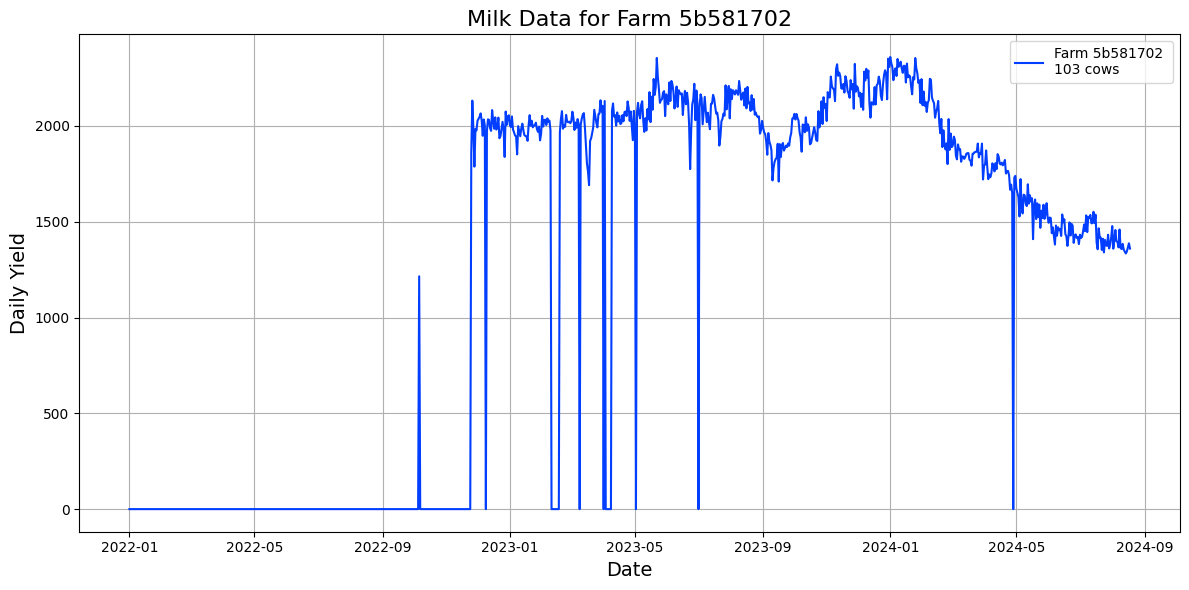

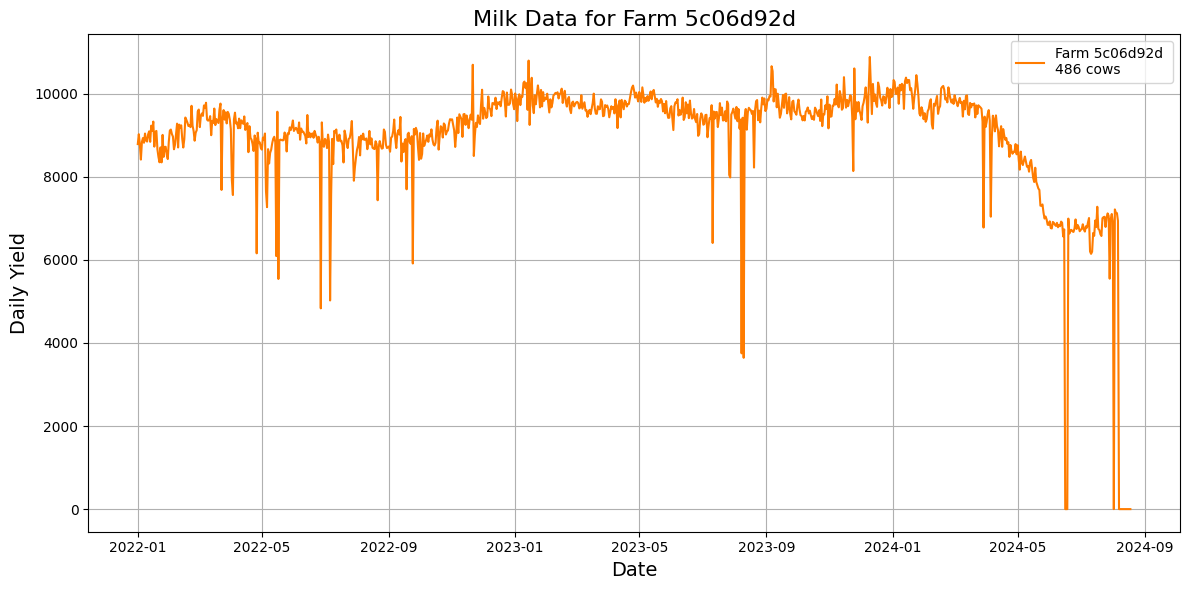

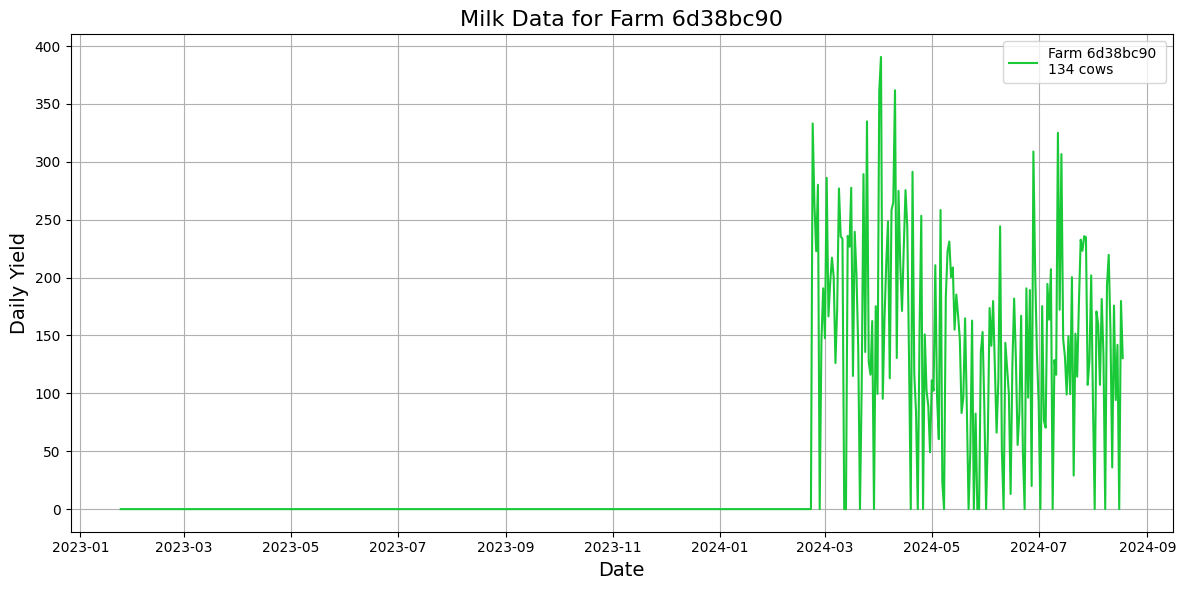

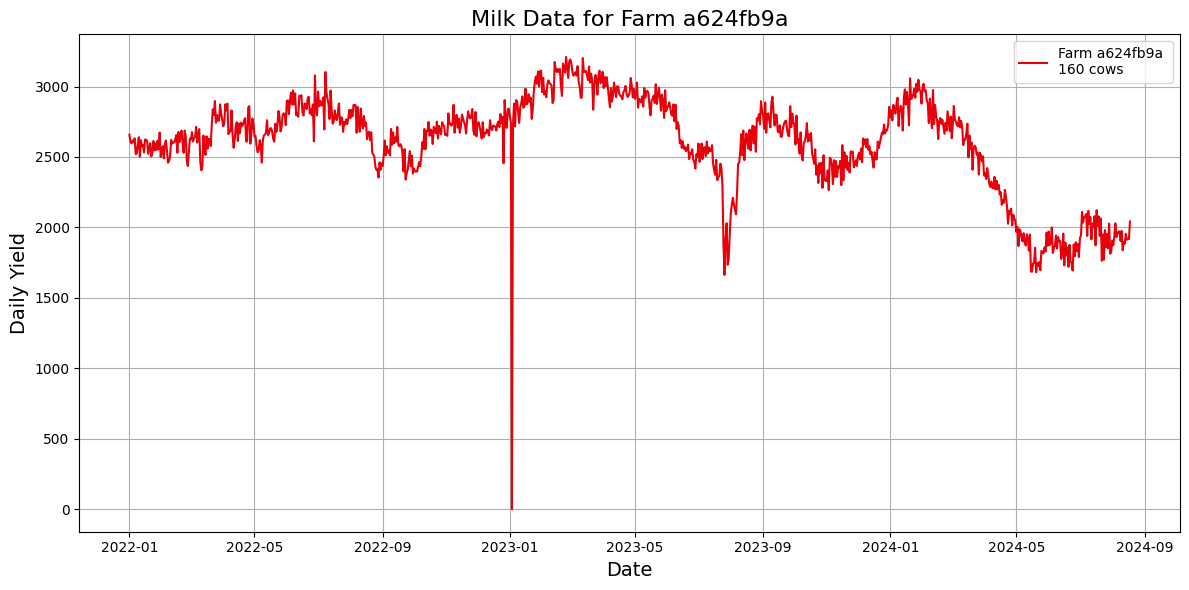

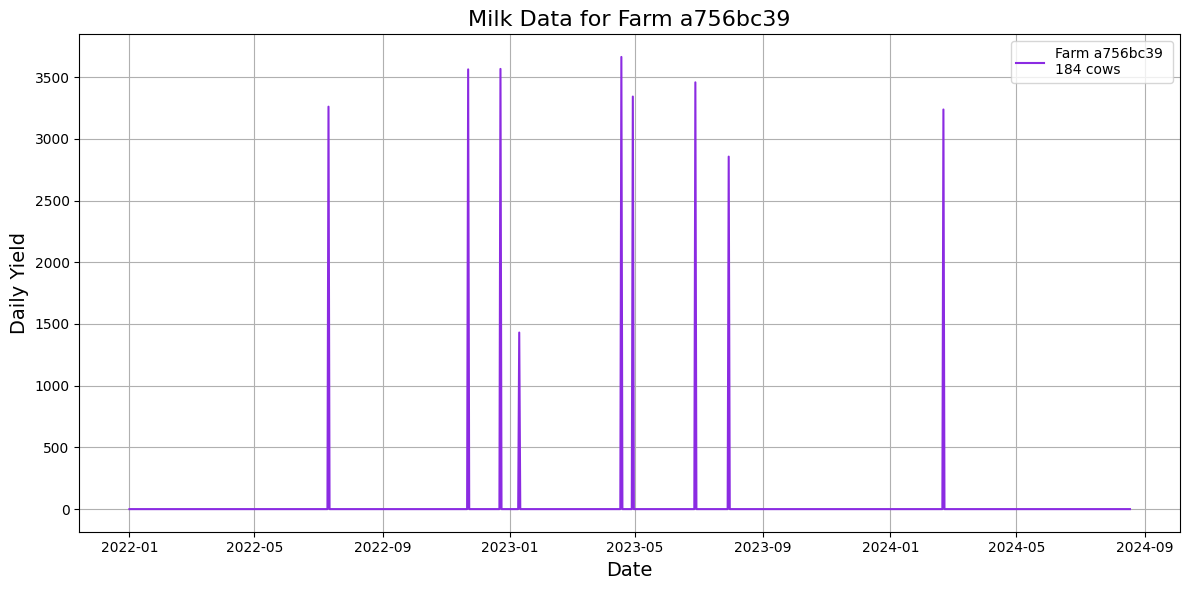

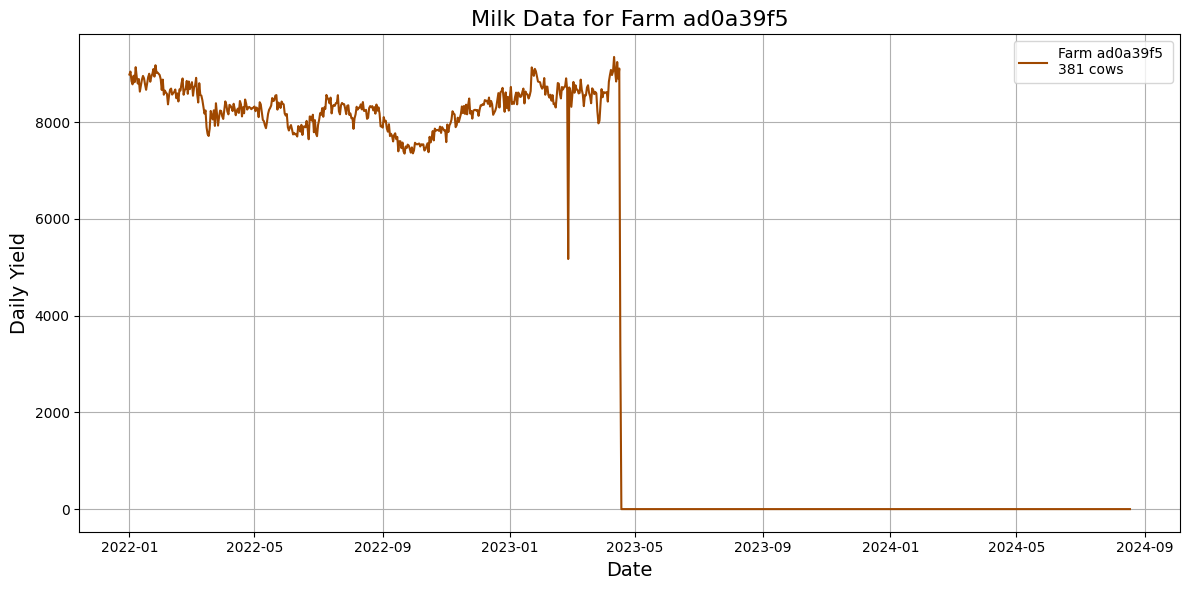

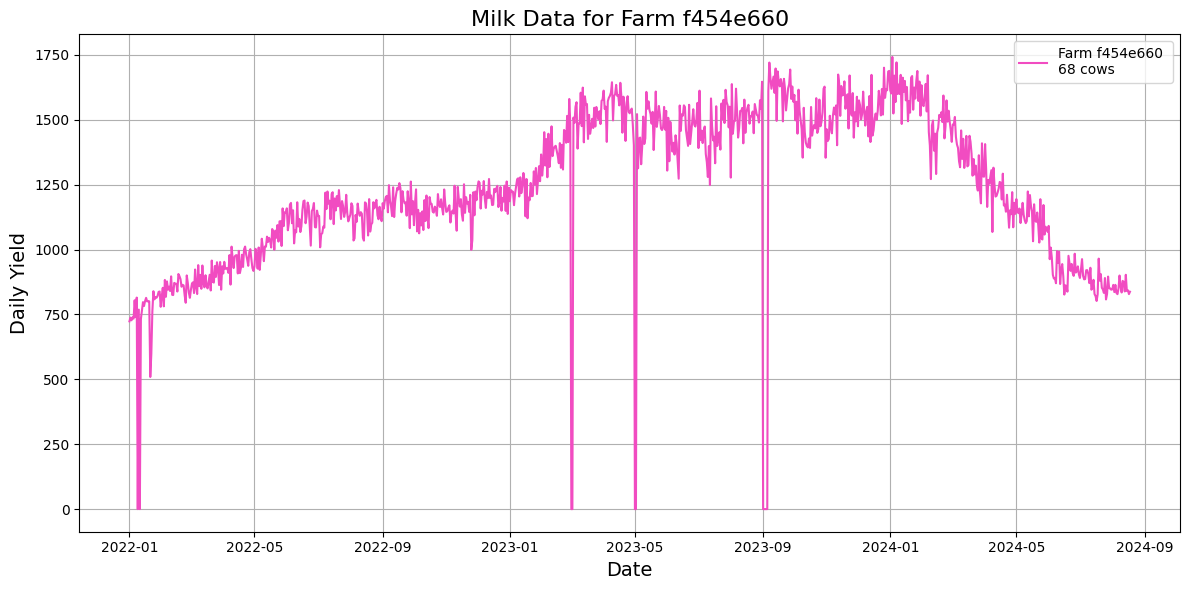

In [10]:
#
#
# PLOTTING TOTAL DAILY MILK YIELD BY HERD IN CRUDE DATA
# Load data
df_lact = pd.read_csv("../Data/CowData/MY_weather.csv", low_memory=False)
df_lact = df_lact.drop_duplicates(subset=["SE_Number", "LactationNumber", "StartDate", "StartTime", "SessionNumber", "TotalYield"])

# Ensure the StartDate column is a datetime object
df_lact['StartDate'] = pd.to_datetime(df_lact['StartDate'])

# list of farms
list_of_farms = list(df_lact["FarmName_Pseudo"].unique())

# Dictionary to store farm color mapping
farm_color_mapping = {}

# Loop through each farm and create a separate plot for each
for i, farm in enumerate(list_of_farms):
    # Create a new figure for each farm
    plt.figure(figsize=(12, 6))

    selected_farm = df_lact[df_lact['FarmName_Pseudo'] == farm]
    number_of_cows = len(selected_farm['SE_Number'].unique())
    daily_yield = selected_farm.groupby('StartDate')['TotalYield'].sum()

    # Get color for this farm, ensuring enough colors
    color = sns.color_palette('bright', n_colors=max(len(list_of_farms), 10))[i]
    farm_color_mapping[farm] = color

    # Generate a complete date range and reindex the daily yield
    all_dates = pd.date_range(start=daily_yield.index.min(), end=daily_yield.index.max(), freq='D')
    daily_yield = daily_yield.reindex(all_dates, fill_value=0)

    # Plot data
    plt.plot(daily_yield.index, daily_yield.values, label=f'Farm {farm} \n{number_of_cows} cows', color=color)
    plt.title(f'Milk Data for Farm {farm}', fontsize=16)
    plt.ylabel('Daily Yield', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)

    # Set x-axis label
    plt.xlabel('Date', fontsize=14)

    # Show the plot
    plt.tight_layout()
    plt.show()


In [12]:
#
#
# MAKE NEXT_CALVING
df_ins = pd.read_csv("../Data/updateDF.csv", low_memory=False)
col_keep = ["SE_Number", "LactationNumber", "CalvingDate"]
df_ins2a = df_ins[col_keep]
df_ins2a = df_ins2a.drop_duplicates(subset=["SE_Number", "LactationNumber", "CalvingDate"])

df_ins2b = df_ins2a.drop_duplicates(subset=["SE_Number", "LactationNumber", "CalvingDate"])
df_ins2b["next_calving"] = df_ins2b.groupby(["SE_Number"])["CalvingDate"].shift(-1)
df_ins2c = df_ins2a.merge(df_ins2b, on=["SE_Number", "LactationNumber", "CalvingDate"], how="left")

"""SE-169e580a-2831
SE_Number = ["SE-064c0cec-1189"]
df_ins2c = df_ins2c[df_ins2c["SE_Number"].isin(SE_Number)]
"""
df_ins2c.to_csv("../Data/fertility.csv", index=False)

# Add to original dataframe
df_ins2d = df_ins.merge(df_ins2c, on=["SE_Number", "LactationNumber", "CalvingDate"], how="left")
"""
SE_Number = ["SE-064c0cec-1189"]
df_ins2d = df_ins2d[df_ins2d["SE_Number"].isin(SE_Number)]
"""
df_ins2d.to_csv("../Data/updateDF.csv", index=False)

In [13]:
#
#
# CREATE NEXT_INS, PREV_INS AND UPDATE UPPER_LIMIT
df = pd.read_csv("../Data/updateDF.csv", low_memory=False)

df2 = df.drop_duplicates(subset=['SE_Number', "LactationNumber", "InseminationDate"])
df2 = df2.copy()
df2['next_ins'] = df2.groupby(['SE_Number', 'LactationNumber'])['InseminationDate'].shift(-1)
df2['prev_ins'] = df2.groupby(['SE_Number', 'LactationNumber'])['InseminationDate'].shift(1)
col_keep = ["SE_Number", "LactationNumber", "InseminationDate", "next_ins", "prev_ins"]
df2 = df2[col_keep]
df = pd.merge(df, df2, on=["SE_Number", "LactationNumber", "InseminationDate"], how="left")

df3 = df.drop_duplicates(subset=['SE_Number', "LactationNumber"])
df3 = df3.copy()
df3["shift_calf"] = df3.groupby(["SE_Number"])["CalvingDate"].shift(-1)
col_keep = ["SE_Number", "LactationNumber", "shift_calf"]
df3 = df3[col_keep]

df = pd.merge(df, df3, on=["SE_Number", "LactationNumber"], how="left")
# col_keep = ["SE_Number", "LactationNumber", "CalvingDate", "prev_ins", "InseminationDate", "next_ins",
#            "PregnancyCheckDate", "PregnancyStatus", "DryOffDate", "next_calving",
#            "CullingDate", "shift_calf"]
# df = df[col_keep]
df["upper_limit"] = df["DryOffDate"].fillna(df["shift_calf"]).fillna(df["CullingDate"])
df.to_csv("../Data/updateDF.csv", index=False)

In [14]:
#
#
# Descriptive statistics for milking file
df = pd.read_csv("../Data/MY_weather.csv", low_memory=False)
print(f"No. of unique milking events in database: {df.shape}")
df2 = df.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of lactations in milking file: {df2.shape}")
df2 = df.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows in milking file: {df2.shape}")
df2 = df.drop_duplicates(subset=["FarmName_Pseudo"])
print(f"No. of herds in milking file: {df2.shape}")

col_keep = ["FarmName_Pseudo"]
df2 = df2[col_keep]
print(f"Herds in unfiltered data: \n", df2.to_string(index=False))

No. of unique milking events in database: (1669008, 59)
No. of lactations in milking file: (2555, 59)
No. of cows in milking file: (1516, 59)
No. of herds in milking file: (7, 59)
Herds in unfiltered data: 
 FarmName_Pseudo
       5b581702
       5c06d92d
       6d38bc90
       a624fb9a
       a756bc39
       ad0a39f5
       f454e660


In [15]:
#
#
# SAVE IN updateDF.csv ONLY DATA FROM COWS AND LACTATIONS WITH MILK YIELD DATA
df = pd.read_csv("../Data/updateDF.csv", low_memory=False)

dfa = df.drop_duplicates(subset=['SE_Number', "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"No. of pregnancy checks in updateDF file: {dfa.shape}")  
dfa = df.drop_duplicates(subset=['SE_Number', "LactationNumber", "InseminationDate"])
print(f"No. of inseminations in updateDF file: {dfa.shape}")  
dfa = df.drop_duplicates(subset=['SE_Number', "LactationNumber"])
print(f"No. of lactations in updateDF file: {dfa.shape}")  
dfa = df.drop_duplicates(subset=['SE_Number'])
print(f"No. of cows in updateDF: {dfa.shape}")  

df2 = pd.read_csv("../Data/MY_weather.csv", low_memory=False)
df2["tag"] = 1
col_keep = ["SE_Number", "LactationNumber", "tag"]
df2 = df2[col_keep]
df2 = df2.drop_duplicates(subset=['SE_Number', "LactationNumber"])
print(df2.shape)  # 2421
# df2.to_csv("../Data/updateDF2.csv", index=False)

df3 = df2.merge(df, on=["SE_Number", "LactationNumber"], how="left")
df3 = df3[df3['tag'] == 1]
df3 = df3.drop(columns=["tag"])
"""
SE_Number = ["SE-064c0cec-1189"]
df3 = df3[df3["SE_Number"].isin(SE_Number)]
"""
df3.to_csv("../Data/updateDF.csv", index=False)
df3.to_csv("../Data/dfForSreten.csv", index=False)

df3a = df3.drop_duplicates(subset=['SE_Number', "LactationNumber", "InseminationDate", "PregnancyCheckDate"])
print(f"No. of pregnancy checks in updateDF file: {df3a.shape}")
df3a = df3.drop_duplicates(subset=['SE_Number', "LactationNumber", "InseminationDate"])
print(f"No. of inseminations in updateDF file: {df3a.shape}")
df3a = df3.drop_duplicates(subset=['SE_Number', "LactationNumber"])
print(f"No. of lactations in updateDF file: {df3a.shape}")
df3a = df3.drop_duplicates(subset=['SE_Number'])
print(f"No. of cows in updateDF: {df3a.shape}")

No. of pregnancy checks in updateDF file: (44552, 25)
No. of inseminations in updateDF file: (33732, 25)
No. of lactations in updateDF file: (17909, 25)
No. of cows in updateDF: (8865, 25)
(2555, 3)
No. of pregnancy checks in updateDF file: (6909, 25)
No. of inseminations in updateDF file: (4673, 25)
No. of lactations in updateDF file: (2555, 25)
No. of cows in updateDF: (1516, 25)


# FINAL COMMENTS:
- MY and weather data can be found in MY_weather.csv
- Basic data for each cow is in updateDF.csv
- Structure and codes corresponding to cow database whenever possible,
    see "Produktbeskrivning" and "Kokförteckning" from Växa
- First data from milking parlours, then from VMSs followed by weather data
- MESAN data from SMHI are on hourly basis, and has been matched to the closes hour of the milking event
        e.g. if the cow was milked 6:20, corresponding weather data is from 6:00
        e.g. if the cow was milked 16:45, corresponding weather data is from 17:00
- Mean of MESAN variables are used in the case of missing time stamps for milking events and for dry off
- MESAN data range covers 2022-01-01 to 2024-08-18 for all herds
- Range of MY data from Gigacow herds depend on when the herd was connected
- For basic production data, primary source is the cow database on the assumption that this information is superior
    to the herd management system. In the event of missing data from the cow database, data from the management system
    is added
    Note: A lot of cows will lack AnimalNumber, Del_Cow_Id because of primary source is from the cow database
- Complementary data from cow database is updated once every quarter 
- 'CullingReason1' and 'CullingReason2' are the combined culling reasons as recorded in herd management system and cow 
    database, however, kept originals due to free text recording can vary
- PregnancyStatus was originally free text alternatives but has been changed to coincide with cow database codes,
    see "Kokförteckning" from Växa

# NOTE! 
MANUALLY CREATED AND MOVED DATA TO ../Data/MergedData/ AFTER THIS AND FERTILITY SCRIPT WERE RUN, BUT IN PREPARATION FOR WILMINKS AND FURTHER ANALYSIS

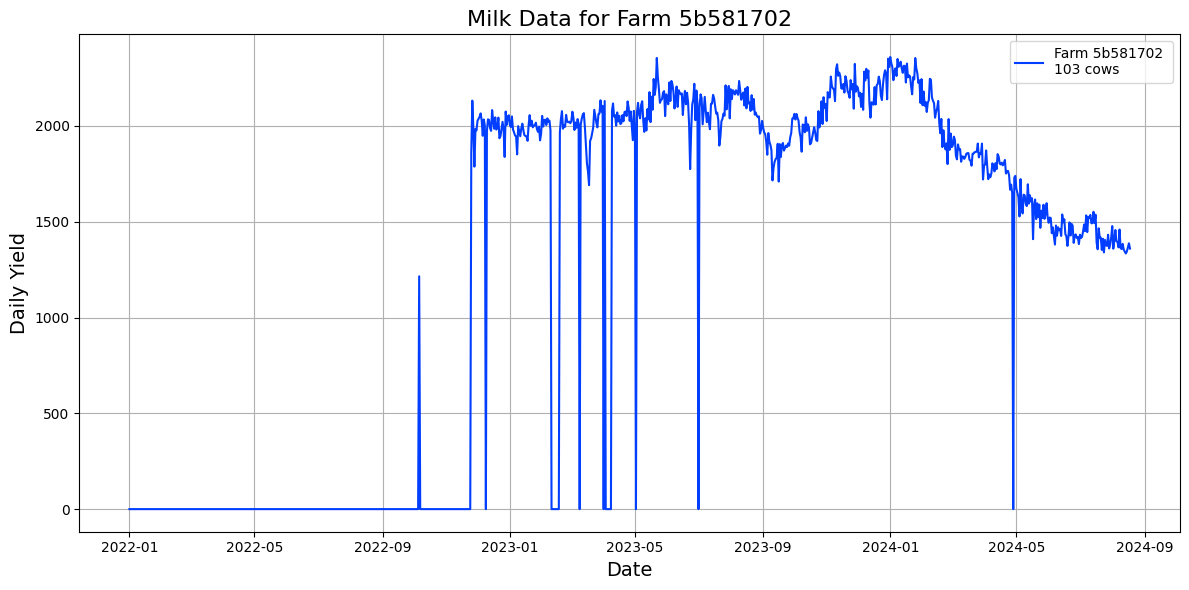

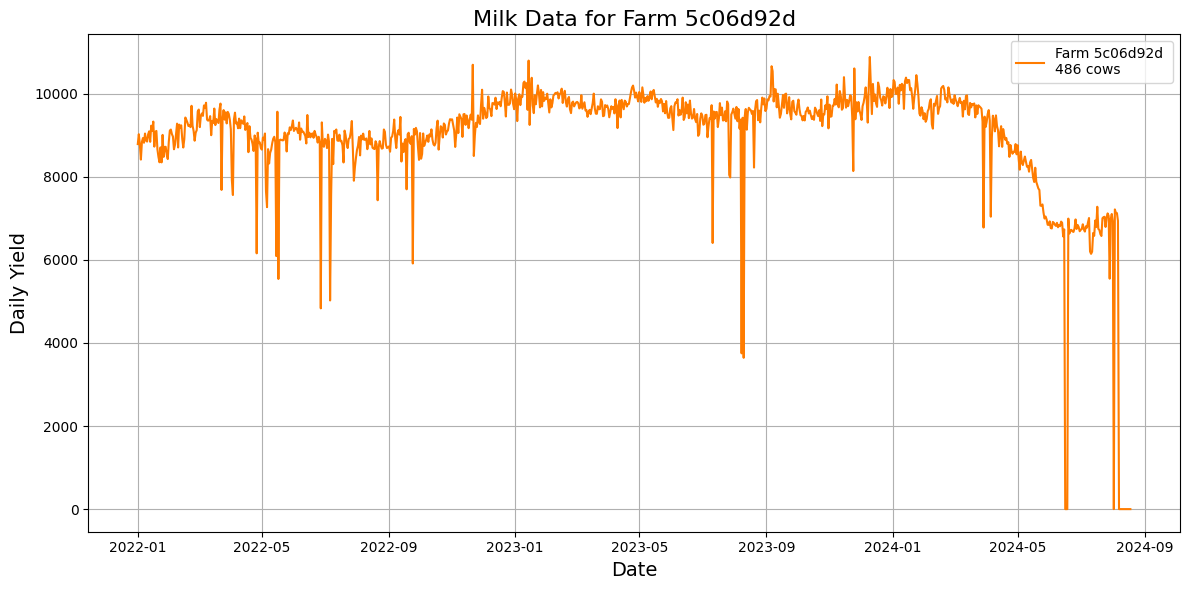

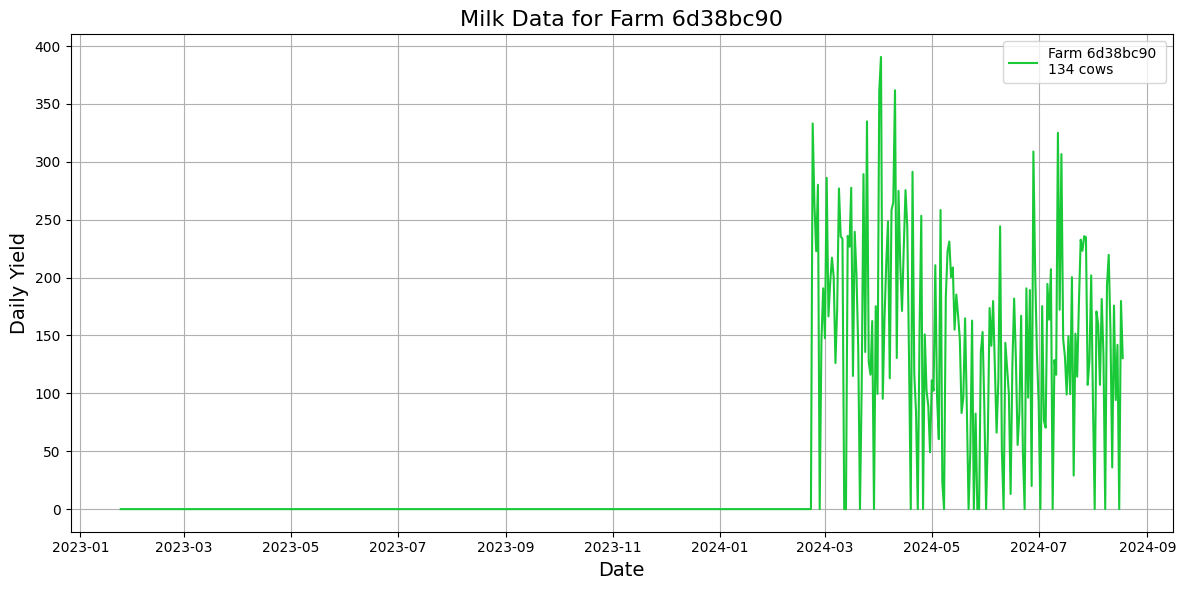

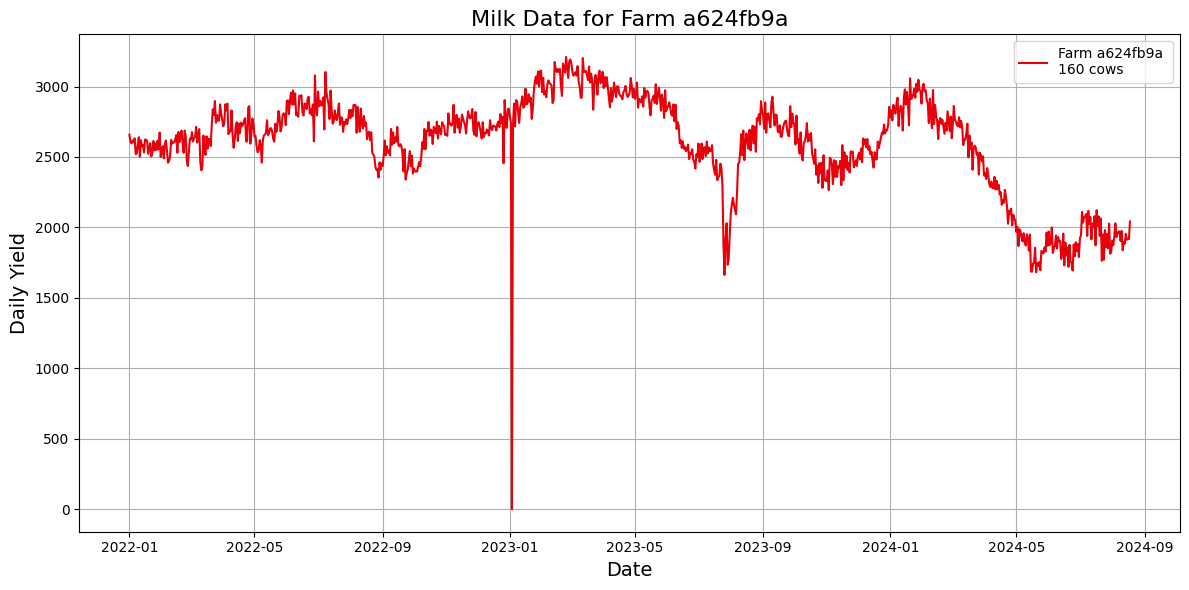

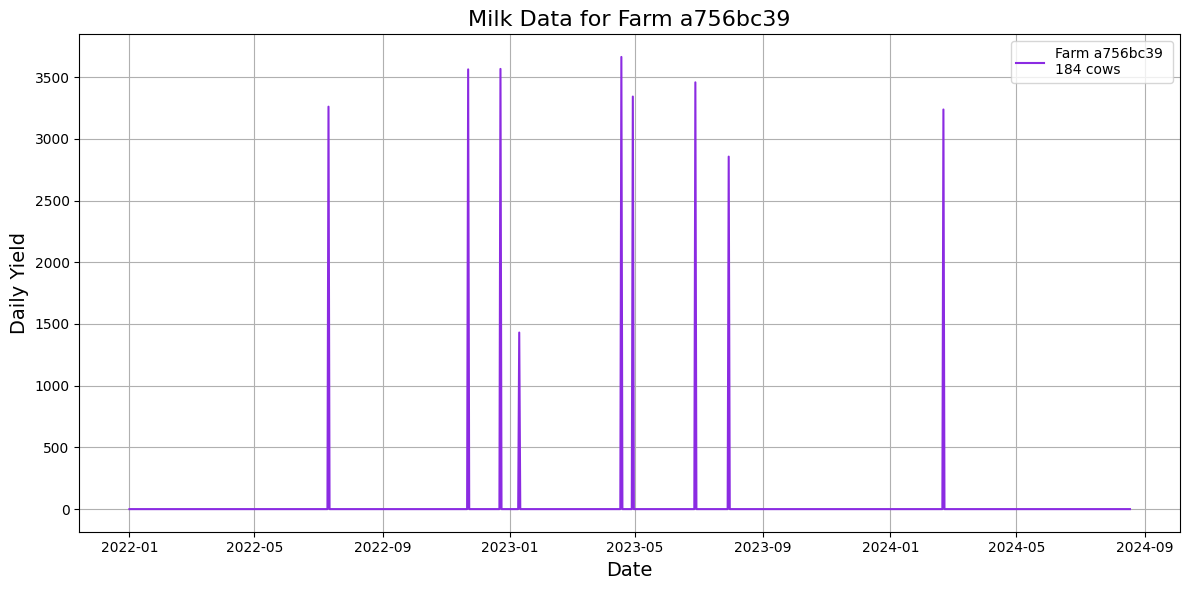

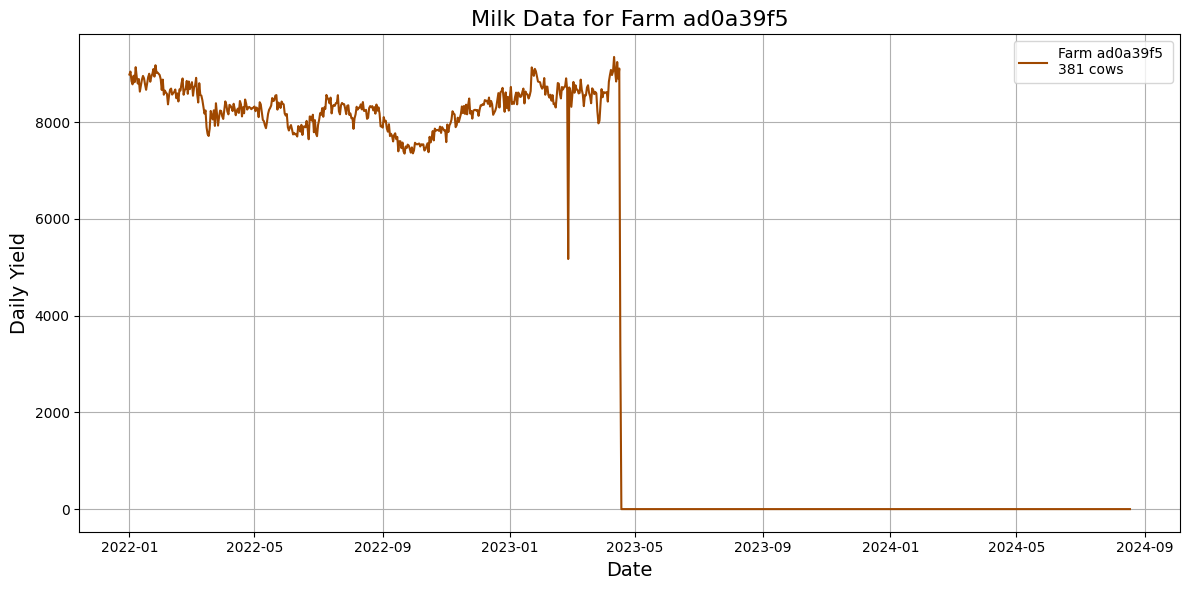

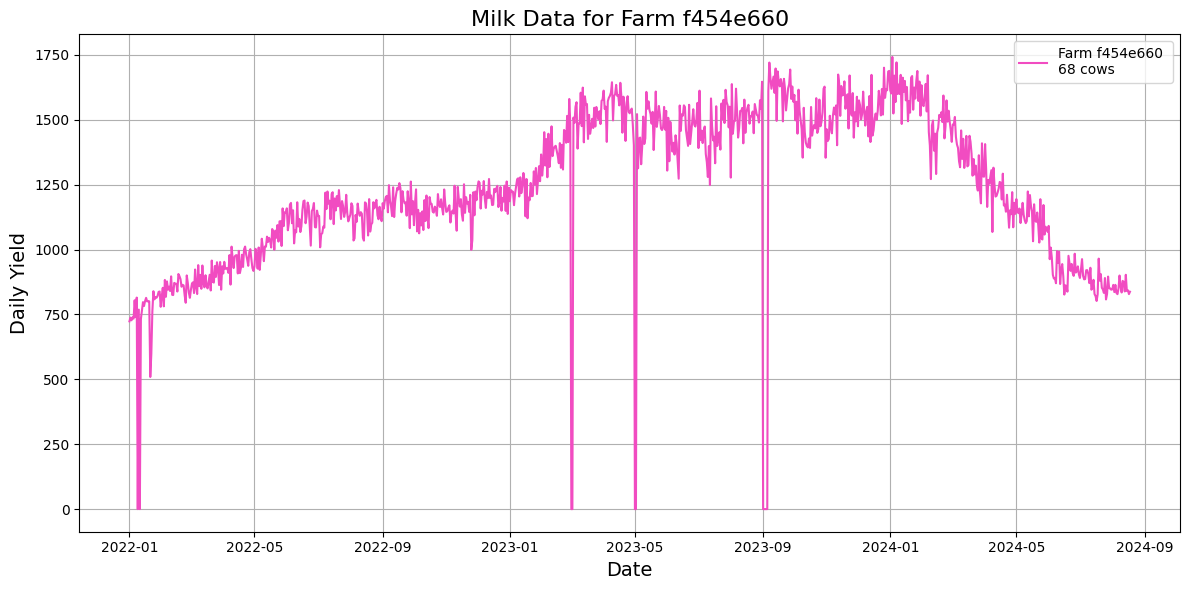

In [16]:
#
#
# PLOTTING TOTAL DAILY MILK YIELD BY HERD IN CRUDE DATA
# Load data
df_lact = pd.read_csv("../Data/MY_weather.csv", low_memory=False)

# Ensure the StartDate column is a datetime object
df_lact['StartDate'] = pd.to_datetime(df_lact['StartDate'])

# list of farms
list_of_farms = list(df_lact["FarmName_Pseudo"].unique())

# Dictionary to store farm color mapping
farm_color_mapping = {}

# Loop through each farm and create a separate plot for each
for i, farm in enumerate(list_of_farms):
    # Create a new figure for each farm
    plt.figure(figsize=(12, 6))

    selected_farm = df_lact[df_lact['FarmName_Pseudo'] == farm]
    number_of_cows = len(selected_farm['SE_Number'].unique())
    daily_yield = selected_farm.groupby('StartDate')['TotalYield'].sum()

    # Get color for this farm, ensuring enough colors
    color = sns.color_palette('bright', n_colors=max(len(list_of_farms), 10))[i]
    farm_color_mapping[farm] = color

    # Generate a complete date range and reindex the daily yield
    all_dates = pd.date_range(start=daily_yield.index.min(), end=daily_yield.index.max(), freq='D')
    daily_yield = daily_yield.reindex(all_dates, fill_value=0)

    # Plot data
    plt.plot(daily_yield.index, daily_yield.values, label=f'Farm {farm} \n{number_of_cows} cows', color=color)
    plt.title(f'Milk Data for Farm {farm}', fontsize=16)
    plt.ylabel('Daily Yield', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)

    # Set x-axis label
    plt.xlabel('Date', fontsize=14)

    # Show the plot
    plt.tight_layout()
    plt.show()


# FILTERING MILK YIELD DATA
- keep only NRDC, SH, SJB and dairy crosses
- have to start milking by 1-40DIM and maintain milking until 100-400DIM
- keep only 1-7 lactation (make parity 1, 2, +3)
- set MY between 2.5-60kg to handle outliers, kick-offs and incomplete milkings
- generates filtered dataset MY_weather_filtered.csv


No. milking events in MY_weather.csv: (1669008, 59)
Breed
SLB               906029
NRDC              391858
DairyCross        281738
Other              40070
SJB                30518
DairyBeefCross      5768
BeefDairyCross      4641
Unknown             1661
Name: count, dtype: int64


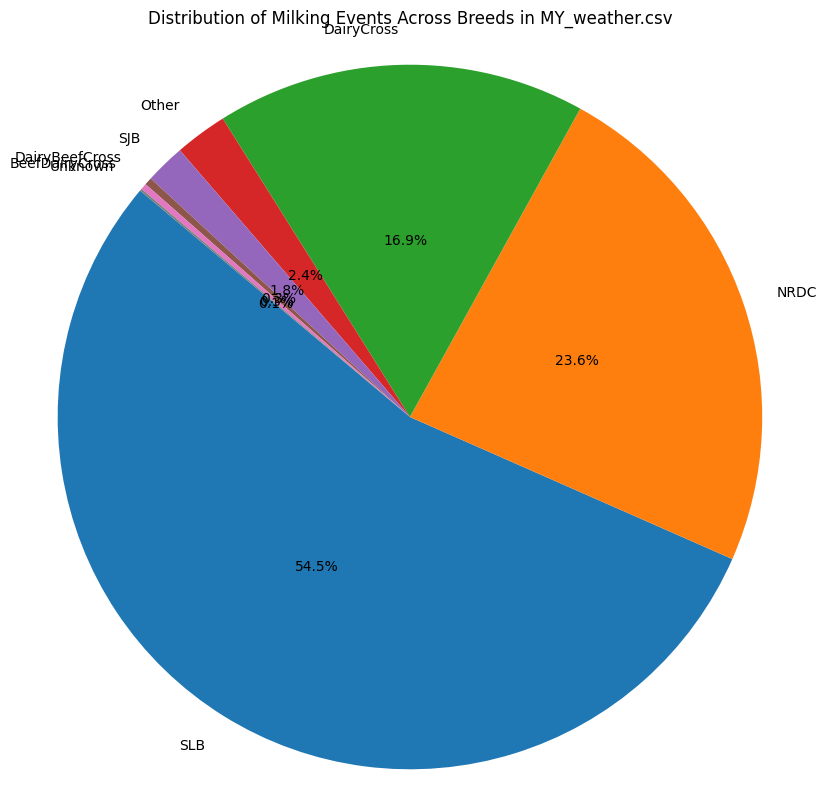

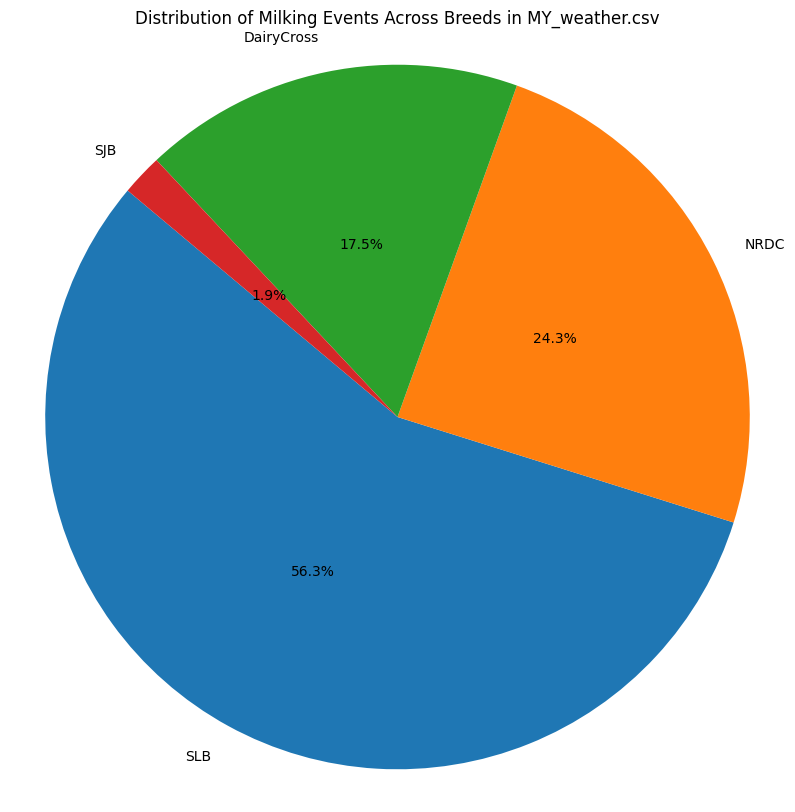

No. milking events in SRB, SH, dairy Crosses and SJB cows: (1610143, 59)
No. of lactations from SRB, SH, SJB and dairy crosses: (2440, 59)
No. of cows from SRB, SH, SJB and dairy crosses: (1433, 59)


In [54]:
#
#
# FILTER MILK YIELD DATA
df3 = pd.read_csv("../Data/MY_weather.csv", low_memory=False)
print(f"No. milking events in MY_weather.csv: {df3.shape}")

value_counts = df3['Breed'].value_counts()
print(value_counts)

# Pie chart over distribution of Breed in crude data
value_counts = df3['Breed'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.5)
plt.axis('equal')
plt.title('Distribution of Milking Events Across Breeds in MY_weather.csv')
plt.show()

# Keep only SRB, SH, dairy crosses and SJB
df3 = df3[(df3["Breed"] == "NRDC") |
          (df3["Breed"] == "SLB") |
          (df3["Breed"] == "DairyCross") |
          (df3["Breed"] == "SJB")]

# Pie chart over distribution of Breed in filtered data
value_counts = df3['Breed'].value_counts()
plt.figure(figsize=(10, 10))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140, pctdistance=0.5)
plt.axis('equal')
plt.title('Distribution of Milking Events Across Breeds in MY_weather.csv')
plt.show()

# No. milking events, lactations and cows in data
print(f"No. milking events in SRB, SH, dairy Crosses and SJB cows: {df3.shape}")
test = df3.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of lactations from SRB, SH, SJB and dairy crosses: {test.shape}")
test = test.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows from SRB, SH, SJB and dairy crosses: {test.shape}")

In [55]:
# Transfer basic data about lactation to every observation, including those missing MY data
print("Original shape of df3:", df3.shape)

# Select columns to keep and remove duplicates from df
df = df3[df3['DaysInMilk'].notna()]
col_keep = ["SE_Number", "CalvingDate", "LactationNumber", "upper_limit"]
df = df[col_keep].drop_duplicates(subset=["SE_Number", "LactationNumber"])
# df.to_csv("../Data/MY3.csv", index=False)

# Set 'ID' as the index in both DataFrames
df.set_index(['SE_Number', "LactationNumber"], inplace=True)
df3.set_index(['SE_Number', "LactationNumber"], inplace=True)

# Use .update() to overwrite values
df3.update(df)

# Reset index
df3.reset_index(inplace=True)

# Calculate DaysInMilk2 and save
df3["StartDate"] = pd.to_datetime(df3["StartDate"])
df3["CalvingDate"] = pd.to_datetime(df3["CalvingDate"])
df3["DaysInMilk2"] = (df3["StartDate"] - df3["CalvingDate"]).dt.days + 1
new_column_order = ["FarmName_Pseudo", "SE_Number", "AnimalNumber", "Del_Cow_Id", "Breed", "LactationNumber", "CalvingDate", "upper_limit", "DaysInMilk2",
                    "StartDate", "StartTime", "SessionNumber", "TotalYield", 
                    "TotalYieldLF", "TotalYieldRF", "TotalYieldLR", "TotalYieldRR",
                    "AverageFlowLF", "AverageFlowLR", "AverageFlowRF", "AverageFlowRR",
                    "PeakFlowLF", "PeakFlowLR", "PeakFlowRF", "PeakFlowRR",
                    "BloodLF", "BloodLR", "BloodRF", "BloodRR",
                    "ConductivityLF", "ConductivityLR", "ConductivityRF", "ConductivityRR",
                    "Occ",
                    "Temperature", "RelativeHumidity", "WindSpeed", "WindDirection", "Crosswind", "Precipitation",
                    "Snow", "PrecipitationType", "Cloudiness", "Visibility", "AirPressure", "GlobalIrradiance",
                    "THI_adj", "HW", "cum_HW", "Temp15Threshold",
                    "MeanTemperature", "MeanRelativeHumidity", "MeanWindSpeed", "MeanPrecipitation", "MeanGlobalIrradiance",
                    "MeanTHI_adj", "MeanHW", "Meancum_HW", "MeanTemp15Threshold"]
df3 = df3[new_column_order]
# df3.to_csv("../Data/MY4.csv", index=False)
print("New shape of df3:", df3.shape)

Original shape of df3: (1610143, 59)


C:\Users\pagd0001\AppData\Local\Temp\ipykernel_20728\3420429422.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df3.update(df)
C:\Users\pagd0001\AppData\Local\Temp\ipykernel_20728\3420429422.py:15: PerformanceWarning: indexing past lexsort depth may impact performance.
  df3.update(df)


New shape of df3: (1610143, 59)


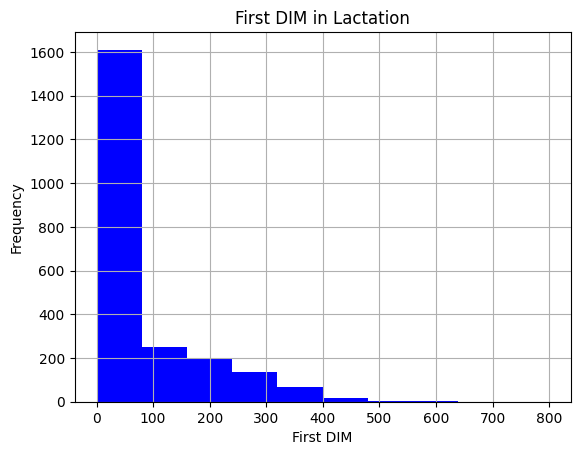

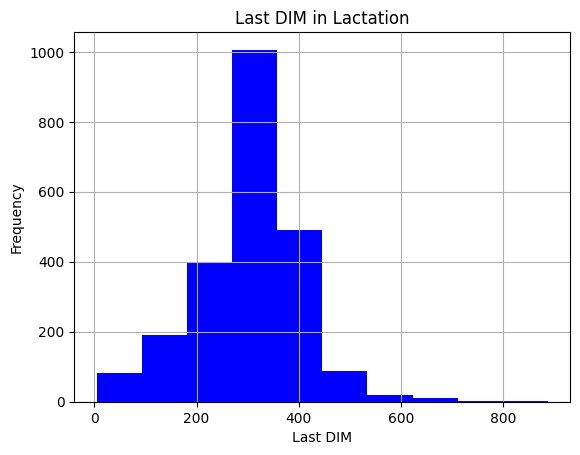

Mean and SD First DIM: 
 FarmName_Pseudo  MeanFirstDIM  SDFirstDIM
       5b581702          44.0        86.0
       5c06d92d          28.0        68.0
       6d38bc90         194.0       108.0
       a624fb9a          21.0        59.0
       a756bc39         111.0        92.0
       ad0a39f5          40.0        69.0
       f454e660          20.0        52.0
Mean and SD Last DIM: 
 FarmName_Pseudo  MeanLastDIM  SDLastDIM
       5b581702        348.0      106.0
       5c06d92d        354.0       95.0
       6d38bc90        278.0      101.0
       a624fb9a        330.0       79.0
       a756bc39        233.0       97.0
       ad0a39f5        276.0       95.0
       f454e660        380.0       80.0


In [56]:
# LOOK AT FIRST AND LAST DIM WHERE HAVE MILK YIELD
df4 = df3[df3['TotalYield'].notna()]
first_last_df = df4.groupby(['SE_Number', 'LactationNumber'])['DaysInMilk2'].agg(['first', 'last']).reset_index()

plt.figure()
plt.hist(first_last_df["first"], color='blue')
plt.title(f"First DIM in Lactation")
plt.xlabel('First DIM')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

plt.figure()
plt.hist(first_last_df["last"], color='blue')
plt.title(f"Last DIM in Lactation")
plt.xlabel('Last DIM')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

df3 = df3.merge(first_last_df, on=["SE_Number", "LactationNumber"], how="left")
df3.to_csv("../Data/MY3.csv", index=False)

average_production = (df3.groupby(['FarmName_Pseudo'])['first'].agg(['mean', 'std']).reset_index())
average_production['mean'] = average_production['mean'].round(0)
average_production['std'] = average_production['std'].round(0)
average_production.rename(columns={'mean': 'MeanFirstDIM', 'std': 'SDFirstDIM'}, inplace=True)
print(f"Mean and SD First DIM: \n", average_production.to_string(index=False))

average_production = (df3.groupby(['FarmName_Pseudo'])['last'].agg(['mean', 'std']).reset_index())
average_production['mean'] = average_production['mean'].round(0)
average_production['std'] = average_production['std'].round(0)
average_production.rename(columns={'mean': 'MeanLastDIM', 'std': 'SDLastDIM'}, inplace=True)
print(f"Mean and SD Last DIM: \n", average_production.to_string(index=False))

In [57]:
# Filter to demand started milking by 1-40 DIM and maintain milking until 100-400 DIM
def filter_first_last(group):
    first_value = group['first'].iloc[0]
    last_value = group['last'].iloc[-1]
    return (1 <= first_value <= 40) and (100 <= last_value <= 400)


filtered_df = df3.groupby(["SE_Number", "LactationNumber"]).filter(filter_first_last)

# No. milking events, lactations and cows in data
print(f"No. milking events in SRB, SH, SJB and dairy crosses cows within 1-40 DIM and 100-400 DIM: {filtered_df.shape}")
test = filtered_df.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of lactations from SRB, SH, SJB and dairy crosses within 1-40DIM and 100-400DIM: {test.shape}")
test = filtered_df.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows from SRB, SH, SJB and dairy crosses within 1-40DIM and 100-400DIM: {test.shape}")
filtered_df.to_csv("../Data/MY3.csv", index=False)

No. milking events in SRB, SH, SJB and dairy crosses cows within 1-40 DIM and 100-400 DIM: (999347, 61)
No. of lactations from SRB, SH, SJB and dairy crosses within 1-40DIM and 100-400DIM: (1214, 61)
No. of cows from SRB, SH, SJB and dairy crosses within 1-40DIM and 100-400DIM: (926, 61)


In [58]:
# Distribution of milk yield data over various lactations
value_counts = filtered_df['LactationNumber'].value_counts()
print(value_counts)

# Keep only lactation 1-7
df_lact = filtered_df[filtered_df["LactationNumber"] <= 8]
print(f"No. milking events in SRB, SH, SJB and dairy crosses cows within 1-40 DIM and 100-400 DIM in lactation 1-8: "
      f"{df_lact.shape}")  

# No. lactations and cows in data
test = df_lact.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of lactations from SRB, SH, SJB and dairy crosses within 1-40DIM and 100-400DIM in lactation 1-8: {test.shape}")
test = df_lact.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows from SRB, SH, SJB and dairy crosses within 1-40DIM and 100-400DIM in lactation 1-8: {test.shape}")

# Make Parity 1-3
df_lact = df_lact.copy()
df_lact["Parity"] = df_lact["LactationNumber"]
df_lact.loc[(df_lact['LactationNumber'] >= 3) & (df_lact['LactationNumber'] <= 7), 'Parity'] = 3
df_lact.to_csv("../Data/MY3.csv", index=False)

LactationNumber
1.0     352215
2.0     261876
3.0     178420
4.0     120492
5.0      61371
6.0      17681
7.0       3127
8.0       2936
9.0        842
10.0       387
Name: count, dtype: int64
No. milking events in SRB, SH, SJB and dairy crosses cows within 1-40 DIM and 100-400 DIM in lactation 1-8: (998118, 61)
No. of lactations from SRB, SH, SJB and dairy crosses within 1-40DIM and 100-400DIM in lactation 1-8: (1212, 61)
No. of cows from SRB, SH, SJB and dairy crosses within 1-40DIM and 100-400DIM in lactation 1-8: (925, 61)


Descriptive Statistics:
 count    903521.000000
mean         12.718956
std           3.995593
min           0.000000
25%          10.266700
50%          12.380000
75%          14.880000
max         561.500000
Name: TotalYield, dtype: float64

Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [ 4.2083  7.5     8.555  17.45   19.1033 22.61  ]


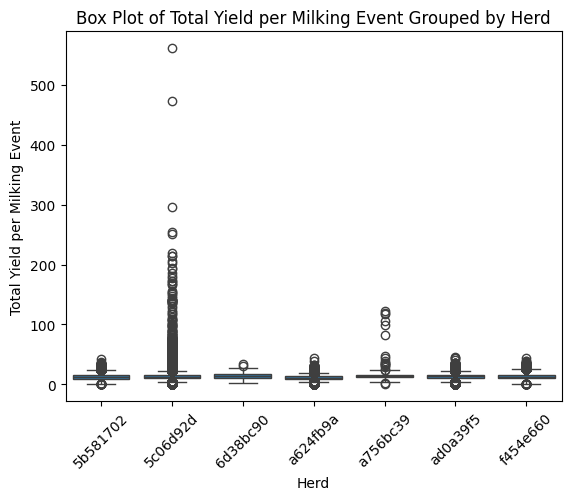

In [59]:
# CHECK DISTRIBUTION OF TOTAL YIELD COLUMN
# Basic statistics
summary_stats = df_lact['TotalYield'].describe()
percentiles = np.percentile(df_lact['TotalYield'].dropna(), [1, 5, 10, 90, 95, 99])

print("Descriptive Statistics:\n", summary_stats)
print("\nPercentiles (1%, 5%, 10%, 90%, 95%, 99%):", percentiles)

# count_my_rec = df.drop_duplicates(subset=["SE_Number", "LactationNumber"])
sns.boxplot(x='FarmName_Pseudo', y='TotalYield', data=df_lact)
plt.title('Box Plot of Total Yield per Milking Event Grouped by Herd')
plt.xlabel('Herd')
plt.ylabel('Total Yield per Milking Event')
plt.xticks(rotation=45)
plt.show()

In [61]:
# OBS THIS STEP REMOVES MISSING RECORDS FOR TOTAL YIELD, ie dry period
df_lact = pd.read_csv("../Data/MY3.csv", low_memory=False)

# Count instances with TotalYield greater than 60 L
count_invalid_total_yield = df_lact[df_lact['TotalYield'] > 60].shape[0]
print(f"Number of instances with TotalYield greater than 60: {count_invalid_total_yield}")
df_lact2 = df_lact[df_lact['TotalYield'] < 60]

count_invalid_total_yield = df_lact2[df_lact2['TotalYield'] < 2.5].shape[0]
print(f"Number of instances with TotalYield less than 2.5 kg: {count_invalid_total_yield}")
df_lact2 = df_lact2[df_lact2['TotalYield'] > 2.5]
df_lact2.to_csv("../Data/MY4.csv", index=False)

df3a = df_lact2.drop_duplicates(subset=['SE_Number', "LactationNumber", "StartDate", "StartTime", "SessionNumber"])
print(f"No. of milking events in MY file: {df3a.shape}")
df3a = df_lact2.drop_duplicates(subset=['SE_Number', "LactationNumber", "StartDate"])
print(f"No. of milking days in MY file: {df3a.shape}")
df3a = df_lact2.drop_duplicates(subset=['SE_Number', "LactationNumber"])
print(f"No. of lactations in MY file: {df3a.shape}")
df3a = df_lact2.drop_duplicates(subset=['SE_Number'])
print(f"No. of cows in MY file: {df3a.shape}")

Number of instances with TotalYield greater than 60: 140
Number of instances with TotalYield less than 2.5 kg: 6054
No. of milking events in MY file: (897315, 62)
No. of milking days in MY file: (311995, 62)
No. of lactations in MY file: (1212, 62)
No. of cows in MY file: (925, 62)


Descriptive Statistics:
 count    895106.000000
mean         12.782468
std           3.586577
min           2.510000
25%          10.310000
50%          12.410000
75%          14.900000
max          59.966700
Name: TotalYield, dtype: float64

Percentiles (1%, 5%, 10%, 90%, 95%, 99%): [ 5.6   7.68  8.65 17.46 19.11 22.59]


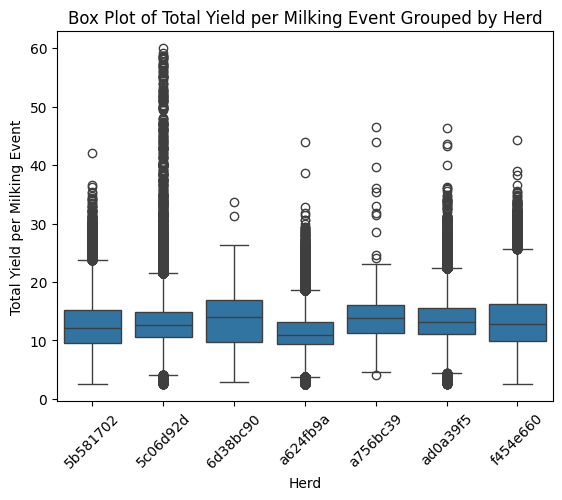

In [51]:
# Basic statistics
summary_stats = df_lact2['TotalYield'].describe()
percentiles = np.percentile(df_lact2['TotalYield'].dropna(), [1, 5, 10, 90, 95, 99])

print("Descriptive Statistics:\n", summary_stats)
print("\nPercentiles (1%, 5%, 10%, 90%, 95%, 99%):", percentiles)

sns.boxplot(x='FarmName_Pseudo', y='TotalYield', data=df_lact2)
plt.title('Box Plot of Total Yield per Milking Event Grouped by Herd')
plt.xlabel('Herd')
plt.ylabel('Total Yield per Milking Event')
plt.xticks(rotation=45)
plt.show()

df_lact2.to_csv("../Data/MY_weather_filtered.csv", index=False)

In [52]:
#
#
# DESCRIPTIVE STATISTICS FILTERED DATA
# Milking records
df_lact = pd.read_csv("../Data/MY_weather_filtered.csv", low_memory=False)

count_my_rec = df_lact.groupby(["Parity"])["StartDate"].count().reset_index()
print(f"No. of milking records divided over parities: \n", count_my_rec.to_string(index=False))

count_my_rec = df_lact.groupby(["Parity", "Breed"])["StartDate"].count().reset_index()
print(f"No. of milking records divided over parities and breeds: \n", count_my_rec.to_string(index=False))

# By parity
for_my_rec5 = df_lact.drop_duplicates(subset=["SE_Number", "LactationNumber"])
print(f"No. of parities in milking file: {for_my_rec5.shape}")  # 1,207

count_my_rec = for_my_rec5.groupby(["Parity", "Breed"])["SE_Number"].count().reset_index()
print(f"No. of parities from SRB, SH, SJB and dairy crosses: \n", count_my_rec.to_string(index=False))

# By cows
for_my_rec4 = df_lact.drop_duplicates(subset=["SE_Number"])
print(f"No. of cows in milking file: {for_my_rec4.shape}")  # 921

for_my_rec5 = for_my_rec4.drop_duplicates(subset=["SE_Number"])
count_my_rec = for_my_rec5.groupby(["Breed"])["SE_Number"].count().reset_index()
print(f"No. of cows from SRB, SH, SJB and dairy crosses: \n", count_my_rec.to_string(index=False))

# Herd info
df_lact = pd.read_csv("../Data/MY_weather_filtered.csv", low_memory=False)
df_lact = df_lact.drop_duplicates(subset=["FarmName_Pseudo"])
col_keep = ["FarmName_Pseudo"]
df_lact = df_lact[col_keep]
print(df_lact.shape)
print(f"Herds in filtered data: \n", df_lact.to_string(index=False))

No. of milking records divided over parities: 
  Parity  StartDate
    1.0     317178
    2.0     234383
    3.0     343545
No. of milking records divided over parities and breeds: 
  Parity      Breed  StartDate
    1.0 DairyCross      46124
    1.0       NRDC      77914
    1.0        SJB       7061
    1.0        SLB     186079
    2.0 DairyCross      43443
    2.0       NRDC      52799
    2.0        SJB       4599
    2.0        SLB     133542
    3.0 DairyCross      82718
    3.0       NRDC      82945
    3.0        SJB       9297
    3.0        SLB     168585
No. of parities in milking file: (1207, 62)
No. of parities from SRB, SH, SJB and dairy crosses: 
  Parity      Breed  SE_Number
    1.0 DairyCross         60
    1.0       NRDC        106
    1.0        SJB         11
    1.0        SLB        250
    2.0 DairyCross         56
    2.0       NRDC         75
    2.0        SJB          7
    2.0        SLB        181
    3.0 DairyCross        104
    3.0       NRDC        11

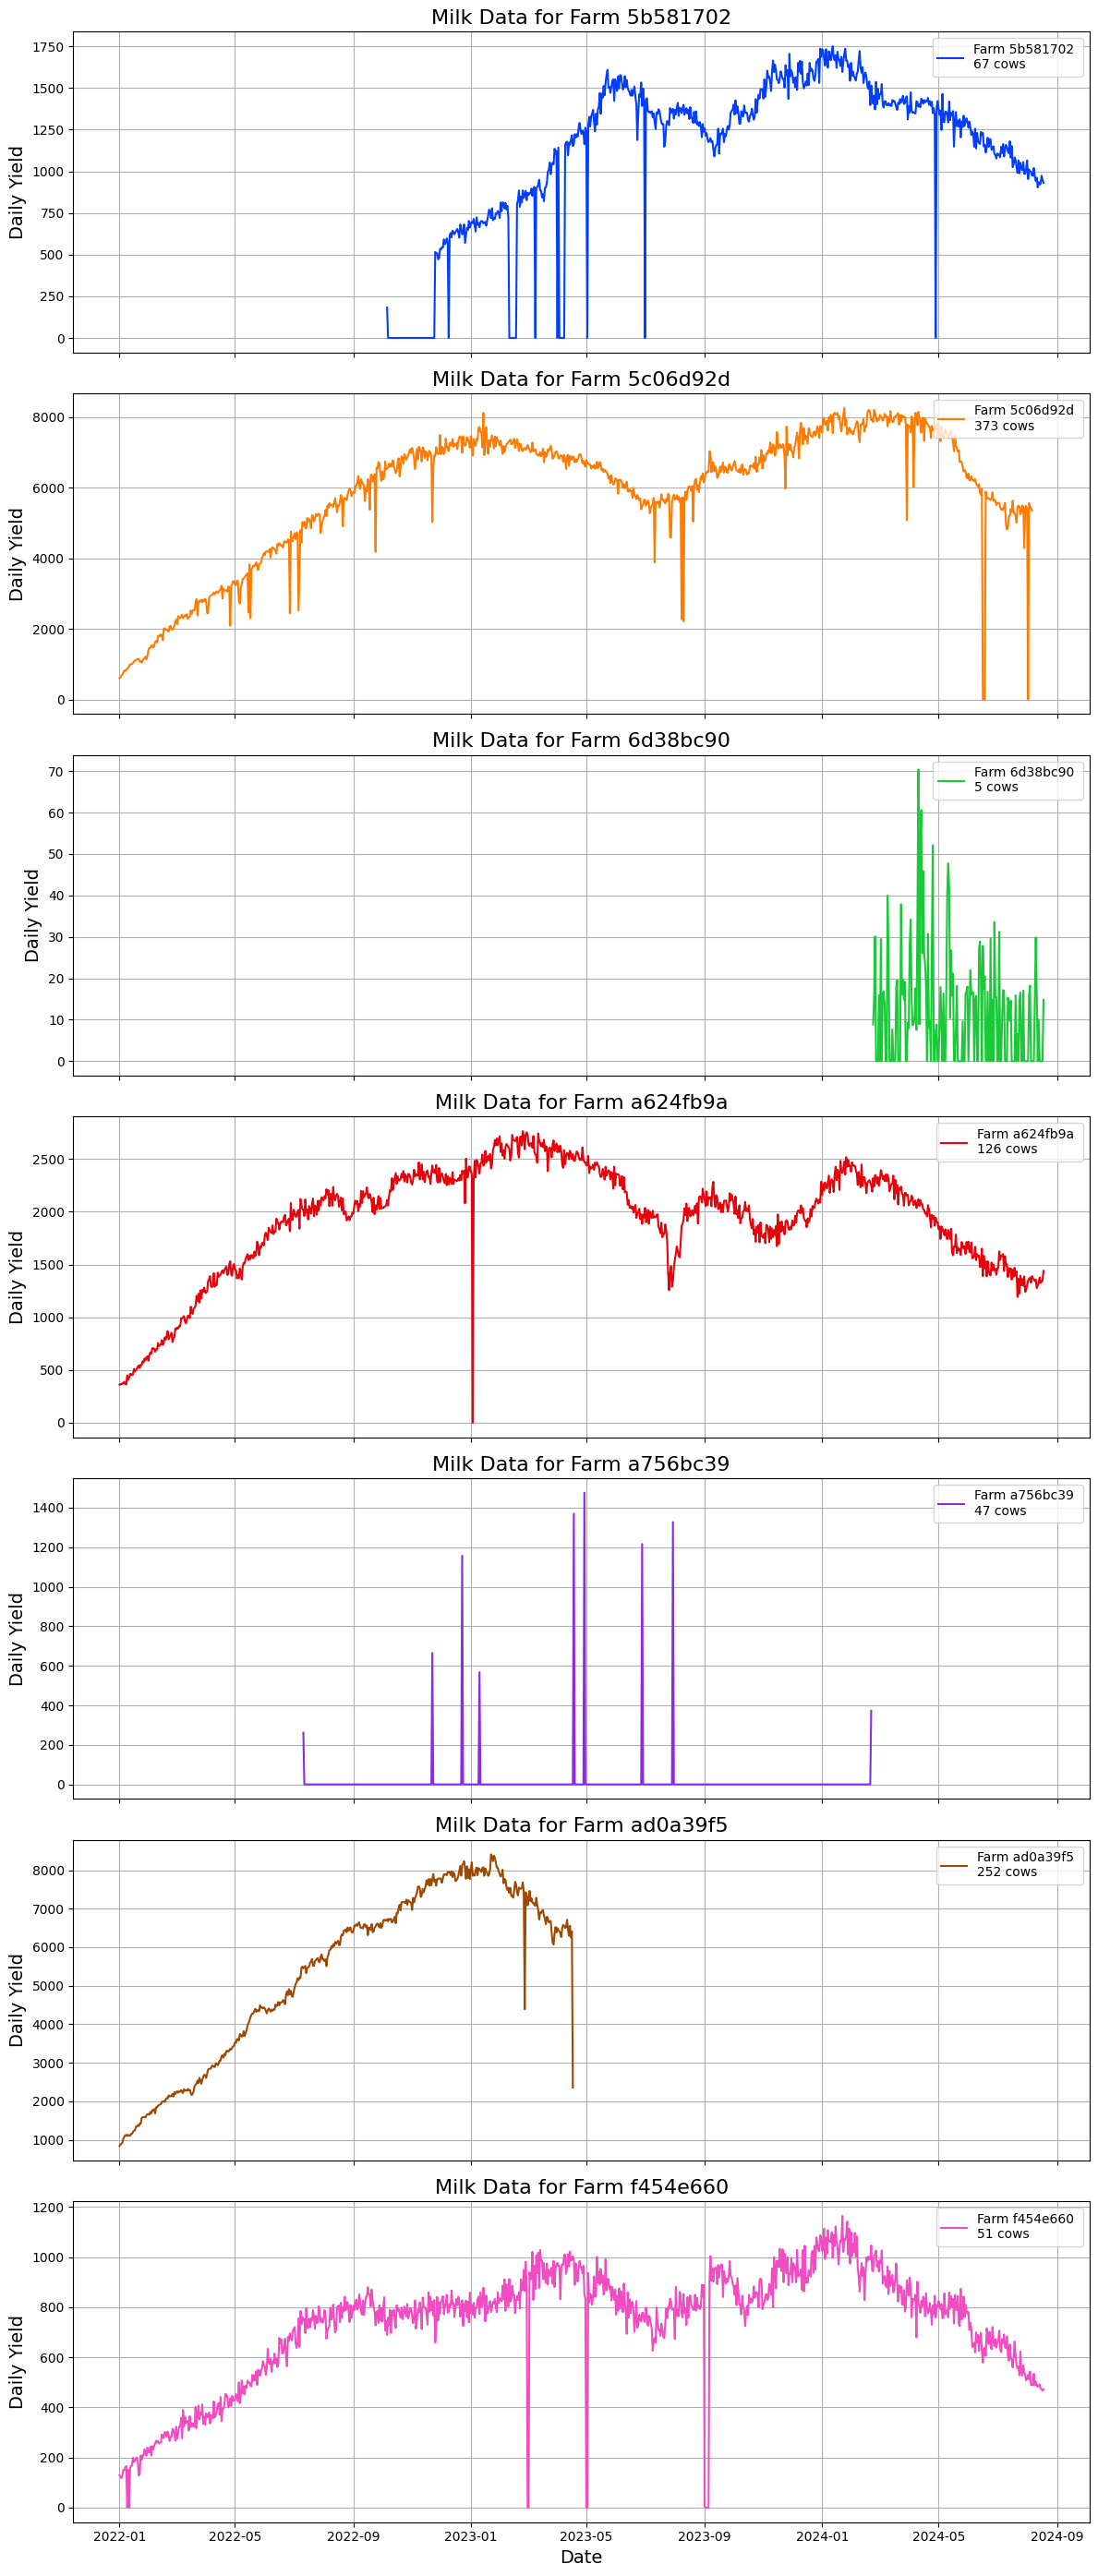

In [53]:
#
#
# LOOK AT MILK YIELD BY HERD EACH DAY
# Load data
df_lact = pd.read_csv("../Data/MY_weather_filtered.csv", low_memory=False)

# Ensure the StartDate column is a datetime object
df_lact['StartDate'] = pd.to_datetime(df_lact['StartDate'])

# list of farms
list_of_farms = list(df_lact["FarmName_Pseudo"].unique())

# Create a subplot for each farm
fig, axs = plt.subplots(len(list_of_farms), 1, figsize=(12, len(list_of_farms) * 4), sharex=True)

# If there's only one subplot, convert axs to a list
if len(list_of_farms) == 1:
    axs = [axs]

# Dictionary to store farm color mapping
farm_color_mapping = {}

# Loop through each farm and plot in its subplot
for i, farm in enumerate(list_of_farms):
    ax = axs[i]

    selected_farm = df_lact[df_lact['FarmName_Pseudo'] == farm]
    number_of_cows = len(selected_farm['SE_Number'].unique())
    daily_yield = selected_farm.groupby('StartDate')['TotalYield'].sum()

    # Get color for this farm, ensuring enough colors
    color = sns.color_palette('bright', n_colors=max(len(list_of_farms), 10))[i]
    farm_color_mapping[farm] = color

    # Generate a complete date range and reindex the daily yield
    all_dates = pd.date_range(start=daily_yield.index.min(), end=daily_yield.index.max(), freq='D')
    daily_yield = daily_yield.reindex(all_dates, fill_value=0)

    # Plot data
    ax.plot(daily_yield.index, daily_yield.values, label=f'Farm {farm} \n{number_of_cows} cows', color=color)
    ax.set_title(f'Milk Data for Farm {farm}', fontsize=16)
    ax.set_ylabel('Daily Yield', fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(True)

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Date', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()